# Bipolar Disorder Subtypes and Mood Stabilisers:

### An NLP exploration of the two main subtypes of bipolar disorder with regards to Reddit posts on mood stabilisers

# Contents (Part 3)

- [Modelling](#Modelling)
- [Data Dictionary](#Data-Dictionary)
- [Results and Analysis](#Results-and-Analysis)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

# Modelling

A classifier can be built from the data which will be able to detect the bipolar subtype of authors of posts within the given scope of the data.

## Importing libraries

Below, we import the necessary libraries.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
import emoji

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve

from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from vecstack import stacking

import shap

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Overrides Matplotlib theme with Seaborn's 
sns.set(font_scale = 1.2)
sns.set_context('talk')

# Enables Pandas to display all the columns
pd.set_option('display.max_columns', None)

# Enables Pandas to display all the rows
pd.set_option('display.max_rows', None)

# Enables Pandas to display more text in a column
pd.set_option('display.max_colwidth', 1000)

# Ignore warnings after model testing complete
import warnings
warnings.filterwarnings('ignore')

## Loading the data 

The dataset is loaded:

In [82]:
sb = pd.read_csv('../data/sb.csv')

In [83]:
sb.head()

,author,created_utc,id,link_flair_text,num_comments,selftext,title,datetime,text,text_num_words,title_num_words,selftext_num_words,year_,month_,day_,week_,day_of_week_,hour_,neg,neu,pos,compound_,serious_,bp_type,weekday_,lithium_,lamotrigine_,quetiapine_
0,PcHaNmErCy,1638572446,r8bce3,99 Problems/Rant/Story,1,"Ever since Wednesday I have been experiencing some pretty intense lows. I don't feel motivated to do anything, I lay in bed all day and into the afternoon sleeping or napping. Sometimes ill just get so sad i break down crying and i don't have a good reason to be sad, or i can't keep my composure. Im feeling a little better today, and i was luckily able to work from home, but I'm still pretty down and cried. Im on my medication of Lamictal and Latuda but i still get downs on occasion like this. Not looking for help or anything. Im just surprised that even being med compliant, seeing my psychiatrist, and therapist regularly that I still have to deal with my bullshit brain. It feels as if my world is ending and there is no reason for it. I hate my dumb brain and how it plays these tricks on me. ughhhhhh..... End Rant",Stupid Brain,2021-12-03 23:00:46,"Stupid Brain Ever since Wednesday I have been experiencing some pretty intense lows. I don't feel motivated to do anything, I lay in bed all day and into the afternoon sleeping or napping. Sometimes ill just get so sad i break down crying and i don't have a good reason to be sad, or i can't keep my composure. Im feeling a little better today, and i was luckily able to work from home, but I'm still pretty down and cried. Im on my medication of Lamictal and Latuda but i still get downs on occasion like this. Not looking for help or anything. Im just surprised that even being med compliant, seeing my psychiatrist, and therapist regularly that I still have to deal with my bullshit brain. It feels as if my world is ending and there is no reason for it. I hate my dumb brain and how it plays these tricks on me. ughhhhhh..... End Rant",159,2,157,2021,12,3,48,4,23,0.238,0.651,0.111,-0.9743,0,2,Fri,0.0,1.0,0.0
1,pandawarrior11,1638537639,r7z01k,Med Question,1,"Hi. I’m a 29F and I have bipolar 1. I was diagnosed in 2011 and have been on different psych meds since.. but sometimes going off at my own will right before having a huge downward spiral and inevitably ending up back in the doctors office with another prescription. My new psych (ins change) says I should be on an anti-depressant, mood stabilizer and an anti-psychotic. I know I’m not on the mild side of bipolar but that makes me feel nervous. She said that anger and rage isn’t often a side affect directly related to bipolar so I need to have an extra med to handle that. So the new med lineup is supposed to be Lamictal, Prozac, Abilify and Cymbalta… I think she plans to remove the Prozac soon but I don’t know what she said. Has anyone had this combo or anyone just have some general words of encouragement? Despite living with it for so long, I’m still afraid every day and of every change. Thank you friends ❤️",Picked up new meds… afraid to start taking them though,2021-12-03 13:20:39,"Picked up new meds… afraid to start taking them though Hi. I’m a 29F and I have bipolar 1. I was diagnosed in 2011 and have been on different psych meds since.. but sometimes going off at my own will right before having a huge downward spiral and inevitably ending up back in the doctors office with another prescription. My new psych (ins change) says I should be on an anti-depressant, mood stabilizer and an anti-psychotic. I know I’m not on the mild side of bipolar but that makes me feel nervous. She said that anger and rage isn’t often a side affect directly related to bipolar so I need to have an extra med to handle that. So the new med lineup is supposed to be Lamictal, Prozac, Abilify and Cymbalta… I think she plans to remove the Prozac soon but I don’t know what she said. Has anyone had this combo or anyone just have some general words of encoura

We will check for null values:

In [84]:
sb.isna().sum()

author                 0
created_utc            0
id                     0
link_flair_text        0
num_comments           0
selftext              90
title                  0
datetime               0
text                   0
text_num_words         0
title_num_words        0
selftext_num_words     0
year_                  0
month_                 0
day_                   0
week_                  0
day_of_week_           0
hour_                  0
neg                    0
neu                    0
pos                    0
compound_              0
serious_               0
bp_type                0
weekday_               0
lithium_               0
lamotrigine_           0
quetiapine_            0
dtype: int64

There are null values in the `selftext`. They will be filled with an empty string:

In [85]:
sb['selftext'].fillna('', inplace=True)

There are no more null values in the DataFrame.

In [86]:
sb.isna().sum().sum()

0

These are the columns in the DataFrame.

In [87]:
sb.columns

Index(['author', 'created_utc', 'id', 'link_flair_text', 'num_comments',
       'selftext', 'title', 'datetime', 'text', 'text_num_words',
       'title_num_words', 'selftext_num_words', 'year_', 'month_', 'day_',
       'week_', 'day_of_week_', 'hour_', 'neg', 'neu', 'pos', 'compound_',
       'serious_', 'bp_type', 'weekday_', 'lithium_', 'lamotrigine_',
       'quetiapine_'],
      dtype='object')

Some unnecessary columns will be dropped.

In [88]:
sb.drop(columns=['author', 
                 'created_utc',
                 'id', 
                 'link_flair_text', 
                 'num_comments',  
                 'selftext', 
                 'title', 
                 'datetime',
                 'title_num_words', 
                 'selftext_num_words', 
                 'weekday_'],
       inplace=True)

The remaining columns are as follows.

In [89]:
sb.columns

Index(['text', 'text_num_words', 'year_', 'month_', 'day_', 'week_',
       'day_of_week_', 'hour_', 'neg', 'neu', 'pos', 'compound_', 'serious_',
       'bp_type', 'lithium_', 'lamotrigine_', 'quetiapine_'],
      dtype='object')

Below is the information on their datatypes. All of them are in numerical format except for the text column.

In [90]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            2500 non-null   object 
 1   text_num_words  2500 non-null   int64  
 2   year_           2500 non-null   int64  
 3   month_          2500 non-null   int64  
 4   day_            2500 non-null   int64  
 5   week_           2500 non-null   int64  
 6   day_of_week_    2500 non-null   int64  
 7   hour_           2500 non-null   int64  
 8   neg             2500 non-null   float64
 9   neu             2500 non-null   float64
 10  pos             2500 non-null   float64
 11  compound_       2500 non-null   float64
 12  serious_        2500 non-null   int64  
 13  bp_type         2500 non-null   int64  
 14  lithium_        2500 non-null   float64
 15  lamotrigine_    2500 non-null   float64
 16  quetiapine_     2500 non-null   float64
dtypes: float64(7), int64(9), object(1

## Data Dictionary

The data dictionary is as follows:

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**text**|object|sb|Combined text of the title and post body.|
|**text_num_words**|int64|sb|Number of words in the combined text of the post.|
|**year_**|int64|sb|Year the post was published.|
|**month_**|int64|sb|Month the post was published.|
|**day_**|int64|sb|Day of the month the post was published.|
|**week_**|int64|sb|Week of the year the post was published.|
|**day_of_week_**|int64|sb|Day of the week the post was published.|
|**hour_**|int64|sb|Hour of the day the post was published.|
|**neg**|int64|sb|The negative score from VADER Sentiment Analysis.|
|**neu**|int64|sb|The neutral score from VADER Sentiment Analysis.|
|**pos**|int64|sb|The positive score from VADER Sentiment Analysis.|
|**compound_**|int64|sb|The compound score from VADER Sentiment Analysis.|
|**serious_**|int64|sb|Indicator for if the topic of the post was serious or crisis-related.|
|**bp_type**|int64|sb|Bipolar type of the post author.|
|**lithium_**|int64|sb|Indicator for if the post contains the word 'lithium'.|
|**lamotrigine_**|int64|sb|Indicator for if the post contains the words 'lamotrigine' or 'lamictal.|
|**quetiapine_**|int64|sb|Indicator for if the post contains the words 'quetiapine' or 'seroquel'.|

## Splitting the data

We will first conduct the modelling with only the `text` column.

The X portion of the data (features) will simply be the `text` column, and the y portion will be the `bp_type` column. The data is assigned as follows: 

In [96]:
X = sb.drop(columns=['bp_type'])
y = sb['bp_type']

A train-test split is done on the data.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=1, 
                                                    stratify=y)

As seen below, the classes are fairly balanced. We will go ahead with modelling without correction for class imbalances.

In [13]:
y_train.value_counts(normalize=True)

2    0.5745
1    0.4255
Name: bp_type, dtype: float64

The value counts of the target in the test set is as follows:

In [14]:
y_test.value_counts(normalize=True)

2    0.574
1    0.426
Name: bp_type, dtype: float64

## Text cleaning

The function from the previous notebook will be used. However, we can convert emojis the to their textual form to preserve any semantic information. Hence, the function here will contain an additional line to convert the emojis. We will not use custom stopwords.

In [15]:
stopwords = nltk.corpus.stopwords.words('english')

wn = nltk.WordNetLemmatizer()

def clean_text(text):

    # Converts emojis to their textual form
    text = emoji.demojize(text)
    
    # Tokenisation and punctuation removal. \W matches any non-word character (equivalent to [^a-zA-Z0-9_]).
    # Since \W does not match underscores, we specify '\W+|_' (\W or underscore).
    # Splits the text at any of these non-word characters (or groups of them). 
    # The '+' is to handle cases where there are 2 or more non-word characters between certain words
    tokens = re.split('\W+|_', text)
 
    # Removes all words that contain non-ASCII printable characters
    ascii_chars = set(string.printable)
    tokens =  [word for word in tokens if all(char in ascii_chars for char in word)]
    
    # Removes all empty strings, e.g. ''
    tokens = [word for word in tokens if word]
   
    # Apply lemmatisation, lowercasing and stopwords exclusion within the same step.
    tokens = [wn.lemmatize(word.lower()) for word in tokens if word.lower() not in stopwords] 
     
    return tokens

## CountVectorizer 

After the `CountVectorizer` is applied, there can be several thousands of unique words. Therefore, some optimisation can be done for the `CountVectorizer`. 

Scikit-learn's `Pipeline` class allows us to create a pipeline where `GridSearchCV` can help us search over the possible parameters of the `CountVectorizer` that return the best model performance. The vectorizer can be set to only include the top words in the data according to a specified number, or only include words when they appear in a specified number of posts. It can also exclude words that are too common which appear in more than a specified percentage of posts.

As this is a very resource-intensive operation, the vectorizer will be optimised on the `CatBoostClassifier` as a starting point, and we will use these parameters to generate an array. This reduced array will be used for subsequent modelling. 

CatBoost is a gradient boosting algorithm on decision trees.

The following code runs the grid search.

In [205]:
# Setting up the Pipeline with CatBoostClassifier
# The CountVectorizer uses the 'clean_text' function defined above
pipe = Pipeline([
    ('cvec', CountVectorizer(analyzer=clean_text)),
    ('catb', CatBoostClassifier())
])

# Search over the following values of hyperparameters:

pipe_params = dict()

pipe_params['cvec__max_features'] = [4_000, 6_000, 8_000]
pipe_params['cvec__min_df'] = [3]
pipe_params['cvec__max_df'] = [.9]
pipe_params['cvec__ngram_range'] = [(1,1), (1,2)]
pipe_params['catb__depth'] = [4, 5, 6, 7, 8, 9, 10]
pipe_params['catb__learning_rate'] = np.linspace(0,0.2,5)
pipe_params['catb__iterations'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
pipe_params['catb__task_type'] = ['GPU']

# Instantiate RandomizedSearchCV.
rs = RandomizedSearchCV(pipe, # The object being optimised
                        pipe_params, n_iter=100, scoring='accuracy', # The dictionary of parameters
                        cv=5, # 5-fold cross-validation
                        n_jobs=-1, # Use all available processors in computer
                        verbose=1, random_state=1) # Generate more detailed output

# Fit the pipeline to the training data.
rs.fit(X_train['text'], y_train, catb__early_stopping_rounds=5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 46.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 53.6min finished


0:	learn: 0.6625244	total: 49.5ms	remaining: 3.42s
1:	learn: 0.6405861	total: 96.1ms	remaining: 3.27s
2:	learn: 0.6208475	total: 143ms	remaining: 3.19s
3:	learn: 0.6007480	total: 185ms	remaining: 3.06s
4:	learn: 0.5884440	total: 223ms	remaining: 2.9s
5:	learn: 0.5779745	total: 256ms	remaining: 2.73s
6:	learn: 0.5654932	total: 300ms	remaining: 2.7s
7:	learn: 0.5557244	total: 332ms	remaining: 2.58s
8:	learn: 0.5453657	total: 375ms	remaining: 2.54s
9:	learn: 0.5362924	total: 411ms	remaining: 2.46s
10:	learn: 0.5308877	total: 444ms	remaining: 2.38s
11:	learn: 0.5232483	total: 483ms	remaining: 2.33s
12:	learn: 0.5185989	total: 514ms	remaining: 2.25s
13:	learn: 0.5126961	total: 543ms	remaining: 2.17s
14:	learn: 0.5087997	total: 570ms	remaining: 2.09s
15:	learn: 0.5033407	total: 604ms	remaining: 2.04s
16:	learn: 0.4996350	total: 633ms	remaining: 1.97s
17:	learn: 0.4939577	total: 668ms	remaining: 1.93s
18:	learn: 0.4886364	total: 708ms	remaining: 1.9s
19:	learn: 0.4841172	total: 745ms	remainin

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec',
                                              CountVectorizer(analyzer=<function clean_text at 0x000002182D7B80D0>)),
                                             ('catb',
                                              <catboost.core.CatBoostClassifier object at 0x0000021838B291C0>)]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'catb__depth': [4, 5, 6, 7, 8, 9, 10],
                                        'catb__iterations': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100],
                                        'catb__learning_rate': array([0.  , 0.05, 0.1 , 0.15, 0.2 ]),
                                        'catb__task_type': ['GPU'],
                                        'cvec__max_df': [0.9],
                                        'cvec__max_featu

The model's score on the training set:

In [206]:
rs.score(X_train['text'], y_train)

0.9175

The model's score on the test set:

In [207]:
rs.score(X_test['text'], y_test)

0.684

These are the best parameters for the `CountVectorizer`.

In [208]:
rs.best_params_

{'cvec__ngram_range': (1, 1),
 'cvec__min_df': 3,
 'cvec__max_features': 4000,
 'cvec__max_df': 0.9,
 'catb__task_type': 'GPU',
 'catb__learning_rate': 0.15000000000000002,
 'catb__iterations': 70,
 'catb__depth': 8}

We will use these parameters to generate an optimised array for subsequent modelling. It seems that we can restrict the number of words used by the model, and bigrams are not better than unigrams in this case. 

In [16]:
count_vect = CountVectorizer(analyzer=clean_text, 
                             max_features=4000, 
                             min_df=3, 
                             max_df=0.9, 
                             ngram_range=(1, 1))

X_train_count = count_vect.fit_transform(X_train['text'])
X_test_count = count_vect.transform(X_test['text'])

## TfidfVectorizer 

After the `TfidfVectorizer` is applied, there can be several thousand unique words. Therefore, some optimisation can be done for the `TfidfVectorizer` in the same manner as before.

As this is a very resource-intensive operation, the vectorizer will be optimised on the `CatBoostClassifier` as a starting point, and we will use these parameters to generate an array. This reduced array will be used for subsequent modelling. 

The following code runs the grid search.

In [110]:
# Setting up the Pipeline with Multinomial Naive Bayes
# The TfidfVectorizer uses the 'clean_text' function defined above
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(analyzer=clean_text)),
    ('catb', CatBoostClassifier())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Try an array with (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = dict()

pipe_params['tvec__max_features'] = [4_000, 6_000, 8_000]
pipe_params['tvec__min_df'] = [3]
pipe_params['tvec__max_df'] = [.9]
pipe_params['tvec__ngram_range'] = [(1,1), (1,2)]
pipe_params['catb__depth'] = [4, 5, 6, 7, 8, 9, 10]
pipe_params['catb__learning_rate'] = [0.01, 0.02, 0.03, 0.04]
pipe_params['catb__iterations'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Instantiate GridSearchCV.
rs = RandomizedSearchCV(pipe_tvec, # The object being optimised
                  pipe_params, n_iter=100, # The dictionary of parameters
                  cv=5, # 5-fold cross-validation
                  n_jobs=-1, # Use all available processors in computer
                  verbose=1) # Generate more detailed output

# Fit the pipeline to the training data.
rs.fit(X_train['text'], y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 72.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 86.8min finished


0:	learn: 0.6882074	total: 96.3ms	remaining: 9.53s
1:	learn: 0.6827275	total: 178ms	remaining: 8.72s
2:	learn: 0.6785671	total: 258ms	remaining: 8.33s
3:	learn: 0.6748552	total: 335ms	remaining: 8.04s
4:	learn: 0.6716331	total: 412ms	remaining: 7.82s
5:	learn: 0.6682205	total: 489ms	remaining: 7.66s
6:	learn: 0.6647952	total: 566ms	remaining: 7.53s
7:	learn: 0.6620278	total: 643ms	remaining: 7.4s
8:	learn: 0.6586889	total: 721ms	remaining: 7.29s
9:	learn: 0.6568429	total: 799ms	remaining: 7.19s
10:	learn: 0.6526647	total: 876ms	remaining: 7.09s
11:	learn: 0.6500500	total: 954ms	remaining: 7s
12:	learn: 0.6486086	total: 1.03s	remaining: 6.91s
13:	learn: 0.6458884	total: 1.11s	remaining: 6.83s
14:	learn: 0.6442834	total: 1.2s	remaining: 6.8s
15:	learn: 0.6417241	total: 1.29s	remaining: 6.78s
16:	learn: 0.6397308	total: 1.38s	remaining: 6.74s
17:	learn: 0.6372990	total: 1.46s	remaining: 6.65s
18:	learn: 0.6349119	total: 1.54s	remaining: 6.56s
19:	learn: 0.6333663	total: 1.62s	remaining: 6

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec',
                                              TfidfVectorizer(analyzer=<function clean_text at 0x000002182D7B80D0>)),
                                             ('catb',
                                              <catboost.core.CatBoostClassifier object at 0x000002182E81CDC0>)]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'catb__depth': [4, 5, 6, 7, 8, 9, 10],
                                        'catb__iterations': [10, 20, 30, 40, 50,
                                                             60, 70, 80, 90,
                                                             100],
                                        'catb__learning_rate': [0.01, 0.02,
                                                                0.03, 0.04],
                                        'tvec__max_df': [0.9],
                                        'tvec__max_features': [4000, 6000

The model's score on the training set:

In [112]:
rs.score(X_train['text'], y_train)

0.7705

The model's score on the test set:

In [113]:
rs.score(X_test['text'], y_test)

0.684

These are the best parameters for the `TfidfVectorizer`.

In [114]:
rs.best_params_

{'tvec__ngram_range': (1, 2),
 'tvec__min_df': 3,
 'tvec__max_features': 4000,
 'tvec__max_df': 0.9,
 'catb__learning_rate': 0.04,
 'catb__iterations': 100,
 'catb__depth': 7}

We will use these parameters to generate an optimised array for subsequent modelling. It seems that we can restrict the number of words used by the model, and bigrams are not better than unigrams in this case. 

In [17]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text, 
                             max_features=4000, 
                             min_df=3, 
                             max_df=0.9, 
                             ngram_range = (1,2))

X_train_tfidf = tfidf_vect.fit_transform(X_train['text'])
X_test_tfidf = tfidf_vect.transform(X_test['text'])

## CatBoost Classifier

### CatBoost Classifier with defaults on count-vectorised data

We will run the CatBoost Classifier with default parameters. First, we will run it on the count-vectorised data.

In [18]:
cb_c = CatBoostClassifier(random_state=0)

In [19]:
cb_c.fit(X_train_count, y_train)

Learning rate set to 0.013851
0:	learn: 0.6919482	total: 165ms	remaining: 2m 44s
1:	learn: 0.6909957	total: 181ms	remaining: 1m 30s
2:	learn: 0.6896239	total: 195ms	remaining: 1m 4s
3:	learn: 0.6885378	total: 212ms	remaining: 52.9s
4:	learn: 0.6870364	total: 227ms	remaining: 45.2s
5:	learn: 0.6862347	total: 241ms	remaining: 40s
6:	learn: 0.6851986	total: 255ms	remaining: 36.2s
7:	learn: 0.6838817	total: 269ms	remaining: 33.4s
8:	learn: 0.6825876	total: 283ms	remaining: 31.1s
9:	learn: 0.6818048	total: 296ms	remaining: 29.3s
10:	learn: 0.6809314	total: 309ms	remaining: 27.8s
11:	learn: 0.6799382	total: 322ms	remaining: 26.5s
12:	learn: 0.6784022	total: 335ms	remaining: 25.5s
13:	learn: 0.6771960	total: 348ms	remaining: 24.5s
14:	learn: 0.6764691	total: 361ms	remaining: 23.7s
15:	learn: 0.6755573	total: 374ms	remaining: 23s
16:	learn: 0.6747272	total: 390ms	remaining: 22.5s
17:	learn: 0.6735213	total: 407ms	remaining: 22.2s
18:	learn: 0.6723820	total: 421ms	remaining: 21.7s
19:	learn: 0.

163:	learn: 0.5997430	total: 2.61s	remaining: 13.3s
164:	learn: 0.5995637	total: 2.62s	remaining: 13.3s
165:	learn: 0.5992160	total: 2.64s	remaining: 13.2s
166:	learn: 0.5989111	total: 2.65s	remaining: 13.2s
167:	learn: 0.5985175	total: 2.67s	remaining: 13.2s
168:	learn: 0.5982717	total: 2.68s	remaining: 13.2s
169:	learn: 0.5980925	total: 2.7s	remaining: 13.2s
170:	learn: 0.5976354	total: 2.71s	remaining: 13.1s
171:	learn: 0.5973088	total: 2.73s	remaining: 13.1s
172:	learn: 0.5970206	total: 2.74s	remaining: 13.1s
173:	learn: 0.5967320	total: 2.76s	remaining: 13.1s
174:	learn: 0.5965220	total: 2.77s	remaining: 13.1s
175:	learn: 0.5962143	total: 2.78s	remaining: 13s
176:	learn: 0.5958831	total: 2.8s	remaining: 13s
177:	learn: 0.5955854	total: 2.81s	remaining: 13s
178:	learn: 0.5953474	total: 2.83s	remaining: 13s
179:	learn: 0.5949735	total: 2.85s	remaining: 13s
180:	learn: 0.5944729	total: 2.86s	remaining: 12.9s
181:	learn: 0.5942654	total: 2.87s	remaining: 12.9s
182:	learn: 0.5941304	to

329:	learn: 0.5605853	total: 5.39s	remaining: 10.9s
330:	learn: 0.5603829	total: 5.4s	remaining: 10.9s
331:	learn: 0.5600862	total: 5.42s	remaining: 10.9s
332:	learn: 0.5599510	total: 5.44s	remaining: 10.9s
333:	learn: 0.5597339	total: 5.45s	remaining: 10.9s
334:	learn: 0.5596874	total: 5.47s	remaining: 10.9s
335:	learn: 0.5595381	total: 5.49s	remaining: 10.8s
336:	learn: 0.5592405	total: 5.5s	remaining: 10.8s
337:	learn: 0.5591401	total: 5.51s	remaining: 10.8s
338:	learn: 0.5587388	total: 5.53s	remaining: 10.8s
339:	learn: 0.5585534	total: 5.54s	remaining: 10.8s
340:	learn: 0.5581554	total: 5.57s	remaining: 10.8s
341:	learn: 0.5580005	total: 5.59s	remaining: 10.8s
342:	learn: 0.5577597	total: 5.62s	remaining: 10.8s
343:	learn: 0.5575016	total: 5.63s	remaining: 10.7s
344:	learn: 0.5572481	total: 5.65s	remaining: 10.7s
345:	learn: 0.5570918	total: 5.66s	remaining: 10.7s
346:	learn: 0.5569128	total: 5.68s	remaining: 10.7s
347:	learn: 0.5567499	total: 5.7s	remaining: 10.7s
348:	learn: 0.5

495:	learn: 0.5296014	total: 8.15s	remaining: 8.29s
496:	learn: 0.5294048	total: 8.17s	remaining: 8.27s
497:	learn: 0.5291598	total: 8.19s	remaining: 8.26s
498:	learn: 0.5290086	total: 8.21s	remaining: 8.25s
499:	learn: 0.5288225	total: 8.23s	remaining: 8.23s
500:	learn: 0.5286761	total: 8.25s	remaining: 8.22s
501:	learn: 0.5283857	total: 8.28s	remaining: 8.21s
502:	learn: 0.5279873	total: 8.3s	remaining: 8.2s
503:	learn: 0.5277501	total: 8.33s	remaining: 8.2s
504:	learn: 0.5274186	total: 8.35s	remaining: 8.18s
505:	learn: 0.5271385	total: 8.37s	remaining: 8.17s
506:	learn: 0.5268357	total: 8.38s	remaining: 8.15s
507:	learn: 0.5266533	total: 8.4s	remaining: 8.14s
508:	learn: 0.5265182	total: 8.42s	remaining: 8.12s
509:	learn: 0.5261812	total: 8.43s	remaining: 8.1s
510:	learn: 0.5259441	total: 8.44s	remaining: 8.08s
511:	learn: 0.5257808	total: 8.46s	remaining: 8.07s
512:	learn: 0.5254655	total: 8.48s	remaining: 8.05s
513:	learn: 0.5253261	total: 8.5s	remaining: 8.04s
514:	learn: 0.5249

654:	learn: 0.4887830	total: 10.6s	remaining: 5.6s
655:	learn: 0.4885719	total: 10.7s	remaining: 5.58s
656:	learn: 0.4882047	total: 10.7s	remaining: 5.57s
657:	learn: 0.4880346	total: 10.7s	remaining: 5.55s
658:	learn: 0.4877481	total: 10.7s	remaining: 5.53s
659:	learn: 0.4875532	total: 10.7s	remaining: 5.51s
660:	learn: 0.4873392	total: 10.7s	remaining: 5.5s
661:	learn: 0.4871433	total: 10.7s	remaining: 5.48s
662:	learn: 0.4868968	total: 10.8s	remaining: 5.46s
663:	learn: 0.4866249	total: 10.8s	remaining: 5.45s
664:	learn: 0.4864153	total: 10.8s	remaining: 5.43s
665:	learn: 0.4860995	total: 10.8s	remaining: 5.42s
666:	learn: 0.4859070	total: 10.8s	remaining: 5.4s
667:	learn: 0.4856175	total: 10.8s	remaining: 5.38s
668:	learn: 0.4854727	total: 10.8s	remaining: 5.37s
669:	learn: 0.4852093	total: 10.9s	remaining: 5.35s
670:	learn: 0.4850358	total: 10.9s	remaining: 5.33s
671:	learn: 0.4845995	total: 10.9s	remaining: 5.31s
672:	learn: 0.4843793	total: 10.9s	remaining: 5.3s
673:	learn: 0.48

814:	learn: 0.4470120	total: 13.1s	remaining: 2.98s
815:	learn: 0.4467288	total: 13.2s	remaining: 2.97s
816:	learn: 0.4465588	total: 13.2s	remaining: 2.95s
817:	learn: 0.4463975	total: 13.2s	remaining: 2.93s
818:	learn: 0.4461729	total: 13.2s	remaining: 2.92s
819:	learn: 0.4459060	total: 13.2s	remaining: 2.9s
820:	learn: 0.4456846	total: 13.3s	remaining: 2.89s
821:	learn: 0.4454098	total: 13.3s	remaining: 2.87s
822:	learn: 0.4451060	total: 13.3s	remaining: 2.86s
823:	learn: 0.4448415	total: 13.3s	remaining: 2.84s
824:	learn: 0.4445347	total: 13.3s	remaining: 2.82s
825:	learn: 0.4444333	total: 13.3s	remaining: 2.81s
826:	learn: 0.4442048	total: 13.3s	remaining: 2.79s
827:	learn: 0.4439443	total: 13.4s	remaining: 2.77s
828:	learn: 0.4437686	total: 13.4s	remaining: 2.76s
829:	learn: 0.4433792	total: 13.4s	remaining: 2.74s
830:	learn: 0.4432580	total: 13.4s	remaining: 2.73s
831:	learn: 0.4431496	total: 13.4s	remaining: 2.71s
832:	learn: 0.4429115	total: 13.4s	remaining: 2.69s
833:	learn: 0

980:	learn: 0.4110339	total: 15.8s	remaining: 306ms
981:	learn: 0.4108132	total: 15.8s	remaining: 290ms
982:	learn: 0.4105455	total: 15.8s	remaining: 274ms
983:	learn: 0.4104617	total: 15.8s	remaining: 257ms
984:	learn: 0.4103997	total: 15.8s	remaining: 241ms
985:	learn: 0.4102752	total: 15.9s	remaining: 225ms
986:	learn: 0.4101251	total: 15.9s	remaining: 209ms
987:	learn: 0.4100412	total: 15.9s	remaining: 193ms
988:	learn: 0.4098190	total: 15.9s	remaining: 177ms
989:	learn: 0.4095851	total: 15.9s	remaining: 161ms
990:	learn: 0.4093935	total: 15.9s	remaining: 145ms
991:	learn: 0.4091360	total: 16s	remaining: 129ms
992:	learn: 0.4089516	total: 16s	remaining: 113ms
993:	learn: 0.4088125	total: 16s	remaining: 96.5ms
994:	learn: 0.4086074	total: 16s	remaining: 80.5ms
995:	learn: 0.4085002	total: 16.1s	remaining: 64.5ms
996:	learn: 0.4080992	total: 16.1s	remaining: 48.4ms
997:	learn: 0.4079059	total: 16.1s	remaining: 32.2ms
998:	learn: 0.4077203	total: 16.1s	remaining: 16.1ms
999:	learn: 0.

In [20]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(cb_c, X_train_count, y_train, cv=5).mean())

Learning rate set to 0.012592
0:	learn: 0.6917548	total: 15.4ms	remaining: 15.4s
1:	learn: 0.6906554	total: 31.6ms	remaining: 15.8s
2:	learn: 0.6895187	total: 45.5ms	remaining: 15.1s
3:	learn: 0.6884692	total: 59.8ms	remaining: 14.9s
4:	learn: 0.6871262	total: 75.4ms	remaining: 15s
5:	learn: 0.6858903	total: 88.3ms	remaining: 14.6s
6:	learn: 0.6847469	total: 104ms	remaining: 14.8s
7:	learn: 0.6840315	total: 117ms	remaining: 14.5s
8:	learn: 0.6829667	total: 132ms	remaining: 14.5s
9:	learn: 0.6816707	total: 146ms	remaining: 14.5s
10:	learn: 0.6807816	total: 159ms	remaining: 14.3s
11:	learn: 0.6799492	total: 177ms	remaining: 14.5s
12:	learn: 0.6792245	total: 192ms	remaining: 14.6s
13:	learn: 0.6782372	total: 205ms	remaining: 14.4s
14:	learn: 0.6774817	total: 218ms	remaining: 14.3s
15:	learn: 0.6767891	total: 234ms	remaining: 14.4s
16:	learn: 0.6760670	total: 252ms	remaining: 14.6s
17:	learn: 0.6752167	total: 269ms	remaining: 14.7s
18:	learn: 0.6743933	total: 290ms	remaining: 15s
19:	learn

168:	learn: 0.6004838	total: 2.73s	remaining: 13.4s
169:	learn: 0.6001913	total: 2.76s	remaining: 13.5s
170:	learn: 0.5997120	total: 2.78s	remaining: 13.5s
171:	learn: 0.5996020	total: 2.8s	remaining: 13.5s
172:	learn: 0.5992155	total: 2.82s	remaining: 13.5s
173:	learn: 0.5989150	total: 2.83s	remaining: 13.4s
174:	learn: 0.5985100	total: 2.85s	remaining: 13.4s
175:	learn: 0.5982842	total: 2.86s	remaining: 13.4s
176:	learn: 0.5980787	total: 2.87s	remaining: 13.4s
177:	learn: 0.5975446	total: 2.89s	remaining: 13.3s
178:	learn: 0.5973182	total: 2.9s	remaining: 13.3s
179:	learn: 0.5970249	total: 2.91s	remaining: 13.3s
180:	learn: 0.5967789	total: 2.93s	remaining: 13.2s
181:	learn: 0.5961964	total: 2.96s	remaining: 13.3s
182:	learn: 0.5959352	total: 2.98s	remaining: 13.3s
183:	learn: 0.5958102	total: 3s	remaining: 13.3s
184:	learn: 0.5955929	total: 3.02s	remaining: 13.3s
185:	learn: 0.5950867	total: 3.05s	remaining: 13.3s
186:	learn: 0.5949060	total: 3.07s	remaining: 13.3s
187:	learn: 0.594

329:	learn: 0.5608257	total: 5.28s	remaining: 10.7s
330:	learn: 0.5604493	total: 5.3s	remaining: 10.7s
331:	learn: 0.5603104	total: 5.31s	remaining: 10.7s
332:	learn: 0.5601768	total: 5.32s	remaining: 10.7s
333:	learn: 0.5600263	total: 5.34s	remaining: 10.6s
334:	learn: 0.5597699	total: 5.35s	remaining: 10.6s
335:	learn: 0.5593872	total: 5.36s	remaining: 10.6s
336:	learn: 0.5591789	total: 5.38s	remaining: 10.6s
337:	learn: 0.5590166	total: 5.39s	remaining: 10.6s
338:	learn: 0.5587656	total: 5.41s	remaining: 10.6s
339:	learn: 0.5585024	total: 5.42s	remaining: 10.5s
340:	learn: 0.5584212	total: 5.44s	remaining: 10.5s
341:	learn: 0.5582873	total: 5.45s	remaining: 10.5s
342:	learn: 0.5580754	total: 5.47s	remaining: 10.5s
343:	learn: 0.5577467	total: 5.49s	remaining: 10.5s
344:	learn: 0.5575737	total: 5.5s	remaining: 10.4s
345:	learn: 0.5573604	total: 5.51s	remaining: 10.4s
346:	learn: 0.5572170	total: 5.53s	remaining: 10.4s
347:	learn: 0.5570982	total: 5.54s	remaining: 10.4s
348:	learn: 0.

501:	learn: 0.5284386	total: 7.77s	remaining: 7.71s
502:	learn: 0.5281989	total: 7.78s	remaining: 7.69s
503:	learn: 0.5279576	total: 7.79s	remaining: 7.67s
504:	learn: 0.5276522	total: 7.81s	remaining: 7.65s
505:	learn: 0.5275452	total: 7.82s	remaining: 7.63s
506:	learn: 0.5272678	total: 7.83s	remaining: 7.62s
507:	learn: 0.5271657	total: 7.85s	remaining: 7.6s
508:	learn: 0.5267657	total: 7.86s	remaining: 7.58s
509:	learn: 0.5266335	total: 7.88s	remaining: 7.57s
510:	learn: 0.5264064	total: 7.89s	remaining: 7.55s
511:	learn: 0.5261725	total: 7.9s	remaining: 7.53s
512:	learn: 0.5260327	total: 7.91s	remaining: 7.51s
513:	learn: 0.5257965	total: 7.93s	remaining: 7.49s
514:	learn: 0.5256593	total: 7.94s	remaining: 7.48s
515:	learn: 0.5252831	total: 7.95s	remaining: 7.46s
516:	learn: 0.5250187	total: 7.96s	remaining: 7.44s
517:	learn: 0.5247623	total: 8s	remaining: 7.44s
518:	learn: 0.5245676	total: 8.02s	remaining: 7.43s
519:	learn: 0.5244476	total: 8.03s	remaining: 7.42s
520:	learn: 0.524

669:	learn: 0.4871944	total: 10.3s	remaining: 5.08s
670:	learn: 0.4869201	total: 10.3s	remaining: 5.07s
671:	learn: 0.4866416	total: 10.4s	remaining: 5.05s
672:	learn: 0.4864602	total: 10.4s	remaining: 5.04s
673:	learn: 0.4861636	total: 10.4s	remaining: 5.02s
674:	learn: 0.4859576	total: 10.4s	remaining: 5.01s
675:	learn: 0.4857264	total: 10.4s	remaining: 4.99s
676:	learn: 0.4855692	total: 10.4s	remaining: 4.97s
677:	learn: 0.4853533	total: 10.4s	remaining: 4.96s
678:	learn: 0.4851538	total: 10.4s	remaining: 4.94s
679:	learn: 0.4849035	total: 10.5s	remaining: 4.94s
680:	learn: 0.4845932	total: 10.5s	remaining: 4.93s
681:	learn: 0.4844304	total: 10.6s	remaining: 4.92s
682:	learn: 0.4840068	total: 10.6s	remaining: 4.91s
683:	learn: 0.4837860	total: 10.6s	remaining: 4.9s
684:	learn: 0.4836228	total: 10.6s	remaining: 4.88s
685:	learn: 0.4833424	total: 10.6s	remaining: 4.87s
686:	learn: 0.4831910	total: 10.6s	remaining: 4.85s
687:	learn: 0.4829914	total: 10.7s	remaining: 4.83s
688:	learn: 0

836:	learn: 0.4426740	total: 13.3s	remaining: 2.58s
837:	learn: 0.4424615	total: 13.3s	remaining: 2.57s
838:	learn: 0.4422432	total: 13.3s	remaining: 2.55s
839:	learn: 0.4421196	total: 13.3s	remaining: 2.54s
840:	learn: 0.4419913	total: 13.3s	remaining: 2.52s
841:	learn: 0.4417327	total: 13.3s	remaining: 2.5s
842:	learn: 0.4414188	total: 13.4s	remaining: 2.49s
843:	learn: 0.4412698	total: 13.4s	remaining: 2.47s
844:	learn: 0.4411264	total: 13.4s	remaining: 2.45s
845:	learn: 0.4408686	total: 13.4s	remaining: 2.44s
846:	learn: 0.4407584	total: 13.4s	remaining: 2.42s
847:	learn: 0.4405014	total: 13.4s	remaining: 2.41s
848:	learn: 0.4403576	total: 13.4s	remaining: 2.39s
849:	learn: 0.4401144	total: 13.5s	remaining: 2.38s
850:	learn: 0.4399409	total: 13.5s	remaining: 2.36s
851:	learn: 0.4398034	total: 13.5s	remaining: 2.34s
852:	learn: 0.4393847	total: 13.5s	remaining: 2.33s
853:	learn: 0.4389628	total: 13.5s	remaining: 2.31s
854:	learn: 0.4386592	total: 13.6s	remaining: 2.3s
855:	learn: 0.

Learning rate set to 0.012592
0:	learn: 0.6923061	total: 14.5ms	remaining: 14.5s
1:	learn: 0.6915839	total: 27ms	remaining: 13.5s
2:	learn: 0.6901099	total: 39.7ms	remaining: 13.2s
3:	learn: 0.6890106	total: 52.4ms	remaining: 13.1s
4:	learn: 0.6878677	total: 66.5ms	remaining: 13.2s
5:	learn: 0.6868279	total: 79.1ms	remaining: 13.1s
6:	learn: 0.6857780	total: 92ms	remaining: 13.1s
7:	learn: 0.6850867	total: 105ms	remaining: 13s
8:	learn: 0.6839204	total: 117ms	remaining: 12.9s
9:	learn: 0.6833079	total: 131ms	remaining: 13s
10:	learn: 0.6821790	total: 146ms	remaining: 13.1s
11:	learn: 0.6815929	total: 160ms	remaining: 13.2s
12:	learn: 0.6807395	total: 176ms	remaining: 13.3s
13:	learn: 0.6799709	total: 191ms	remaining: 13.5s
14:	learn: 0.6793961	total: 207ms	remaining: 13.6s
15:	learn: 0.6784709	total: 220ms	remaining: 13.5s
16:	learn: 0.6776801	total: 234ms	remaining: 13.5s
17:	learn: 0.6769609	total: 248ms	remaining: 13.5s
18:	learn: 0.6762875	total: 269ms	remaining: 13.9s
19:	learn: 0

172:	learn: 0.6038737	total: 2.73s	remaining: 13.1s
173:	learn: 0.6037194	total: 2.76s	remaining: 13.1s
174:	learn: 0.6035143	total: 2.78s	remaining: 13.1s
175:	learn: 0.6033130	total: 2.8s	remaining: 13.1s
176:	learn: 0.6030117	total: 2.81s	remaining: 13.1s
177:	learn: 0.6027743	total: 2.83s	remaining: 13.1s
178:	learn: 0.6025999	total: 2.84s	remaining: 13s
179:	learn: 0.6023360	total: 2.85s	remaining: 13s
180:	learn: 0.6021939	total: 2.87s	remaining: 13s
181:	learn: 0.6019088	total: 2.88s	remaining: 12.9s
182:	learn: 0.6016949	total: 2.89s	remaining: 12.9s
183:	learn: 0.6013614	total: 2.9s	remaining: 12.9s
184:	learn: 0.6011877	total: 2.92s	remaining: 12.8s
185:	learn: 0.6009736	total: 2.93s	remaining: 12.8s
186:	learn: 0.6007879	total: 2.94s	remaining: 12.8s
187:	learn: 0.6005954	total: 2.96s	remaining: 12.8s
188:	learn: 0.6003817	total: 2.97s	remaining: 12.7s
189:	learn: 0.6000126	total: 2.98s	remaining: 12.7s
190:	learn: 0.5998422	total: 3s	remaining: 12.7s
191:	learn: 0.5995390	t

338:	learn: 0.5649158	total: 5.31s	remaining: 10.4s
339:	learn: 0.5647944	total: 5.33s	remaining: 10.3s
340:	learn: 0.5645919	total: 5.35s	remaining: 10.3s
341:	learn: 0.5643855	total: 5.36s	remaining: 10.3s
342:	learn: 0.5642812	total: 5.37s	remaining: 10.3s
343:	learn: 0.5639773	total: 5.39s	remaining: 10.3s
344:	learn: 0.5635755	total: 5.4s	remaining: 10.3s
345:	learn: 0.5634757	total: 5.41s	remaining: 10.2s
346:	learn: 0.5632291	total: 5.43s	remaining: 10.2s
347:	learn: 0.5630519	total: 5.44s	remaining: 10.2s
348:	learn: 0.5628431	total: 5.46s	remaining: 10.2s
349:	learn: 0.5627505	total: 5.47s	remaining: 10.2s
350:	learn: 0.5624334	total: 5.48s	remaining: 10.1s
351:	learn: 0.5621350	total: 5.5s	remaining: 10.1s
352:	learn: 0.5620305	total: 5.52s	remaining: 10.1s
353:	learn: 0.5619379	total: 5.54s	remaining: 10.1s
354:	learn: 0.5616776	total: 5.55s	remaining: 10.1s
355:	learn: 0.5615692	total: 5.57s	remaining: 10.1s
356:	learn: 0.5613460	total: 5.59s	remaining: 10.1s
357:	learn: 0.

500:	learn: 0.5349589	total: 8.02s	remaining: 7.99s
501:	learn: 0.5346836	total: 8.04s	remaining: 7.97s
502:	learn: 0.5345515	total: 8.05s	remaining: 7.95s
503:	learn: 0.5343790	total: 8.06s	remaining: 7.93s
504:	learn: 0.5341772	total: 8.08s	remaining: 7.92s
505:	learn: 0.5340739	total: 8.09s	remaining: 7.9s
506:	learn: 0.5338378	total: 8.11s	remaining: 7.88s
507:	learn: 0.5337291	total: 8.12s	remaining: 7.87s
508:	learn: 0.5332365	total: 8.14s	remaining: 7.85s
509:	learn: 0.5331131	total: 8.15s	remaining: 7.83s
510:	learn: 0.5328218	total: 8.17s	remaining: 7.82s
511:	learn: 0.5326758	total: 8.18s	remaining: 7.8s
512:	learn: 0.5324867	total: 8.2s	remaining: 7.78s
513:	learn: 0.5323058	total: 8.21s	remaining: 7.76s
514:	learn: 0.5321323	total: 8.22s	remaining: 7.74s
515:	learn: 0.5319778	total: 8.23s	remaining: 7.72s
516:	learn: 0.5316563	total: 8.25s	remaining: 7.71s
517:	learn: 0.5314811	total: 8.26s	remaining: 7.69s
518:	learn: 0.5310905	total: 8.28s	remaining: 7.67s
519:	learn: 0.5

660:	learn: 0.4949459	total: 10.3s	remaining: 5.3s
661:	learn: 0.4947071	total: 10.4s	remaining: 5.29s
662:	learn: 0.4944203	total: 10.4s	remaining: 5.27s
663:	learn: 0.4941323	total: 10.4s	remaining: 5.25s
664:	learn: 0.4939236	total: 10.4s	remaining: 5.24s
665:	learn: 0.4935913	total: 10.4s	remaining: 5.22s
666:	learn: 0.4933233	total: 10.4s	remaining: 5.21s
667:	learn: 0.4930160	total: 10.4s	remaining: 5.19s
668:	learn: 0.4928019	total: 10.5s	remaining: 5.17s
669:	learn: 0.4924348	total: 10.5s	remaining: 5.16s
670:	learn: 0.4920669	total: 10.5s	remaining: 5.14s
671:	learn: 0.4917574	total: 10.5s	remaining: 5.13s
672:	learn: 0.4913327	total: 10.5s	remaining: 5.11s
673:	learn: 0.4911708	total: 10.5s	remaining: 5.1s
674:	learn: 0.4909968	total: 10.6s	remaining: 5.08s
675:	learn: 0.4907281	total: 10.6s	remaining: 5.07s
676:	learn: 0.4905625	total: 10.6s	remaining: 5.05s
677:	learn: 0.4901931	total: 10.6s	remaining: 5.03s
678:	learn: 0.4900200	total: 10.6s	remaining: 5.02s
679:	learn: 0.

828:	learn: 0.4497022	total: 13s	remaining: 2.69s
829:	learn: 0.4494580	total: 13.1s	remaining: 2.68s
830:	learn: 0.4492007	total: 13.1s	remaining: 2.67s
831:	learn: 0.4489820	total: 13.2s	remaining: 2.66s
832:	learn: 0.4487755	total: 13.2s	remaining: 2.65s
833:	learn: 0.4485350	total: 13.2s	remaining: 2.63s
834:	learn: 0.4482852	total: 13.3s	remaining: 2.62s
835:	learn: 0.4480516	total: 13.3s	remaining: 2.6s
836:	learn: 0.4476591	total: 13.3s	remaining: 2.59s
837:	learn: 0.4473391	total: 13.3s	remaining: 2.57s
838:	learn: 0.4470304	total: 13.3s	remaining: 2.56s
839:	learn: 0.4467213	total: 13.3s	remaining: 2.54s
840:	learn: 0.4464080	total: 13.4s	remaining: 2.52s
841:	learn: 0.4462281	total: 13.4s	remaining: 2.51s
842:	learn: 0.4459591	total: 13.4s	remaining: 2.49s
843:	learn: 0.4456350	total: 13.4s	remaining: 2.48s
844:	learn: 0.4453657	total: 13.4s	remaining: 2.46s
845:	learn: 0.4451285	total: 13.4s	remaining: 2.44s
846:	learn: 0.4449020	total: 13.4s	remaining: 2.43s
847:	learn: 0.4

989:	learn: 0.4126163	total: 15.7s	remaining: 159ms
990:	learn: 0.4121967	total: 15.7s	remaining: 143ms
991:	learn: 0.4120152	total: 15.7s	remaining: 127ms
992:	learn: 0.4118879	total: 15.7s	remaining: 111ms
993:	learn: 0.4117185	total: 15.8s	remaining: 95.2ms
994:	learn: 0.4114788	total: 15.8s	remaining: 79.3ms
995:	learn: 0.4112808	total: 15.8s	remaining: 63.4ms
996:	learn: 0.4110022	total: 15.8s	remaining: 47.6ms
997:	learn: 0.4108969	total: 15.8s	remaining: 31.7ms
998:	learn: 0.4106259	total: 15.8s	remaining: 15.9ms
999:	learn: 0.4103823	total: 15.9s	remaining: 0us
Learning rate set to 0.012592
0:	learn: 0.6918981	total: 13.2ms	remaining: 13.2s
1:	learn: 0.6912521	total: 27.8ms	remaining: 13.9s
2:	learn: 0.6905426	total: 41.1ms	remaining: 13.7s
3:	learn: 0.6888454	total: 55.4ms	remaining: 13.8s
4:	learn: 0.6874300	total: 68.7ms	remaining: 13.7s
5:	learn: 0.6864115	total: 85.2ms	remaining: 14.1s
6:	learn: 0.6854813	total: 98ms	remaining: 13.9s
7:	learn: 0.6840916	total: 118ms	remain

149:	learn: 0.6139078	total: 2.27s	remaining: 12.9s
150:	learn: 0.6136206	total: 2.29s	remaining: 12.9s
151:	learn: 0.6133930	total: 2.31s	remaining: 12.9s
152:	learn: 0.6128263	total: 2.33s	remaining: 12.9s
153:	learn: 0.6126385	total: 2.34s	remaining: 12.8s
154:	learn: 0.6124685	total: 2.35s	remaining: 12.8s
155:	learn: 0.6119810	total: 2.37s	remaining: 12.8s
156:	learn: 0.6118084	total: 2.38s	remaining: 12.8s
157:	learn: 0.6112053	total: 2.39s	remaining: 12.8s
158:	learn: 0.6107187	total: 2.41s	remaining: 12.7s
159:	learn: 0.6105470	total: 2.42s	remaining: 12.7s
160:	learn: 0.6101485	total: 2.46s	remaining: 12.8s
161:	learn: 0.6097403	total: 2.48s	remaining: 12.8s
162:	learn: 0.6094773	total: 2.5s	remaining: 12.8s
163:	learn: 0.6093123	total: 2.51s	remaining: 12.8s
164:	learn: 0.6091783	total: 2.52s	remaining: 12.8s
165:	learn: 0.6090486	total: 2.54s	remaining: 12.8s
166:	learn: 0.6086841	total: 2.55s	remaining: 12.7s
167:	learn: 0.6084639	total: 2.57s	remaining: 12.7s
168:	learn: 0

317:	learn: 0.5696531	total: 5.01s	remaining: 10.7s
318:	learn: 0.5693518	total: 5.03s	remaining: 10.7s
319:	learn: 0.5692290	total: 5.05s	remaining: 10.7s
320:	learn: 0.5688469	total: 5.06s	remaining: 10.7s
321:	learn: 0.5686840	total: 5.08s	remaining: 10.7s
322:	learn: 0.5685690	total: 5.09s	remaining: 10.7s
323:	learn: 0.5682806	total: 5.11s	remaining: 10.7s
324:	learn: 0.5681631	total: 5.13s	remaining: 10.7s
325:	learn: 0.5679618	total: 5.15s	remaining: 10.6s
326:	learn: 0.5676287	total: 5.16s	remaining: 10.6s
327:	learn: 0.5675687	total: 5.18s	remaining: 10.6s
328:	learn: 0.5674183	total: 5.19s	remaining: 10.6s
329:	learn: 0.5672215	total: 5.21s	remaining: 10.6s
330:	learn: 0.5670003	total: 5.23s	remaining: 10.6s
331:	learn: 0.5668342	total: 5.25s	remaining: 10.6s
332:	learn: 0.5666663	total: 5.26s	remaining: 10.5s
333:	learn: 0.5664780	total: 5.27s	remaining: 10.5s
334:	learn: 0.5663609	total: 5.29s	remaining: 10.5s
335:	learn: 0.5660999	total: 5.31s	remaining: 10.5s
336:	learn: 

484:	learn: 0.5378068	total: 7.72s	remaining: 8.2s
485:	learn: 0.5372728	total: 7.74s	remaining: 8.18s
486:	learn: 0.5371156	total: 7.75s	remaining: 8.17s
487:	learn: 0.5367793	total: 7.77s	remaining: 8.15s
488:	learn: 0.5366096	total: 7.79s	remaining: 8.14s
489:	learn: 0.5363215	total: 7.8s	remaining: 8.12s
490:	learn: 0.5361565	total: 7.82s	remaining: 8.11s
491:	learn: 0.5359680	total: 7.84s	remaining: 8.09s
492:	learn: 0.5357118	total: 7.85s	remaining: 8.07s
493:	learn: 0.5355509	total: 7.87s	remaining: 8.06s
494:	learn: 0.5352423	total: 7.89s	remaining: 8.05s
495:	learn: 0.5350493	total: 7.9s	remaining: 8.03s
496:	learn: 0.5346853	total: 7.92s	remaining: 8.02s
497:	learn: 0.5343925	total: 7.94s	remaining: 8s
498:	learn: 0.5342914	total: 7.95s	remaining: 7.99s
499:	learn: 0.5340776	total: 7.97s	remaining: 7.97s
500:	learn: 0.5339352	total: 7.98s	remaining: 7.95s
501:	learn: 0.5336123	total: 8s	remaining: 7.93s
502:	learn: 0.5332778	total: 8.01s	remaining: 7.91s
503:	learn: 0.5331216

654:	learn: 0.4977882	total: 10.7s	remaining: 5.62s
655:	learn: 0.4973537	total: 10.7s	remaining: 5.6s
656:	learn: 0.4969997	total: 10.7s	remaining: 5.58s
657:	learn: 0.4967234	total: 10.7s	remaining: 5.57s
658:	learn: 0.4965497	total: 10.7s	remaining: 5.55s
659:	learn: 0.4962680	total: 10.7s	remaining: 5.53s
660:	learn: 0.4959449	total: 10.7s	remaining: 5.51s
661:	learn: 0.4956854	total: 10.8s	remaining: 5.5s
662:	learn: 0.4952451	total: 10.8s	remaining: 5.48s
663:	learn: 0.4950101	total: 10.8s	remaining: 5.46s
664:	learn: 0.4946847	total: 10.8s	remaining: 5.44s
665:	learn: 0.4943295	total: 10.8s	remaining: 5.42s
666:	learn: 0.4940993	total: 10.8s	remaining: 5.41s
667:	learn: 0.4938581	total: 10.8s	remaining: 5.39s
668:	learn: 0.4934951	total: 10.9s	remaining: 5.37s
669:	learn: 0.4932925	total: 10.9s	remaining: 5.36s
670:	learn: 0.4930282	total: 10.9s	remaining: 5.34s
671:	learn: 0.4927866	total: 10.9s	remaining: 5.32s
672:	learn: 0.4925314	total: 10.9s	remaining: 5.3s
673:	learn: 0.4

819:	learn: 0.4533457	total: 13.3s	remaining: 2.93s
820:	learn: 0.4531530	total: 13.4s	remaining: 2.91s
821:	learn: 0.4529109	total: 13.4s	remaining: 2.9s
822:	learn: 0.4526559	total: 13.4s	remaining: 2.88s
823:	learn: 0.4525409	total: 13.4s	remaining: 2.86s
824:	learn: 0.4522893	total: 13.4s	remaining: 2.85s
825:	learn: 0.4520033	total: 13.4s	remaining: 2.83s
826:	learn: 0.4517045	total: 13.4s	remaining: 2.81s
827:	learn: 0.4514707	total: 13.5s	remaining: 2.79s
828:	learn: 0.4511049	total: 13.5s	remaining: 2.78s
829:	learn: 0.4509527	total: 13.5s	remaining: 2.76s
830:	learn: 0.4508315	total: 13.5s	remaining: 2.74s
831:	learn: 0.4505035	total: 13.5s	remaining: 2.73s
832:	learn: 0.4501376	total: 13.5s	remaining: 2.71s
833:	learn: 0.4499737	total: 13.5s	remaining: 2.69s
834:	learn: 0.4496964	total: 13.6s	remaining: 2.68s
835:	learn: 0.4495204	total: 13.6s	remaining: 2.66s
836:	learn: 0.4492763	total: 13.6s	remaining: 2.65s
837:	learn: 0.4490150	total: 13.6s	remaining: 2.63s
838:	learn: 0

980:	learn: 0.4170797	total: 15.9s	remaining: 309ms
981:	learn: 0.4167990	total: 16s	remaining: 293ms
982:	learn: 0.4167126	total: 16s	remaining: 276ms
983:	learn: 0.4164801	total: 16s	remaining: 260ms
984:	learn: 0.4162477	total: 16s	remaining: 244ms
985:	learn: 0.4160686	total: 16s	remaining: 227ms
986:	learn: 0.4157458	total: 16s	remaining: 211ms
987:	learn: 0.4155765	total: 16s	remaining: 195ms
988:	learn: 0.4152944	total: 16.1s	remaining: 179ms
989:	learn: 0.4151419	total: 16.1s	remaining: 162ms
990:	learn: 0.4149544	total: 16.1s	remaining: 146ms
991:	learn: 0.4145670	total: 16.1s	remaining: 130ms
992:	learn: 0.4143711	total: 16.1s	remaining: 114ms
993:	learn: 0.4142023	total: 16.1s	remaining: 97.3ms
994:	learn: 0.4139210	total: 16.1s	remaining: 81.1ms
995:	learn: 0.4137904	total: 16.2s	remaining: 64.9ms
996:	learn: 0.4136851	total: 16.2s	remaining: 48.7ms
997:	learn: 0.4134894	total: 16.2s	remaining: 32.4ms
998:	learn: 0.4133330	total: 16.2s	remaining: 16.2ms
999:	learn: 0.413050

143:	learn: 0.6082432	total: 2.43s	remaining: 14.4s
144:	learn: 0.6080201	total: 2.44s	remaining: 14.4s
145:	learn: 0.6077738	total: 2.46s	remaining: 14.4s
146:	learn: 0.6075890	total: 2.47s	remaining: 14.3s
147:	learn: 0.6072862	total: 2.48s	remaining: 14.3s
148:	learn: 0.6069978	total: 2.5s	remaining: 14.3s
149:	learn: 0.6066739	total: 2.51s	remaining: 14.2s
150:	learn: 0.6062096	total: 2.52s	remaining: 14.2s
151:	learn: 0.6058887	total: 2.54s	remaining: 14.2s
152:	learn: 0.6055899	total: 2.55s	remaining: 14.1s
153:	learn: 0.6051898	total: 2.56s	remaining: 14.1s
154:	learn: 0.6049216	total: 2.58s	remaining: 14s
155:	learn: 0.6043566	total: 2.59s	remaining: 14s
156:	learn: 0.6040421	total: 2.6s	remaining: 14s
157:	learn: 0.6038523	total: 2.62s	remaining: 14s
158:	learn: 0.6034897	total: 2.64s	remaining: 14s
159:	learn: 0.6026075	total: 2.65s	remaining: 13.9s
160:	learn: 0.6021231	total: 2.67s	remaining: 13.9s
161:	learn: 0.6019583	total: 2.68s	remaining: 13.9s
162:	learn: 0.6017610	to

313:	learn: 0.5635435	total: 5.05s	remaining: 11s
314:	learn: 0.5632830	total: 5.06s	remaining: 11s
315:	learn: 0.5631295	total: 5.08s	remaining: 11s
316:	learn: 0.5630281	total: 5.09s	remaining: 11s
317:	learn: 0.5627243	total: 5.1s	remaining: 10.9s
318:	learn: 0.5625657	total: 5.12s	remaining: 10.9s
319:	learn: 0.5623222	total: 5.13s	remaining: 10.9s
320:	learn: 0.5622085	total: 5.15s	remaining: 10.9s
321:	learn: 0.5620057	total: 5.17s	remaining: 10.9s
322:	learn: 0.5617879	total: 5.18s	remaining: 10.9s
323:	learn: 0.5616056	total: 5.2s	remaining: 10.8s
324:	learn: 0.5614862	total: 5.21s	remaining: 10.8s
325:	learn: 0.5612777	total: 5.22s	remaining: 10.8s
326:	learn: 0.5611311	total: 5.24s	remaining: 10.8s
327:	learn: 0.5609896	total: 5.25s	remaining: 10.8s
328:	learn: 0.5606899	total: 5.27s	remaining: 10.7s
329:	learn: 0.5604084	total: 5.28s	remaining: 10.7s
330:	learn: 0.5601989	total: 5.29s	remaining: 10.7s
331:	learn: 0.5599759	total: 5.31s	remaining: 10.7s
332:	learn: 0.5597539	

482:	learn: 0.5285118	total: 7.7s	remaining: 8.24s
483:	learn: 0.5283140	total: 7.72s	remaining: 8.23s
484:	learn: 0.5282014	total: 7.74s	remaining: 8.21s
485:	learn: 0.5280270	total: 7.75s	remaining: 8.2s
486:	learn: 0.5278270	total: 7.76s	remaining: 8.18s
487:	learn: 0.5277024	total: 7.78s	remaining: 8.16s
488:	learn: 0.5273775	total: 7.79s	remaining: 8.14s
489:	learn: 0.5272863	total: 7.8s	remaining: 8.12s
490:	learn: 0.5270135	total: 7.82s	remaining: 8.1s
491:	learn: 0.5268929	total: 7.83s	remaining: 8.08s
492:	learn: 0.5267791	total: 7.84s	remaining: 8.06s
493:	learn: 0.5265560	total: 7.87s	remaining: 8.06s
494:	learn: 0.5263786	total: 7.9s	remaining: 8.06s
495:	learn: 0.5262693	total: 7.93s	remaining: 8.06s
496:	learn: 0.5261523	total: 7.96s	remaining: 8.05s
497:	learn: 0.5259555	total: 7.99s	remaining: 8.05s
498:	learn: 0.5256663	total: 8.02s	remaining: 8.05s
499:	learn: 0.5254505	total: 8.04s	remaining: 8.04s
500:	learn: 0.5252680	total: 8.05s	remaining: 8.02s
501:	learn: 0.525

648:	learn: 0.4908017	total: 10.5s	remaining: 5.7s
649:	learn: 0.4905519	total: 10.6s	remaining: 5.68s
650:	learn: 0.4902174	total: 10.6s	remaining: 5.67s
651:	learn: 0.4900003	total: 10.6s	remaining: 5.65s
652:	learn: 0.4898245	total: 10.6s	remaining: 5.64s
653:	learn: 0.4895881	total: 10.6s	remaining: 5.62s
654:	learn: 0.4892438	total: 10.6s	remaining: 5.6s
655:	learn: 0.4888089	total: 10.7s	remaining: 5.59s
656:	learn: 0.4885842	total: 10.7s	remaining: 5.57s
657:	learn: 0.4882563	total: 10.7s	remaining: 5.56s
658:	learn: 0.4880794	total: 10.7s	remaining: 5.54s
659:	learn: 0.4879274	total: 10.7s	remaining: 5.53s
660:	learn: 0.4876929	total: 10.7s	remaining: 5.51s
661:	learn: 0.4874143	total: 10.8s	remaining: 5.49s
662:	learn: 0.4872494	total: 10.8s	remaining: 5.48s
663:	learn: 0.4868961	total: 10.8s	remaining: 5.46s
664:	learn: 0.4866955	total: 10.8s	remaining: 5.45s
665:	learn: 0.4864061	total: 10.8s	remaining: 5.43s
666:	learn: 0.4860137	total: 10.8s	remaining: 5.42s
667:	learn: 0.

809:	learn: 0.4466632	total: 13.5s	remaining: 3.15s
810:	learn: 0.4463202	total: 13.5s	remaining: 3.14s
811:	learn: 0.4459948	total: 13.5s	remaining: 3.12s
812:	learn: 0.4457330	total: 13.5s	remaining: 3.11s
813:	learn: 0.4454014	total: 13.5s	remaining: 3.09s
814:	learn: 0.4451549	total: 13.6s	remaining: 3.08s
815:	learn: 0.4449761	total: 13.6s	remaining: 3.06s
816:	learn: 0.4444734	total: 13.6s	remaining: 3.04s
817:	learn: 0.4442651	total: 13.6s	remaining: 3.03s
818:	learn: 0.4439669	total: 13.6s	remaining: 3.01s
819:	learn: 0.4436934	total: 13.6s	remaining: 3s
820:	learn: 0.4433752	total: 13.7s	remaining: 2.98s
821:	learn: 0.4430703	total: 13.7s	remaining: 2.96s
822:	learn: 0.4428336	total: 13.7s	remaining: 2.95s
823:	learn: 0.4426454	total: 13.7s	remaining: 2.93s
824:	learn: 0.4425008	total: 13.7s	remaining: 2.91s
825:	learn: 0.4421172	total: 13.8s	remaining: 2.9s
826:	learn: 0.4418316	total: 13.8s	remaining: 2.88s
827:	learn: 0.4416122	total: 13.8s	remaining: 2.86s
828:	learn: 0.44

970:	learn: 0.4062934	total: 16.2s	remaining: 483ms
971:	learn: 0.4061531	total: 16.2s	remaining: 466ms
972:	learn: 0.4058860	total: 16.2s	remaining: 449ms
973:	learn: 0.4057389	total: 16.2s	remaining: 433ms
974:	learn: 0.4053711	total: 16.2s	remaining: 416ms
975:	learn: 0.4052881	total: 16.3s	remaining: 400ms
976:	learn: 0.4051362	total: 16.3s	remaining: 383ms
977:	learn: 0.4048849	total: 16.3s	remaining: 366ms
978:	learn: 0.4046235	total: 16.3s	remaining: 350ms
979:	learn: 0.4043403	total: 16.4s	remaining: 334ms
980:	learn: 0.4042413	total: 16.4s	remaining: 317ms
981:	learn: 0.4041116	total: 16.4s	remaining: 301ms
982:	learn: 0.4039713	total: 16.4s	remaining: 284ms
983:	learn: 0.4037843	total: 16.4s	remaining: 267ms
984:	learn: 0.4035567	total: 16.4s	remaining: 250ms
985:	learn: 0.4033168	total: 16.5s	remaining: 234ms
986:	learn: 0.4029551	total: 16.5s	remaining: 217ms
987:	learn: 0.4027769	total: 16.5s	remaining: 200ms
988:	learn: 0.4025550	total: 16.5s	remaining: 184ms
989:	learn: 

133:	learn: 0.6155032	total: 2.27s	remaining: 14.6s
134:	learn: 0.6152151	total: 2.28s	remaining: 14.6s
135:	learn: 0.6149118	total: 2.3s	remaining: 14.6s
136:	learn: 0.6145872	total: 2.33s	remaining: 14.7s
137:	learn: 0.6143055	total: 2.35s	remaining: 14.7s
138:	learn: 0.6140617	total: 2.37s	remaining: 14.7s
139:	learn: 0.6137569	total: 2.38s	remaining: 14.6s
140:	learn: 0.6134265	total: 2.4s	remaining: 14.6s
141:	learn: 0.6131706	total: 2.41s	remaining: 14.6s
142:	learn: 0.6128424	total: 2.43s	remaining: 14.6s
143:	learn: 0.6126257	total: 2.44s	remaining: 14.5s
144:	learn: 0.6122379	total: 2.46s	remaining: 14.5s
145:	learn: 0.6117735	total: 2.47s	remaining: 14.5s
146:	learn: 0.6112446	total: 2.49s	remaining: 14.4s
147:	learn: 0.6106881	total: 2.5s	remaining: 14.4s
148:	learn: 0.6105044	total: 2.51s	remaining: 14.4s
149:	learn: 0.6100704	total: 2.53s	remaining: 14.3s
150:	learn: 0.6097135	total: 2.54s	remaining: 14.3s
151:	learn: 0.6095429	total: 2.56s	remaining: 14.3s
152:	learn: 0.6

293:	learn: 0.5699016	total: 4.95s	remaining: 11.9s
294:	learn: 0.5695955	total: 4.97s	remaining: 11.9s
295:	learn: 0.5693219	total: 4.98s	remaining: 11.8s
296:	learn: 0.5691370	total: 5s	remaining: 11.8s
297:	learn: 0.5689077	total: 5.01s	remaining: 11.8s
298:	learn: 0.5687659	total: 5.02s	remaining: 11.8s
299:	learn: 0.5684710	total: 5.04s	remaining: 11.8s
300:	learn: 0.5683278	total: 5.05s	remaining: 11.7s
301:	learn: 0.5681342	total: 5.06s	remaining: 11.7s
302:	learn: 0.5679944	total: 5.08s	remaining: 11.7s
303:	learn: 0.5678732	total: 5.1s	remaining: 11.7s
304:	learn: 0.5677179	total: 5.11s	remaining: 11.6s
305:	learn: 0.5673326	total: 5.13s	remaining: 11.6s
306:	learn: 0.5671669	total: 5.14s	remaining: 11.6s
307:	learn: 0.5669841	total: 5.15s	remaining: 11.6s
308:	learn: 0.5667289	total: 5.17s	remaining: 11.6s
309:	learn: 0.5665129	total: 5.18s	remaining: 11.5s
310:	learn: 0.5662079	total: 5.2s	remaining: 11.5s
311:	learn: 0.5660051	total: 5.21s	remaining: 11.5s
312:	learn: 0.565

459:	learn: 0.5368267	total: 7.63s	remaining: 8.96s
460:	learn: 0.5365682	total: 7.65s	remaining: 8.94s
461:	learn: 0.5364809	total: 7.66s	remaining: 8.92s
462:	learn: 0.5363430	total: 7.68s	remaining: 8.9s
463:	learn: 0.5362768	total: 7.69s	remaining: 8.88s
464:	learn: 0.5361564	total: 7.71s	remaining: 8.87s
465:	learn: 0.5360207	total: 7.72s	remaining: 8.85s
466:	learn: 0.5358871	total: 7.75s	remaining: 8.84s
467:	learn: 0.5357491	total: 7.76s	remaining: 8.83s
468:	learn: 0.5355745	total: 7.78s	remaining: 8.81s
469:	learn: 0.5353966	total: 7.8s	remaining: 8.8s
470:	learn: 0.5352676	total: 7.83s	remaining: 8.79s
471:	learn: 0.5350156	total: 7.84s	remaining: 8.78s
472:	learn: 0.5347720	total: 7.86s	remaining: 8.76s
473:	learn: 0.5346658	total: 7.88s	remaining: 8.74s
474:	learn: 0.5345527	total: 7.89s	remaining: 8.73s
475:	learn: 0.5344202	total: 7.91s	remaining: 8.71s
476:	learn: 0.5341741	total: 7.94s	remaining: 8.71s
477:	learn: 0.5340443	total: 7.97s	remaining: 8.7s
478:	learn: 0.53

618:	learn: 0.5035593	total: 10.4s	remaining: 6.39s
619:	learn: 0.5033327	total: 10.4s	remaining: 6.38s
620:	learn: 0.5031778	total: 10.4s	remaining: 6.36s
621:	learn: 0.5028754	total: 10.4s	remaining: 6.34s
622:	learn: 0.5026333	total: 10.5s	remaining: 6.33s
623:	learn: 0.5023575	total: 10.5s	remaining: 6.31s
624:	learn: 0.5020040	total: 10.5s	remaining: 6.29s
625:	learn: 0.5017649	total: 10.5s	remaining: 6.28s
626:	learn: 0.5014891	total: 10.5s	remaining: 6.26s
627:	learn: 0.5013541	total: 10.5s	remaining: 6.24s
628:	learn: 0.5011737	total: 10.6s	remaining: 6.23s
629:	learn: 0.5009095	total: 10.6s	remaining: 6.21s
630:	learn: 0.5006662	total: 10.6s	remaining: 6.19s
631:	learn: 0.5003952	total: 10.6s	remaining: 6.18s
632:	learn: 0.5001369	total: 10.6s	remaining: 6.16s
633:	learn: 0.4997801	total: 10.6s	remaining: 6.14s
634:	learn: 0.4995235	total: 10.7s	remaining: 6.13s
635:	learn: 0.4992783	total: 10.7s	remaining: 6.11s
636:	learn: 0.4990389	total: 10.7s	remaining: 6.09s
637:	learn: 

787:	learn: 0.4577010	total: 13.1s	remaining: 3.52s
788:	learn: 0.4574841	total: 13.1s	remaining: 3.5s
789:	learn: 0.4573065	total: 13.1s	remaining: 3.48s
790:	learn: 0.4571189	total: 13.1s	remaining: 3.46s
791:	learn: 0.4568239	total: 13.1s	remaining: 3.45s
792:	learn: 0.4565424	total: 13.1s	remaining: 3.43s
793:	learn: 0.4563231	total: 13.2s	remaining: 3.41s
794:	learn: 0.4560683	total: 13.2s	remaining: 3.4s
795:	learn: 0.4559676	total: 13.2s	remaining: 3.38s
796:	learn: 0.4556062	total: 13.2s	remaining: 3.36s
797:	learn: 0.4553611	total: 13.2s	remaining: 3.35s
798:	learn: 0.4551102	total: 13.2s	remaining: 3.33s
799:	learn: 0.4549114	total: 13.3s	remaining: 3.31s
800:	learn: 0.4545903	total: 13.3s	remaining: 3.3s
801:	learn: 0.4542545	total: 13.3s	remaining: 3.28s
802:	learn: 0.4538446	total: 13.3s	remaining: 3.26s
803:	learn: 0.4535143	total: 13.3s	remaining: 3.24s
804:	learn: 0.4532207	total: 13.3s	remaining: 3.23s
805:	learn: 0.4529902	total: 13.3s	remaining: 3.21s
806:	learn: 0.4

950:	learn: 0.4179005	total: 15.6s	remaining: 805ms
951:	learn: 0.4177475	total: 15.6s	remaining: 789ms
952:	learn: 0.4175298	total: 15.7s	remaining: 772ms
953:	learn: 0.4173957	total: 15.7s	remaining: 756ms
954:	learn: 0.4172889	total: 15.7s	remaining: 739ms
955:	learn: 0.4171149	total: 15.7s	remaining: 723ms
956:	learn: 0.4169086	total: 15.7s	remaining: 706ms
957:	learn: 0.4167429	total: 15.7s	remaining: 690ms
958:	learn: 0.4164488	total: 15.7s	remaining: 673ms
959:	learn: 0.4161644	total: 15.8s	remaining: 657ms
960:	learn: 0.4160559	total: 15.8s	remaining: 640ms
961:	learn: 0.4158886	total: 15.8s	remaining: 623ms
962:	learn: 0.4155499	total: 15.8s	remaining: 607ms
963:	learn: 0.4153660	total: 15.8s	remaining: 591ms
964:	learn: 0.4152805	total: 15.9s	remaining: 575ms
965:	learn: 0.4150980	total: 15.9s	remaining: 559ms
966:	learn: 0.4147816	total: 15.9s	remaining: 543ms
967:	learn: 0.4145374	total: 15.9s	remaining: 527ms
968:	learn: 0.4144265	total: 16s	remaining: 511ms
969:	learn: 0.

In [21]:
print('Training score:', cb_c.score(X_train_count, y_train))

Training score: 0.893


In [22]:
print('Testing score:', cb_c.score(X_test_count, y_test)) 

Testing score: 0.72


### CatBoost Classifier with grid-searched parameters on count-vectorised data

Next, we will test the parameters from the previous GridSearch.

In [23]:
cb_c_opt = CatBoostClassifier(random_state=0, 
                              learning_rate=0.04, 
                              iterations=100,
                              depth=7)

In [24]:
cb_c_opt.fit(X_train_count, y_train)

0:	learn: 0.6896369	total: 25.1ms	remaining: 2.48s
1:	learn: 0.6866981	total: 45.2ms	remaining: 2.21s
2:	learn: 0.6819785	total: 65.6ms	remaining: 2.12s
3:	learn: 0.6785936	total: 84.1ms	remaining: 2.02s
4:	learn: 0.6744876	total: 107ms	remaining: 2.03s
5:	learn: 0.6718394	total: 125ms	remaining: 1.97s
6:	learn: 0.6686963	total: 144ms	remaining: 1.92s
7:	learn: 0.6660391	total: 177ms	remaining: 2.04s
8:	learn: 0.6636721	total: 207ms	remaining: 2.1s
9:	learn: 0.6611729	total: 240ms	remaining: 2.16s
10:	learn: 0.6582101	total: 263ms	remaining: 2.13s
11:	learn: 0.6557220	total: 284ms	remaining: 2.08s
12:	learn: 0.6535526	total: 302ms	remaining: 2.02s
13:	learn: 0.6516091	total: 326ms	remaining: 2s
14:	learn: 0.6492456	total: 346ms	remaining: 1.96s
15:	learn: 0.6472593	total: 364ms	remaining: 1.91s
16:	learn: 0.6457135	total: 382ms	remaining: 1.87s
17:	learn: 0.6435165	total: 400ms	remaining: 1.82s
18:	learn: 0.6405922	total: 421ms	remaining: 1.79s
19:	learn: 0.6397279	total: 439ms	remaini

In [25]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(cb_c_opt, X_train_count, y_train, cv=5).mean())

0:	learn: 0.6887186	total: 34.5ms	remaining: 3.41s
1:	learn: 0.6852022	total: 57.8ms	remaining: 2.83s
2:	learn: 0.6813638	total: 81.6ms	remaining: 2.64s
3:	learn: 0.6783736	total: 102ms	remaining: 2.44s
4:	learn: 0.6752718	total: 121ms	remaining: 2.3s
5:	learn: 0.6721070	total: 139ms	remaining: 2.17s
6:	learn: 0.6692774	total: 155ms	remaining: 2.06s
7:	learn: 0.6666861	total: 172ms	remaining: 1.97s
8:	learn: 0.6641705	total: 189ms	remaining: 1.91s
9:	learn: 0.6626772	total: 206ms	remaining: 1.85s
10:	learn: 0.6603108	total: 223ms	remaining: 1.8s
11:	learn: 0.6574867	total: 264ms	remaining: 1.94s
12:	learn: 0.6557318	total: 289ms	remaining: 1.94s
13:	learn: 0.6533558	total: 306ms	remaining: 1.88s
14:	learn: 0.6511655	total: 327ms	remaining: 1.85s
15:	learn: 0.6494176	total: 353ms	remaining: 1.85s
16:	learn: 0.6477493	total: 384ms	remaining: 1.87s
17:	learn: 0.6459203	total: 402ms	remaining: 1.83s
18:	learn: 0.6441940	total: 420ms	remaining: 1.79s
19:	learn: 0.6414279	total: 437ms	remain

65:	learn: 0.5843356	total: 1.27s	remaining: 656ms
66:	learn: 0.5831192	total: 1.29s	remaining: 635ms
67:	learn: 0.5819312	total: 1.31s	remaining: 615ms
68:	learn: 0.5813713	total: 1.32s	remaining: 595ms
69:	learn: 0.5806495	total: 1.34s	remaining: 576ms
70:	learn: 0.5795729	total: 1.36s	remaining: 557ms
71:	learn: 0.5786305	total: 1.38s	remaining: 539ms
72:	learn: 0.5775976	total: 1.4s	remaining: 519ms
73:	learn: 0.5769144	total: 1.42s	remaining: 500ms
74:	learn: 0.5756020	total: 1.44s	remaining: 482ms
75:	learn: 0.5751547	total: 1.46s	remaining: 462ms
76:	learn: 0.5745572	total: 1.48s	remaining: 443ms
77:	learn: 0.5733433	total: 1.5s	remaining: 424ms
78:	learn: 0.5727535	total: 1.52s	remaining: 404ms
79:	learn: 0.5708976	total: 1.54s	remaining: 385ms
80:	learn: 0.5702555	total: 1.56s	remaining: 365ms
81:	learn: 0.5691089	total: 1.57s	remaining: 345ms
82:	learn: 0.5686664	total: 1.6s	remaining: 327ms
83:	learn: 0.5679016	total: 1.61s	remaining: 307ms
84:	learn: 0.5673857	total: 1.63s	

30:	learn: 0.6192768	total: 664ms	remaining: 1.48s
31:	learn: 0.6174523	total: 682ms	remaining: 1.45s
32:	learn: 0.6141509	total: 699ms	remaining: 1.42s
33:	learn: 0.6123497	total: 716ms	remaining: 1.39s
34:	learn: 0.6109539	total: 733ms	remaining: 1.36s
35:	learn: 0.6105561	total: 749ms	remaining: 1.33s
36:	learn: 0.6089560	total: 767ms	remaining: 1.3s
37:	learn: 0.6073616	total: 785ms	remaining: 1.28s
38:	learn: 0.6060652	total: 801ms	remaining: 1.25s
39:	learn: 0.6041800	total: 838ms	remaining: 1.26s
40:	learn: 0.6026714	total: 873ms	remaining: 1.26s
41:	learn: 0.6008228	total: 893ms	remaining: 1.23s
42:	learn: 0.5994017	total: 912ms	remaining: 1.21s
43:	learn: 0.5978229	total: 931ms	remaining: 1.18s
44:	learn: 0.5967011	total: 948ms	remaining: 1.16s
45:	learn: 0.5959340	total: 967ms	remaining: 1.14s
46:	learn: 0.5952520	total: 985ms	remaining: 1.11s
47:	learn: 0.5943806	total: 1s	remaining: 1.08s
48:	learn: 0.5933235	total: 1.02s	remaining: 1.06s
49:	learn: 0.5921486	total: 1.04s	r

95:	learn: 0.5597790	total: 1.96s	remaining: 81.7ms
96:	learn: 0.5589191	total: 1.98s	remaining: 61.2ms
97:	learn: 0.5580185	total: 2s	remaining: 40.8ms
98:	learn: 0.5569942	total: 2.02s	remaining: 20.4ms
99:	learn: 0.5561806	total: 2.03s	remaining: 0us
Cross-validated training score (5-fold): 0.655


In [26]:
print('Training score:', cb_c_opt.score(X_train_count, y_train))

Training score: 0.732


In [27]:
print('Testing score:', cb_c_opt.score(X_test_count, y_test)) 

Testing score: 0.67


The grid-searched CatBoost did not perform as well as the one with its original settings.

### CatBoost Classifier with defaults on TFIDF-vectorised data

Now, we will run CatBoost Classifier on the TFIDF-vectorised data. 

In [28]:
cb_t = CatBoostClassifier(random_state=0)

In [29]:
cb_t.fit(X_train_tfidf, y_train)

Learning rate set to 0.013851
0:	learn: 0.6916303	total: 54.4ms	remaining: 54.4s
1:	learn: 0.6902976	total: 105ms	remaining: 52.4s
2:	learn: 0.6888431	total: 148ms	remaining: 49.3s
3:	learn: 0.6871068	total: 192ms	remaining: 47.8s
4:	learn: 0.6862322	total: 242ms	remaining: 48.1s
5:	learn: 0.6853735	total: 291ms	remaining: 48.3s
6:	learn: 0.6844365	total: 335ms	remaining: 47.5s
7:	learn: 0.6833859	total: 378ms	remaining: 46.9s
8:	learn: 0.6823976	total: 429ms	remaining: 47.2s
9:	learn: 0.6813997	total: 472ms	remaining: 46.8s
10:	learn: 0.6801934	total: 521ms	remaining: 46.9s
11:	learn: 0.6788146	total: 570ms	remaining: 46.9s
12:	learn: 0.6780706	total: 614ms	remaining: 46.6s
13:	learn: 0.6771384	total: 663ms	remaining: 46.7s
14:	learn: 0.6764268	total: 707ms	remaining: 46.4s
15:	learn: 0.6751825	total: 758ms	remaining: 46.6s
16:	learn: 0.6740211	total: 813ms	remaining: 47s
17:	learn: 0.6729710	total: 858ms	remaining: 46.8s
18:	learn: 0.6721172	total: 910ms	remaining: 47s
19:	learn: 0.6

162:	learn: 0.5932040	total: 7.68s	remaining: 39.4s
163:	learn: 0.5928268	total: 7.73s	remaining: 39.4s
164:	learn: 0.5924489	total: 7.77s	remaining: 39.3s
165:	learn: 0.5921531	total: 7.82s	remaining: 39.3s
166:	learn: 0.5917709	total: 7.86s	remaining: 39.2s
167:	learn: 0.5913926	total: 7.91s	remaining: 39.2s
168:	learn: 0.5909607	total: 7.95s	remaining: 39.1s
169:	learn: 0.5907845	total: 8s	remaining: 39.1s
170:	learn: 0.5904293	total: 8.05s	remaining: 39s
171:	learn: 0.5899280	total: 8.1s	remaining: 39s
172:	learn: 0.5896790	total: 8.15s	remaining: 39s
173:	learn: 0.5894746	total: 8.2s	remaining: 38.9s
174:	learn: 0.5890339	total: 8.25s	remaining: 38.9s
175:	learn: 0.5887914	total: 8.29s	remaining: 38.8s
176:	learn: 0.5886360	total: 8.35s	remaining: 38.8s
177:	learn: 0.5882394	total: 8.4s	remaining: 38.8s
178:	learn: 0.5878604	total: 8.45s	remaining: 38.7s
179:	learn: 0.5876085	total: 8.49s	remaining: 38.7s
180:	learn: 0.5873116	total: 8.54s	remaining: 38.6s
181:	learn: 0.5869084	to

321:	learn: 0.5486757	total: 15s	remaining: 31.7s
322:	learn: 0.5484124	total: 15.1s	remaining: 31.6s
323:	learn: 0.5481628	total: 15.1s	remaining: 31.6s
324:	learn: 0.5479515	total: 15.2s	remaining: 31.5s
325:	learn: 0.5476948	total: 15.2s	remaining: 31.5s
326:	learn: 0.5475471	total: 15.3s	remaining: 31.4s
327:	learn: 0.5473599	total: 15.3s	remaining: 31.4s
328:	learn: 0.5471313	total: 15.4s	remaining: 31.3s
329:	learn: 0.5468846	total: 15.4s	remaining: 31.3s
330:	learn: 0.5466093	total: 15.5s	remaining: 31.2s
331:	learn: 0.5463146	total: 15.5s	remaining: 31.2s
332:	learn: 0.5461076	total: 15.6s	remaining: 31.2s
333:	learn: 0.5459077	total: 15.6s	remaining: 31.1s
334:	learn: 0.5456937	total: 15.7s	remaining: 31.1s
335:	learn: 0.5455372	total: 15.7s	remaining: 31s
336:	learn: 0.5452878	total: 15.8s	remaining: 31s
337:	learn: 0.5450227	total: 15.8s	remaining: 30.9s
338:	learn: 0.5446769	total: 15.8s	remaining: 30.9s
339:	learn: 0.5444666	total: 15.9s	remaining: 30.8s
340:	learn: 0.5441

482:	learn: 0.5122773	total: 22.7s	remaining: 24.3s
483:	learn: 0.5119663	total: 22.7s	remaining: 24.2s
484:	learn: 0.5117464	total: 22.8s	remaining: 24.2s
485:	learn: 0.5115912	total: 22.8s	remaining: 24.1s
486:	learn: 0.5113780	total: 22.9s	remaining: 24.1s
487:	learn: 0.5111160	total: 22.9s	remaining: 24.1s
488:	learn: 0.5108418	total: 23s	remaining: 24s
489:	learn: 0.5106279	total: 23s	remaining: 24s
490:	learn: 0.5103754	total: 23.1s	remaining: 23.9s
491:	learn: 0.5101805	total: 23.1s	remaining: 23.9s
492:	learn: 0.5099991	total: 23.2s	remaining: 23.8s
493:	learn: 0.5096903	total: 23.2s	remaining: 23.8s
494:	learn: 0.5094206	total: 23.3s	remaining: 23.7s
495:	learn: 0.5093409	total: 23.3s	remaining: 23.7s
496:	learn: 0.5090798	total: 23.3s	remaining: 23.6s
497:	learn: 0.5086656	total: 23.4s	remaining: 23.6s
498:	learn: 0.5082939	total: 23.4s	remaining: 23.5s
499:	learn: 0.5078275	total: 23.5s	remaining: 23.5s
500:	learn: 0.5076222	total: 23.5s	remaining: 23.4s
501:	learn: 0.507472

642:	learn: 0.4712441	total: 30.2s	remaining: 16.8s
643:	learn: 0.4709988	total: 30.3s	remaining: 16.7s
644:	learn: 0.4707645	total: 30.3s	remaining: 16.7s
645:	learn: 0.4705463	total: 30.4s	remaining: 16.7s
646:	learn: 0.4702574	total: 30.4s	remaining: 16.6s
647:	learn: 0.4700242	total: 30.5s	remaining: 16.6s
648:	learn: 0.4696764	total: 30.5s	remaining: 16.5s
649:	learn: 0.4693361	total: 30.6s	remaining: 16.5s
650:	learn: 0.4690409	total: 30.6s	remaining: 16.4s
651:	learn: 0.4686420	total: 30.7s	remaining: 16.4s
652:	learn: 0.4682471	total: 30.7s	remaining: 16.3s
653:	learn: 0.4679819	total: 30.8s	remaining: 16.3s
654:	learn: 0.4676752	total: 30.8s	remaining: 16.2s
655:	learn: 0.4673941	total: 30.9s	remaining: 16.2s
656:	learn: 0.4670904	total: 30.9s	remaining: 16.2s
657:	learn: 0.4668625	total: 31s	remaining: 16.1s
658:	learn: 0.4666353	total: 31s	remaining: 16.1s
659:	learn: 0.4663386	total: 31.1s	remaining: 16s
660:	learn: 0.4660559	total: 31.2s	remaining: 16s
661:	learn: 0.465766

802:	learn: 0.4248611	total: 38.3s	remaining: 9.41s
803:	learn: 0.4246370	total: 38.4s	remaining: 9.36s
804:	learn: 0.4243005	total: 38.5s	remaining: 9.31s
805:	learn: 0.4240378	total: 38.5s	remaining: 9.27s
806:	learn: 0.4238203	total: 38.6s	remaining: 9.22s
807:	learn: 0.4234613	total: 38.6s	remaining: 9.17s
808:	learn: 0.4232030	total: 38.7s	remaining: 9.13s
809:	learn: 0.4229544	total: 38.7s	remaining: 9.08s
810:	learn: 0.4228231	total: 38.7s	remaining: 9.03s
811:	learn: 0.4226933	total: 38.8s	remaining: 8.98s
812:	learn: 0.4225472	total: 38.8s	remaining: 8.93s
813:	learn: 0.4222189	total: 38.9s	remaining: 8.89s
814:	learn: 0.4220199	total: 38.9s	remaining: 8.84s
815:	learn: 0.4217885	total: 39s	remaining: 8.8s
816:	learn: 0.4213568	total: 39.1s	remaining: 8.75s
817:	learn: 0.4211730	total: 39.1s	remaining: 8.7s
818:	learn: 0.4209977	total: 39.2s	remaining: 8.66s
819:	learn: 0.4204674	total: 39.2s	remaining: 8.61s
820:	learn: 0.4200021	total: 39.3s	remaining: 8.56s
821:	learn: 0.41

961:	learn: 0.3832066	total: 46.4s	remaining: 1.83s
962:	learn: 0.3830582	total: 46.4s	remaining: 1.78s
963:	learn: 0.3828170	total: 46.5s	remaining: 1.74s
964:	learn: 0.3825850	total: 46.5s	remaining: 1.69s
965:	learn: 0.3824497	total: 46.6s	remaining: 1.64s
966:	learn: 0.3823088	total: 46.7s	remaining: 1.59s
967:	learn: 0.3820993	total: 46.7s	remaining: 1.54s
968:	learn: 0.3818630	total: 46.8s	remaining: 1.5s
969:	learn: 0.3816005	total: 46.8s	remaining: 1.45s
970:	learn: 0.3813116	total: 46.9s	remaining: 1.4s
971:	learn: 0.3811522	total: 46.9s	remaining: 1.35s
972:	learn: 0.3810256	total: 47s	remaining: 1.3s
973:	learn: 0.3807795	total: 47s	remaining: 1.25s
974:	learn: 0.3805544	total: 47.1s	remaining: 1.21s
975:	learn: 0.3803309	total: 47.1s	remaining: 1.16s
976:	learn: 0.3801116	total: 47.2s	remaining: 1.11s
977:	learn: 0.3799176	total: 47.2s	remaining: 1.06s
978:	learn: 0.3798172	total: 47.3s	remaining: 1.01s
979:	learn: 0.3796172	total: 47.3s	remaining: 966ms
980:	learn: 0.37937

In [30]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(cb_t, X_train_tfidf, y_train, cv=5).mean())

Learning rate set to 0.012592
0:	learn: 0.6919009	total: 50.1ms	remaining: 50.1s
1:	learn: 0.6907930	total: 87.9ms	remaining: 43.9s
2:	learn: 0.6894280	total: 128ms	remaining: 42.6s
3:	learn: 0.6880215	total: 169ms	remaining: 42s
4:	learn: 0.6865849	total: 215ms	remaining: 42.7s
5:	learn: 0.6854057	total: 254ms	remaining: 42.1s
6:	learn: 0.6844273	total: 303ms	remaining: 42.9s
7:	learn: 0.6831927	total: 354ms	remaining: 43.9s
8:	learn: 0.6824870	total: 404ms	remaining: 44.5s
9:	learn: 0.6807784	total: 460ms	remaining: 45.5s
10:	learn: 0.6795753	total: 509ms	remaining: 45.8s
11:	learn: 0.6784570	total: 570ms	remaining: 47s
12:	learn: 0.6774814	total: 620ms	remaining: 47.1s
13:	learn: 0.6768397	total: 674ms	remaining: 47.5s
14:	learn: 0.6760924	total: 728ms	remaining: 47.8s
15:	learn: 0.6749875	total: 779ms	remaining: 47.9s
16:	learn: 0.6743002	total: 834ms	remaining: 48.2s
17:	learn: 0.6731841	total: 885ms	remaining: 48.3s
18:	learn: 0.6722629	total: 936ms	remaining: 48.3s
19:	learn: 0.

163:	learn: 0.5920845	total: 7.18s	remaining: 36.6s
164:	learn: 0.5918474	total: 7.23s	remaining: 36.6s
165:	learn: 0.5914811	total: 7.27s	remaining: 36.5s
166:	learn: 0.5909282	total: 7.31s	remaining: 36.5s
167:	learn: 0.5905706	total: 7.35s	remaining: 36.4s
168:	learn: 0.5902278	total: 7.4s	remaining: 36.4s
169:	learn: 0.5898460	total: 7.45s	remaining: 36.4s
170:	learn: 0.5895092	total: 7.49s	remaining: 36.3s
171:	learn: 0.5891038	total: 7.53s	remaining: 36.3s
172:	learn: 0.5887698	total: 7.57s	remaining: 36.2s
173:	learn: 0.5884625	total: 7.61s	remaining: 36.1s
174:	learn: 0.5880181	total: 7.65s	remaining: 36.1s
175:	learn: 0.5876427	total: 7.71s	remaining: 36.1s
176:	learn: 0.5874691	total: 7.75s	remaining: 36s
177:	learn: 0.5871456	total: 7.79s	remaining: 36s
178:	learn: 0.5868297	total: 7.83s	remaining: 35.9s
179:	learn: 0.5863996	total: 7.87s	remaining: 35.9s
180:	learn: 0.5861093	total: 7.91s	remaining: 35.8s
181:	learn: 0.5857524	total: 7.95s	remaining: 35.7s
182:	learn: 0.585

322:	learn: 0.5443624	total: 14.3s	remaining: 29.9s
323:	learn: 0.5440973	total: 14.3s	remaining: 29.9s
324:	learn: 0.5438615	total: 14.4s	remaining: 29.9s
325:	learn: 0.5433220	total: 14.4s	remaining: 29.8s
326:	learn: 0.5430505	total: 14.5s	remaining: 29.8s
327:	learn: 0.5427862	total: 14.5s	remaining: 29.7s
328:	learn: 0.5425393	total: 14.5s	remaining: 29.7s
329:	learn: 0.5422398	total: 14.6s	remaining: 29.6s
330:	learn: 0.5420371	total: 14.6s	remaining: 29.6s
331:	learn: 0.5418645	total: 14.7s	remaining: 29.5s
332:	learn: 0.5416750	total: 14.7s	remaining: 29.5s
333:	learn: 0.5414571	total: 14.8s	remaining: 29.4s
334:	learn: 0.5413018	total: 14.8s	remaining: 29.4s
335:	learn: 0.5410117	total: 14.8s	remaining: 29.3s
336:	learn: 0.5407252	total: 14.9s	remaining: 29.3s
337:	learn: 0.5404719	total: 14.9s	remaining: 29.2s
338:	learn: 0.5402353	total: 14.9s	remaining: 29.1s
339:	learn: 0.5400681	total: 15s	remaining: 29.1s
340:	learn: 0.5396971	total: 15s	remaining: 29.1s
341:	learn: 0.53

485:	learn: 0.5058879	total: 21.3s	remaining: 22.6s
486:	learn: 0.5055583	total: 21.4s	remaining: 22.5s
487:	learn: 0.5053577	total: 21.4s	remaining: 22.5s
488:	learn: 0.5051096	total: 21.5s	remaining: 22.4s
489:	learn: 0.5047507	total: 21.5s	remaining: 22.4s
490:	learn: 0.5044501	total: 21.6s	remaining: 22.4s
491:	learn: 0.5043338	total: 21.6s	remaining: 22.3s
492:	learn: 0.5041904	total: 21.7s	remaining: 22.3s
493:	learn: 0.5038442	total: 21.7s	remaining: 22.2s
494:	learn: 0.5036103	total: 21.7s	remaining: 22.2s
495:	learn: 0.5033632	total: 21.8s	remaining: 22.1s
496:	learn: 0.5031316	total: 21.8s	remaining: 22.1s
497:	learn: 0.5027958	total: 21.9s	remaining: 22.1s
498:	learn: 0.5026670	total: 21.9s	remaining: 22s
499:	learn: 0.5024626	total: 22s	remaining: 22s
500:	learn: 0.5022157	total: 22s	remaining: 21.9s
501:	learn: 0.5020623	total: 22.1s	remaining: 21.9s
502:	learn: 0.5017637	total: 22.1s	remaining: 21.8s
503:	learn: 0.5014783	total: 22.1s	remaining: 21.8s
504:	learn: 0.501217

647:	learn: 0.4651482	total: 28.5s	remaining: 15.5s
648:	learn: 0.4649264	total: 28.6s	remaining: 15.5s
649:	learn: 0.4645431	total: 28.6s	remaining: 15.4s
650:	learn: 0.4642318	total: 28.7s	remaining: 15.4s
651:	learn: 0.4638859	total: 28.7s	remaining: 15.3s
652:	learn: 0.4636837	total: 28.7s	remaining: 15.3s
653:	learn: 0.4634286	total: 28.8s	remaining: 15.2s
654:	learn: 0.4632311	total: 28.8s	remaining: 15.2s
655:	learn: 0.4629849	total: 28.9s	remaining: 15.1s
656:	learn: 0.4626542	total: 28.9s	remaining: 15.1s
657:	learn: 0.4623483	total: 28.9s	remaining: 15s
658:	learn: 0.4621322	total: 29s	remaining: 15s
659:	learn: 0.4619110	total: 29s	remaining: 15s
660:	learn: 0.4615642	total: 29.1s	remaining: 14.9s
661:	learn: 0.4612840	total: 29.1s	remaining: 14.9s
662:	learn: 0.4610259	total: 29.1s	remaining: 14.8s
663:	learn: 0.4608153	total: 29.2s	remaining: 14.8s
664:	learn: 0.4605372	total: 29.2s	remaining: 14.7s
665:	learn: 0.4602723	total: 29.3s	remaining: 14.7s
666:	learn: 0.4597641	

810:	learn: 0.4175698	total: 36s	remaining: 8.39s
811:	learn: 0.4171247	total: 36s	remaining: 8.34s
812:	learn: 0.4168319	total: 36.1s	remaining: 8.3s
813:	learn: 0.4166744	total: 36.1s	remaining: 8.26s
814:	learn: 0.4164467	total: 36.2s	remaining: 8.21s
815:	learn: 0.4160589	total: 36.2s	remaining: 8.17s
816:	learn: 0.4158601	total: 36.3s	remaining: 8.13s
817:	learn: 0.4155550	total: 36.3s	remaining: 8.09s
818:	learn: 0.4153479	total: 36.4s	remaining: 8.04s
819:	learn: 0.4150249	total: 36.4s	remaining: 8s
820:	learn: 0.4146239	total: 36.5s	remaining: 7.96s
821:	learn: 0.4144084	total: 36.5s	remaining: 7.91s
822:	learn: 0.4141517	total: 36.6s	remaining: 7.87s
823:	learn: 0.4139512	total: 36.6s	remaining: 7.83s
824:	learn: 0.4136803	total: 36.7s	remaining: 7.78s
825:	learn: 0.4132843	total: 36.7s	remaining: 7.74s
826:	learn: 0.4127230	total: 36.8s	remaining: 7.7s
827:	learn: 0.4124405	total: 36.9s	remaining: 7.66s
828:	learn: 0.4121180	total: 36.9s	remaining: 7.62s
829:	learn: 0.4119505

973:	learn: 0.3721785	total: 43.7s	remaining: 1.17s
974:	learn: 0.3716759	total: 43.8s	remaining: 1.12s
975:	learn: 0.3714306	total: 43.8s	remaining: 1.08s
976:	learn: 0.3710900	total: 43.8s	remaining: 1.03s
977:	learn: 0.3708278	total: 43.9s	remaining: 987ms
978:	learn: 0.3706303	total: 43.9s	remaining: 942ms
979:	learn: 0.3703041	total: 44s	remaining: 898ms
980:	learn: 0.3701018	total: 44s	remaining: 853ms
981:	learn: 0.3698849	total: 44.1s	remaining: 808ms
982:	learn: 0.3696276	total: 44.1s	remaining: 763ms
983:	learn: 0.3694114	total: 44.1s	remaining: 718ms
984:	learn: 0.3690389	total: 44.2s	remaining: 673ms
985:	learn: 0.3688036	total: 44.2s	remaining: 628ms
986:	learn: 0.3686226	total: 44.3s	remaining: 583ms
987:	learn: 0.3684116	total: 44.3s	remaining: 538ms
988:	learn: 0.3679805	total: 44.4s	remaining: 493ms
989:	learn: 0.3678193	total: 44.4s	remaining: 448ms
990:	learn: 0.3675765	total: 44.4s	remaining: 404ms
991:	learn: 0.3672139	total: 44.5s	remaining: 359ms
992:	learn: 0.36

133:	learn: 0.6055890	total: 5.86s	remaining: 37.9s
134:	learn: 0.6052766	total: 5.91s	remaining: 37.9s
135:	learn: 0.6049150	total: 5.96s	remaining: 37.9s
136:	learn: 0.6044970	total: 6s	remaining: 37.8s
137:	learn: 0.6042311	total: 6.04s	remaining: 37.7s
138:	learn: 0.6038067	total: 6.08s	remaining: 37.7s
139:	learn: 0.6034350	total: 6.13s	remaining: 37.6s
140:	learn: 0.6031158	total: 6.18s	remaining: 37.6s
141:	learn: 0.6027113	total: 6.23s	remaining: 37.6s
142:	learn: 0.6023563	total: 6.27s	remaining: 37.6s
143:	learn: 0.6019643	total: 6.31s	remaining: 37.5s
144:	learn: 0.6015157	total: 6.35s	remaining: 37.4s
145:	learn: 0.6011282	total: 6.39s	remaining: 37.4s
146:	learn: 0.6007818	total: 6.42s	remaining: 37.3s
147:	learn: 0.6002762	total: 6.46s	remaining: 37.2s
148:	learn: 0.5996624	total: 6.5s	remaining: 37.1s
149:	learn: 0.5993559	total: 6.55s	remaining: 37.1s
150:	learn: 0.5990387	total: 6.58s	remaining: 37s
151:	learn: 0.5985616	total: 6.62s	remaining: 37s
152:	learn: 0.598163

295:	learn: 0.5553720	total: 12.8s	remaining: 30.4s
296:	learn: 0.5550756	total: 12.8s	remaining: 30.4s
297:	learn: 0.5546236	total: 12.9s	remaining: 30.3s
298:	learn: 0.5543843	total: 12.9s	remaining: 30.2s
299:	learn: 0.5541924	total: 13s	remaining: 30.2s
300:	learn: 0.5539816	total: 13s	remaining: 30.2s
301:	learn: 0.5536904	total: 13.1s	remaining: 30.2s
302:	learn: 0.5535641	total: 13.1s	remaining: 30.1s
303:	learn: 0.5533268	total: 13.1s	remaining: 30.1s
304:	learn: 0.5529403	total: 13.2s	remaining: 30s
305:	learn: 0.5527552	total: 13.2s	remaining: 30s
306:	learn: 0.5524450	total: 13.3s	remaining: 29.9s
307:	learn: 0.5520925	total: 13.3s	remaining: 29.9s
308:	learn: 0.5518715	total: 13.3s	remaining: 29.8s
309:	learn: 0.5516831	total: 13.4s	remaining: 29.8s
310:	learn: 0.5514421	total: 13.4s	remaining: 29.7s
311:	learn: 0.5512638	total: 13.5s	remaining: 29.7s
312:	learn: 0.5510213	total: 13.5s	remaining: 29.6s
313:	learn: 0.5505857	total: 13.6s	remaining: 29.6s
314:	learn: 0.550386

456:	learn: 0.5157570	total: 20s	remaining: 23.7s
457:	learn: 0.5155040	total: 20s	remaining: 23.7s
458:	learn: 0.5152701	total: 20.1s	remaining: 23.6s
459:	learn: 0.5150822	total: 20.1s	remaining: 23.6s
460:	learn: 0.5148735	total: 20.1s	remaining: 23.5s
461:	learn: 0.5146538	total: 20.2s	remaining: 23.5s
462:	learn: 0.5145009	total: 20.2s	remaining: 23.5s
463:	learn: 0.5143324	total: 20.3s	remaining: 23.4s
464:	learn: 0.5140497	total: 20.3s	remaining: 23.4s
465:	learn: 0.5138146	total: 20.4s	remaining: 23.3s
466:	learn: 0.5136842	total: 20.4s	remaining: 23.3s
467:	learn: 0.5133991	total: 20.5s	remaining: 23.3s
468:	learn: 0.5132035	total: 20.5s	remaining: 23.2s
469:	learn: 0.5129820	total: 20.6s	remaining: 23.2s
470:	learn: 0.5128382	total: 20.6s	remaining: 23.1s
471:	learn: 0.5126102	total: 20.6s	remaining: 23.1s
472:	learn: 0.5123719	total: 20.7s	remaining: 23.1s
473:	learn: 0.5121806	total: 20.7s	remaining: 23s
474:	learn: 0.5119876	total: 20.8s	remaining: 23s
475:	learn: 0.511630

615:	learn: 0.4775712	total: 27.1s	remaining: 16.9s
616:	learn: 0.4773352	total: 27.1s	remaining: 16.8s
617:	learn: 0.4769951	total: 27.2s	remaining: 16.8s
618:	learn: 0.4767146	total: 27.2s	remaining: 16.7s
619:	learn: 0.4764713	total: 27.3s	remaining: 16.7s
620:	learn: 0.4762577	total: 27.3s	remaining: 16.7s
621:	learn: 0.4758936	total: 27.4s	remaining: 16.6s
622:	learn: 0.4756785	total: 27.4s	remaining: 16.6s
623:	learn: 0.4754210	total: 27.5s	remaining: 16.5s
624:	learn: 0.4750824	total: 27.5s	remaining: 16.5s
625:	learn: 0.4748701	total: 27.5s	remaining: 16.5s
626:	learn: 0.4744517	total: 27.6s	remaining: 16.4s
627:	learn: 0.4743105	total: 27.6s	remaining: 16.4s
628:	learn: 0.4740108	total: 27.7s	remaining: 16.3s
629:	learn: 0.4737127	total: 27.7s	remaining: 16.3s
630:	learn: 0.4734235	total: 27.7s	remaining: 16.2s
631:	learn: 0.4730573	total: 27.8s	remaining: 16.2s
632:	learn: 0.4727666	total: 27.8s	remaining: 16.1s
633:	learn: 0.4724598	total: 27.9s	remaining: 16.1s
634:	learn: 

778:	learn: 0.4312033	total: 34s	remaining: 9.65s
779:	learn: 0.4308029	total: 34.1s	remaining: 9.61s
780:	learn: 0.4305289	total: 34.1s	remaining: 9.56s
781:	learn: 0.4301796	total: 34.1s	remaining: 9.52s
782:	learn: 0.4299855	total: 34.2s	remaining: 9.47s
783:	learn: 0.4296840	total: 34.2s	remaining: 9.43s
784:	learn: 0.4293322	total: 34.3s	remaining: 9.39s
785:	learn: 0.4291355	total: 34.3s	remaining: 9.34s
786:	learn: 0.4288432	total: 34.4s	remaining: 9.3s
787:	learn: 0.4283941	total: 34.4s	remaining: 9.26s
788:	learn: 0.4279576	total: 34.4s	remaining: 9.21s
789:	learn: 0.4276467	total: 34.5s	remaining: 9.17s
790:	learn: 0.4273955	total: 34.5s	remaining: 9.12s
791:	learn: 0.4271312	total: 34.6s	remaining: 9.08s
792:	learn: 0.4268278	total: 34.6s	remaining: 9.03s
793:	learn: 0.4265915	total: 34.6s	remaining: 8.99s
794:	learn: 0.4260867	total: 34.7s	remaining: 8.94s
795:	learn: 0.4258347	total: 34.7s	remaining: 8.9s
796:	learn: 0.4253948	total: 34.8s	remaining: 8.86s
797:	learn: 0.42

938:	learn: 0.3861342	total: 41.1s	remaining: 2.67s
939:	learn: 0.3859013	total: 41.1s	remaining: 2.62s
940:	learn: 0.3856263	total: 41.2s	remaining: 2.58s
941:	learn: 0.3854264	total: 41.2s	remaining: 2.54s
942:	learn: 0.3852643	total: 41.2s	remaining: 2.49s
943:	learn: 0.3850508	total: 41.3s	remaining: 2.45s
944:	learn: 0.3846900	total: 41.3s	remaining: 2.4s
945:	learn: 0.3844881	total: 41.4s	remaining: 2.36s
946:	learn: 0.3842263	total: 41.4s	remaining: 2.32s
947:	learn: 0.3839539	total: 41.4s	remaining: 2.27s
948:	learn: 0.3836514	total: 41.5s	remaining: 2.23s
949:	learn: 0.3833292	total: 41.5s	remaining: 2.19s
950:	learn: 0.3831051	total: 41.6s	remaining: 2.14s
951:	learn: 0.3827757	total: 41.6s	remaining: 2.1s
952:	learn: 0.3825789	total: 41.6s	remaining: 2.05s
953:	learn: 0.3822957	total: 41.7s	remaining: 2.01s
954:	learn: 0.3819071	total: 41.7s	remaining: 1.97s
955:	learn: 0.3816807	total: 41.8s	remaining: 1.92s
956:	learn: 0.3814074	total: 41.8s	remaining: 1.88s
957:	learn: 0.

102:	learn: 0.6236234	total: 4.54s	remaining: 39.5s
103:	learn: 0.6230157	total: 4.58s	remaining: 39.5s
104:	learn: 0.6225898	total: 4.64s	remaining: 39.5s
105:	learn: 0.6223815	total: 4.69s	remaining: 39.5s
106:	learn: 0.6220247	total: 4.74s	remaining: 39.5s
107:	learn: 0.6216201	total: 4.81s	remaining: 39.7s
108:	learn: 0.6211613	total: 4.86s	remaining: 39.8s
109:	learn: 0.6205990	total: 4.91s	remaining: 39.7s
110:	learn: 0.6202074	total: 4.95s	remaining: 39.7s
111:	learn: 0.6196137	total: 5.01s	remaining: 39.7s
112:	learn: 0.6190011	total: 5.05s	remaining: 39.7s
113:	learn: 0.6183102	total: 5.1s	remaining: 39.6s
114:	learn: 0.6176830	total: 5.15s	remaining: 39.6s
115:	learn: 0.6172742	total: 5.21s	remaining: 39.7s
116:	learn: 0.6168201	total: 5.25s	remaining: 39.6s
117:	learn: 0.6161951	total: 5.3s	remaining: 39.6s
118:	learn: 0.6156255	total: 5.35s	remaining: 39.6s
119:	learn: 0.6153605	total: 5.42s	remaining: 39.8s
120:	learn: 0.6150726	total: 5.49s	remaining: 39.9s
121:	learn: 0.

261:	learn: 0.5654076	total: 12.8s	remaining: 36s
262:	learn: 0.5650032	total: 12.8s	remaining: 35.9s
263:	learn: 0.5645745	total: 12.9s	remaining: 35.9s
264:	learn: 0.5641313	total: 12.9s	remaining: 35.8s
265:	learn: 0.5637251	total: 13s	remaining: 35.8s
266:	learn: 0.5633269	total: 13s	remaining: 35.7s
267:	learn: 0.5631560	total: 13.1s	remaining: 35.7s
268:	learn: 0.5626713	total: 13.1s	remaining: 35.7s
269:	learn: 0.5623604	total: 13.2s	remaining: 35.6s
270:	learn: 0.5621154	total: 13.2s	remaining: 35.5s
271:	learn: 0.5618330	total: 13.3s	remaining: 35.5s
272:	learn: 0.5616412	total: 13.3s	remaining: 35.5s
273:	learn: 0.5613452	total: 13.4s	remaining: 35.4s
274:	learn: 0.5611607	total: 13.4s	remaining: 35.4s
275:	learn: 0.5608382	total: 13.5s	remaining: 35.3s
276:	learn: 0.5605436	total: 13.5s	remaining: 35.3s
277:	learn: 0.5603840	total: 13.6s	remaining: 35.3s
278:	learn: 0.5601249	total: 13.6s	remaining: 35.2s
279:	learn: 0.5597820	total: 13.7s	remaining: 35.2s
280:	learn: 0.5595

421:	learn: 0.5252598	total: 20.2s	remaining: 27.6s
422:	learn: 0.5250427	total: 20.2s	remaining: 27.6s
423:	learn: 0.5247735	total: 20.3s	remaining: 27.5s
424:	learn: 0.5246581	total: 20.3s	remaining: 27.5s
425:	learn: 0.5244635	total: 20.4s	remaining: 27.4s
426:	learn: 0.5242983	total: 20.4s	remaining: 27.4s
427:	learn: 0.5240344	total: 20.5s	remaining: 27.3s
428:	learn: 0.5237889	total: 20.5s	remaining: 27.3s
429:	learn: 0.5235634	total: 20.5s	remaining: 27.2s
430:	learn: 0.5232875	total: 20.6s	remaining: 27.2s
431:	learn: 0.5229848	total: 20.6s	remaining: 27.1s
432:	learn: 0.5226233	total: 20.7s	remaining: 27.1s
433:	learn: 0.5222672	total: 20.7s	remaining: 27s
434:	learn: 0.5220084	total: 20.8s	remaining: 27s
435:	learn: 0.5218209	total: 20.8s	remaining: 26.9s
436:	learn: 0.5216048	total: 20.8s	remaining: 26.9s
437:	learn: 0.5214211	total: 20.9s	remaining: 26.8s
438:	learn: 0.5211813	total: 20.9s	remaining: 26.8s
439:	learn: 0.5209001	total: 21s	remaining: 26.7s
440:	learn: 0.5206

584:	learn: 0.4866451	total: 27.4s	remaining: 19.5s
585:	learn: 0.4864269	total: 27.5s	remaining: 19.4s
586:	learn: 0.4861616	total: 27.5s	remaining: 19.4s
587:	learn: 0.4858015	total: 27.5s	remaining: 19.3s
588:	learn: 0.4856292	total: 27.6s	remaining: 19.3s
589:	learn: 0.4854609	total: 27.6s	remaining: 19.2s
590:	learn: 0.4851485	total: 27.7s	remaining: 19.2s
591:	learn: 0.4848763	total: 27.7s	remaining: 19.1s
592:	learn: 0.4846358	total: 27.8s	remaining: 19.1s
593:	learn: 0.4842402	total: 27.8s	remaining: 19s
594:	learn: 0.4840562	total: 27.8s	remaining: 18.9s
595:	learn: 0.4837361	total: 27.9s	remaining: 18.9s
596:	learn: 0.4836108	total: 27.9s	remaining: 18.9s
597:	learn: 0.4833858	total: 28s	remaining: 18.8s
598:	learn: 0.4831632	total: 28s	remaining: 18.7s
599:	learn: 0.4827932	total: 28s	remaining: 18.7s
600:	learn: 0.4825167	total: 28.1s	remaining: 18.6s
601:	learn: 0.4823064	total: 28.1s	remaining: 18.6s
602:	learn: 0.4821104	total: 28.2s	remaining: 18.6s
603:	learn: 0.481876

746:	learn: 0.4410572	total: 34.5s	remaining: 11.7s
747:	learn: 0.4407652	total: 34.5s	remaining: 11.6s
748:	learn: 0.4404608	total: 34.6s	remaining: 11.6s
749:	learn: 0.4402852	total: 34.6s	remaining: 11.5s
750:	learn: 0.4400649	total: 34.7s	remaining: 11.5s
751:	learn: 0.4396602	total: 34.7s	remaining: 11.5s
752:	learn: 0.4393859	total: 34.8s	remaining: 11.4s
753:	learn: 0.4391289	total: 34.8s	remaining: 11.4s
754:	learn: 0.4387848	total: 34.9s	remaining: 11.3s
755:	learn: 0.4383614	total: 34.9s	remaining: 11.3s
756:	learn: 0.4381552	total: 35s	remaining: 11.2s
757:	learn: 0.4379389	total: 35s	remaining: 11.2s
758:	learn: 0.4376405	total: 35s	remaining: 11.1s
759:	learn: 0.4372194	total: 35.1s	remaining: 11.1s
760:	learn: 0.4368937	total: 35.1s	remaining: 11s
761:	learn: 0.4363760	total: 35.2s	remaining: 11s
762:	learn: 0.4360717	total: 35.2s	remaining: 10.9s
763:	learn: 0.4357634	total: 35.3s	remaining: 10.9s
764:	learn: 0.4353889	total: 35.3s	remaining: 10.9s
765:	learn: 0.4350801	

905:	learn: 0.3941356	total: 41.6s	remaining: 4.32s
906:	learn: 0.3938504	total: 41.7s	remaining: 4.27s
907:	learn: 0.3935453	total: 41.7s	remaining: 4.23s
908:	learn: 0.3932797	total: 41.8s	remaining: 4.18s
909:	learn: 0.3931546	total: 41.8s	remaining: 4.13s
910:	learn: 0.3928303	total: 41.9s	remaining: 4.09s
911:	learn: 0.3926057	total: 41.9s	remaining: 4.04s
912:	learn: 0.3921758	total: 42s	remaining: 4s
913:	learn: 0.3919823	total: 42s	remaining: 3.95s
914:	learn: 0.3916842	total: 42s	remaining: 3.9s
915:	learn: 0.3913926	total: 42.1s	remaining: 3.86s
916:	learn: 0.3911462	total: 42.1s	remaining: 3.81s
917:	learn: 0.3909821	total: 42.2s	remaining: 3.77s
918:	learn: 0.3906793	total: 42.2s	remaining: 3.72s
919:	learn: 0.3903867	total: 42.3s	remaining: 3.67s
920:	learn: 0.3901990	total: 42.3s	remaining: 3.63s
921:	learn: 0.3900617	total: 42.3s	remaining: 3.58s
922:	learn: 0.3899000	total: 42.4s	remaining: 3.54s
923:	learn: 0.3897004	total: 42.4s	remaining: 3.49s
924:	learn: 0.3894931	

67:	learn: 0.6329752	total: 2.95s	remaining: 40.4s
68:	learn: 0.6324509	total: 3s	remaining: 40.5s
69:	learn: 0.6317707	total: 3.04s	remaining: 40.5s
70:	learn: 0.6310610	total: 3.09s	remaining: 40.4s
71:	learn: 0.6306041	total: 3.13s	remaining: 40.4s
72:	learn: 0.6299882	total: 3.18s	remaining: 40.4s
73:	learn: 0.6292507	total: 3.23s	remaining: 40.4s
74:	learn: 0.6284435	total: 3.27s	remaining: 40.3s
75:	learn: 0.6279806	total: 3.31s	remaining: 40.3s
76:	learn: 0.6268948	total: 3.36s	remaining: 40.3s
77:	learn: 0.6264485	total: 3.41s	remaining: 40.3s
78:	learn: 0.6259467	total: 3.45s	remaining: 40.2s
79:	learn: 0.6254084	total: 3.51s	remaining: 40.4s
80:	learn: 0.6246986	total: 3.56s	remaining: 40.4s
81:	learn: 0.6241563	total: 3.62s	remaining: 40.5s
82:	learn: 0.6236439	total: 3.67s	remaining: 40.6s
83:	learn: 0.6231087	total: 3.73s	remaining: 40.6s
84:	learn: 0.6225838	total: 3.78s	remaining: 40.7s
85:	learn: 0.6217294	total: 3.83s	remaining: 40.7s
86:	learn: 0.6210922	total: 3.9s	r

229:	learn: 0.5660468	total: 10.2s	remaining: 34.2s
230:	learn: 0.5658826	total: 10.2s	remaining: 34.1s
231:	learn: 0.5656478	total: 10.3s	remaining: 34.1s
232:	learn: 0.5651446	total: 10.3s	remaining: 34s
233:	learn: 0.5649332	total: 10.4s	remaining: 34s
234:	learn: 0.5645653	total: 10.4s	remaining: 33.9s
235:	learn: 0.5643564	total: 10.5s	remaining: 33.9s
236:	learn: 0.5639416	total: 10.5s	remaining: 33.8s
237:	learn: 0.5637478	total: 10.5s	remaining: 33.8s
238:	learn: 0.5634201	total: 10.6s	remaining: 33.7s
239:	learn: 0.5632047	total: 10.6s	remaining: 33.6s
240:	learn: 0.5627697	total: 10.7s	remaining: 33.6s
241:	learn: 0.5623739	total: 10.7s	remaining: 33.5s
242:	learn: 0.5618577	total: 10.8s	remaining: 33.5s
243:	learn: 0.5615031	total: 10.8s	remaining: 33.4s
244:	learn: 0.5611025	total: 10.8s	remaining: 33.4s
245:	learn: 0.5608327	total: 10.9s	remaining: 33.3s
246:	learn: 0.5605956	total: 10.9s	remaining: 33.3s
247:	learn: 0.5602826	total: 11s	remaining: 33.3s
248:	learn: 0.5600

388:	learn: 0.5237912	total: 17.1s	remaining: 26.8s
389:	learn: 0.5235871	total: 17.1s	remaining: 26.8s
390:	learn: 0.5233469	total: 17.2s	remaining: 26.8s
391:	learn: 0.5230800	total: 17.2s	remaining: 26.7s
392:	learn: 0.5225594	total: 17.3s	remaining: 26.7s
393:	learn: 0.5223833	total: 17.3s	remaining: 26.6s
394:	learn: 0.5218388	total: 17.4s	remaining: 26.6s
395:	learn: 0.5216382	total: 17.4s	remaining: 26.6s
396:	learn: 0.5214610	total: 17.5s	remaining: 26.6s
397:	learn: 0.5212496	total: 17.5s	remaining: 26.5s
398:	learn: 0.5209311	total: 17.6s	remaining: 26.5s
399:	learn: 0.5207029	total: 17.7s	remaining: 26.5s
400:	learn: 0.5204811	total: 17.7s	remaining: 26.4s
401:	learn: 0.5202867	total: 17.7s	remaining: 26.4s
402:	learn: 0.5201007	total: 17.8s	remaining: 26.3s
403:	learn: 0.5199512	total: 17.8s	remaining: 26.3s
404:	learn: 0.5197338	total: 17.9s	remaining: 26.2s
405:	learn: 0.5194892	total: 17.9s	remaining: 26.2s
406:	learn: 0.5193597	total: 17.9s	remaining: 26.1s
407:	learn: 

549:	learn: 0.4871255	total: 25.1s	remaining: 20.5s
550:	learn: 0.4867834	total: 25.1s	remaining: 20.5s
551:	learn: 0.4865900	total: 25.2s	remaining: 20.4s
552:	learn: 0.4863348	total: 25.2s	remaining: 20.4s
553:	learn: 0.4861411	total: 25.3s	remaining: 20.4s
554:	learn: 0.4859175	total: 25.4s	remaining: 20.3s
555:	learn: 0.4857092	total: 25.4s	remaining: 20.3s
556:	learn: 0.4855015	total: 25.5s	remaining: 20.2s
557:	learn: 0.4852410	total: 25.5s	remaining: 20.2s
558:	learn: 0.4850459	total: 25.6s	remaining: 20.2s
559:	learn: 0.4848111	total: 25.6s	remaining: 20.1s
560:	learn: 0.4845992	total: 25.6s	remaining: 20.1s
561:	learn: 0.4843745	total: 25.7s	remaining: 20s
562:	learn: 0.4841935	total: 25.8s	remaining: 20s
563:	learn: 0.4840466	total: 25.8s	remaining: 20s
564:	learn: 0.4838520	total: 25.9s	remaining: 19.9s
565:	learn: 0.4836766	total: 25.9s	remaining: 19.9s
566:	learn: 0.4833975	total: 26s	remaining: 19.8s
567:	learn: 0.4831423	total: 26s	remaining: 19.8s
568:	learn: 0.4828406	

708:	learn: 0.4454219	total: 32.1s	remaining: 13.2s
709:	learn: 0.4449538	total: 32.2s	remaining: 13.1s
710:	learn: 0.4448041	total: 32.2s	remaining: 13.1s
711:	learn: 0.4445498	total: 32.3s	remaining: 13.1s
712:	learn: 0.4443638	total: 32.3s	remaining: 13s
713:	learn: 0.4440382	total: 32.4s	remaining: 13s
714:	learn: 0.4438169	total: 32.4s	remaining: 12.9s
715:	learn: 0.4434988	total: 32.5s	remaining: 12.9s
716:	learn: 0.4431683	total: 32.5s	remaining: 12.8s
717:	learn: 0.4428372	total: 32.5s	remaining: 12.8s
718:	learn: 0.4426406	total: 32.6s	remaining: 12.7s
719:	learn: 0.4422913	total: 32.6s	remaining: 12.7s
720:	learn: 0.4420496	total: 32.7s	remaining: 12.6s
721:	learn: 0.4418516	total: 32.7s	remaining: 12.6s
722:	learn: 0.4416508	total: 32.8s	remaining: 12.6s
723:	learn: 0.4413076	total: 32.8s	remaining: 12.5s
724:	learn: 0.4410421	total: 32.9s	remaining: 12.5s
725:	learn: 0.4408146	total: 32.9s	remaining: 12.4s
726:	learn: 0.4405575	total: 32.9s	remaining: 12.4s
727:	learn: 0.44

871:	learn: 0.3975512	total: 39.3s	remaining: 5.77s
872:	learn: 0.3972709	total: 39.4s	remaining: 5.72s
873:	learn: 0.3970249	total: 39.4s	remaining: 5.68s
874:	learn: 0.3966593	total: 39.4s	remaining: 5.63s
875:	learn: 0.3964545	total: 39.5s	remaining: 5.59s
876:	learn: 0.3962585	total: 39.5s	remaining: 5.54s
877:	learn: 0.3960009	total: 39.6s	remaining: 5.5s
878:	learn: 0.3955146	total: 39.6s	remaining: 5.45s
879:	learn: 0.3951232	total: 39.7s	remaining: 5.41s
880:	learn: 0.3947136	total: 39.7s	remaining: 5.36s
881:	learn: 0.3944383	total: 39.8s	remaining: 5.32s
882:	learn: 0.3941628	total: 39.8s	remaining: 5.27s
883:	learn: 0.3939891	total: 39.8s	remaining: 5.23s
884:	learn: 0.3937231	total: 39.9s	remaining: 5.18s
885:	learn: 0.3935333	total: 39.9s	remaining: 5.14s
886:	learn: 0.3932581	total: 40s	remaining: 5.09s
887:	learn: 0.3930040	total: 40s	remaining: 5.05s
888:	learn: 0.3927814	total: 40.1s	remaining: 5s
889:	learn: 0.3925480	total: 40.1s	remaining: 4.96s
890:	learn: 0.392226

31:	learn: 0.6594987	total: 1.35s	remaining: 41s
32:	learn: 0.6587180	total: 1.4s	remaining: 41s
33:	learn: 0.6579430	total: 1.44s	remaining: 41s
34:	learn: 0.6573912	total: 1.49s	remaining: 41s
35:	learn: 0.6567541	total: 1.53s	remaining: 41s
36:	learn: 0.6557245	total: 1.57s	remaining: 40.9s
37:	learn: 0.6550099	total: 1.62s	remaining: 41s
38:	learn: 0.6546111	total: 1.66s	remaining: 40.9s
39:	learn: 0.6542922	total: 1.7s	remaining: 40.8s
40:	learn: 0.6534906	total: 1.74s	remaining: 40.7s
41:	learn: 0.6527412	total: 1.78s	remaining: 40.5s
42:	learn: 0.6518814	total: 1.82s	remaining: 40.6s
43:	learn: 0.6511905	total: 1.86s	remaining: 40.4s
44:	learn: 0.6506368	total: 1.9s	remaining: 40.4s
45:	learn: 0.6498947	total: 1.95s	remaining: 40.4s
46:	learn: 0.6492924	total: 2s	remaining: 40.6s
47:	learn: 0.6485379	total: 2.05s	remaining: 40.6s
48:	learn: 0.6480075	total: 2.1s	remaining: 40.7s
49:	learn: 0.6474364	total: 2.13s	remaining: 40.6s
50:	learn: 0.6465060	total: 2.19s	remaining: 40.8s

193:	learn: 0.5835799	total: 8.49s	remaining: 35.3s
194:	learn: 0.5832220	total: 8.53s	remaining: 35.2s
195:	learn: 0.5829536	total: 8.57s	remaining: 35.2s
196:	learn: 0.5827041	total: 8.61s	remaining: 35.1s
197:	learn: 0.5824151	total: 8.65s	remaining: 35s
198:	learn: 0.5820965	total: 8.69s	remaining: 35s
199:	learn: 0.5814683	total: 8.73s	remaining: 34.9s
200:	learn: 0.5812157	total: 8.77s	remaining: 34.9s
201:	learn: 0.5808705	total: 8.81s	remaining: 34.8s
202:	learn: 0.5805268	total: 8.85s	remaining: 34.8s
203:	learn: 0.5802310	total: 8.89s	remaining: 34.7s
204:	learn: 0.5798016	total: 8.94s	remaining: 34.7s
205:	learn: 0.5794827	total: 8.99s	remaining: 34.6s
206:	learn: 0.5792519	total: 9.03s	remaining: 34.6s
207:	learn: 0.5789693	total: 9.07s	remaining: 34.5s
208:	learn: 0.5787133	total: 9.1s	remaining: 34.5s
209:	learn: 0.5784903	total: 9.14s	remaining: 34.4s
210:	learn: 0.5781824	total: 9.18s	remaining: 34.3s
211:	learn: 0.5777837	total: 9.23s	remaining: 34.3s
212:	learn: 0.577

356:	learn: 0.5381896	total: 15.7s	remaining: 28.4s
357:	learn: 0.5379963	total: 15.8s	remaining: 28.3s
358:	learn: 0.5378392	total: 15.9s	remaining: 28.3s
359:	learn: 0.5374406	total: 15.9s	remaining: 28.3s
360:	learn: 0.5371824	total: 15.9s	remaining: 28.2s
361:	learn: 0.5368953	total: 16s	remaining: 28.2s
362:	learn: 0.5366853	total: 16s	remaining: 28.1s
363:	learn: 0.5364982	total: 16.1s	remaining: 28.1s
364:	learn: 0.5362276	total: 16.1s	remaining: 28s
365:	learn: 0.5357955	total: 16.2s	remaining: 28s
366:	learn: 0.5354578	total: 16.2s	remaining: 27.9s
367:	learn: 0.5351642	total: 16.2s	remaining: 27.9s
368:	learn: 0.5348393	total: 16.3s	remaining: 27.9s
369:	learn: 0.5346295	total: 16.3s	remaining: 27.8s
370:	learn: 0.5342754	total: 16.4s	remaining: 27.8s
371:	learn: 0.5340463	total: 16.4s	remaining: 27.7s
372:	learn: 0.5339217	total: 16.5s	remaining: 27.7s
373:	learn: 0.5337434	total: 16.5s	remaining: 27.7s
374:	learn: 0.5335767	total: 16.6s	remaining: 27.6s
375:	learn: 0.533276

518:	learn: 0.5009885	total: 22.8s	remaining: 21.1s
519:	learn: 0.5008191	total: 22.8s	remaining: 21.1s
520:	learn: 0.5005492	total: 22.9s	remaining: 21s
521:	learn: 0.5003618	total: 22.9s	remaining: 21s
522:	learn: 0.5001058	total: 23s	remaining: 21s
523:	learn: 0.4997990	total: 23s	remaining: 20.9s
524:	learn: 0.4995341	total: 23.1s	remaining: 20.9s
525:	learn: 0.4993038	total: 23.2s	remaining: 20.9s
526:	learn: 0.4991171	total: 23.2s	remaining: 20.8s
527:	learn: 0.4987928	total: 23.3s	remaining: 20.8s
528:	learn: 0.4985445	total: 23.3s	remaining: 20.7s
529:	learn: 0.4982709	total: 23.3s	remaining: 20.7s
530:	learn: 0.4980870	total: 23.4s	remaining: 20.6s
531:	learn: 0.4978301	total: 23.4s	remaining: 20.6s
532:	learn: 0.4976259	total: 23.5s	remaining: 20.6s
533:	learn: 0.4974462	total: 23.5s	remaining: 20.5s
534:	learn: 0.4970702	total: 23.5s	remaining: 20.5s
535:	learn: 0.4968919	total: 23.6s	remaining: 20.4s
536:	learn: 0.4967110	total: 23.6s	remaining: 20.4s
537:	learn: 0.4964029	

677:	learn: 0.4592738	total: 29.8s	remaining: 14.2s
678:	learn: 0.4591211	total: 29.8s	remaining: 14.1s
679:	learn: 0.4588537	total: 29.9s	remaining: 14.1s
680:	learn: 0.4585791	total: 30s	remaining: 14s
681:	learn: 0.4581098	total: 30s	remaining: 14s
682:	learn: 0.4576868	total: 30.1s	remaining: 13.9s
683:	learn: 0.4571767	total: 30.1s	remaining: 13.9s
684:	learn: 0.4569164	total: 30.1s	remaining: 13.9s
685:	learn: 0.4566017	total: 30.2s	remaining: 13.8s
686:	learn: 0.4563788	total: 30.2s	remaining: 13.8s
687:	learn: 0.4559859	total: 30.3s	remaining: 13.7s
688:	learn: 0.4556876	total: 30.3s	remaining: 13.7s
689:	learn: 0.4553118	total: 30.4s	remaining: 13.6s
690:	learn: 0.4550283	total: 30.4s	remaining: 13.6s
691:	learn: 0.4546428	total: 30.5s	remaining: 13.6s
692:	learn: 0.4544463	total: 30.5s	remaining: 13.5s
693:	learn: 0.4539799	total: 30.6s	remaining: 13.5s
694:	learn: 0.4536534	total: 30.6s	remaining: 13.4s
695:	learn: 0.4532429	total: 30.6s	remaining: 13.4s
696:	learn: 0.452925

840:	learn: 0.4091698	total: 36.8s	remaining: 6.95s
841:	learn: 0.4088774	total: 36.8s	remaining: 6.91s
842:	learn: 0.4085101	total: 36.9s	remaining: 6.87s
843:	learn: 0.4081976	total: 36.9s	remaining: 6.82s
844:	learn: 0.4078382	total: 37s	remaining: 6.78s
845:	learn: 0.4073898	total: 37s	remaining: 6.74s
846:	learn: 0.4070794	total: 37.1s	remaining: 6.69s
847:	learn: 0.4068964	total: 37.1s	remaining: 6.65s
848:	learn: 0.4065285	total: 37.2s	remaining: 6.61s
849:	learn: 0.4062564	total: 37.2s	remaining: 6.56s
850:	learn: 0.4058755	total: 37.2s	remaining: 6.52s
851:	learn: 0.4055929	total: 37.3s	remaining: 6.48s
852:	learn: 0.4054239	total: 37.3s	remaining: 6.43s
853:	learn: 0.4050366	total: 37.4s	remaining: 6.39s
854:	learn: 0.4046790	total: 37.4s	remaining: 6.34s
855:	learn: 0.4041833	total: 37.4s	remaining: 6.3s
856:	learn: 0.4038708	total: 37.5s	remaining: 6.25s
857:	learn: 0.4036510	total: 37.5s	remaining: 6.21s
858:	learn: 0.4032753	total: 37.6s	remaining: 6.17s
859:	learn: 0.402

In [31]:
print('Training score:', cb_t.score(X_train_tfidf, y_train))

Training score: 0.9365


In [32]:
print('Testing score:', cb_t.score(X_test_tfidf, y_test)) 

Testing score: 0.68


The CatBoost on TFIDF-vectorised data did not perform as well as the one on count-vetorised data.

### CatBoost Classifier with grid-searched parameters on TFIDF-vectorised data

Next, we will test the parameters from the previous GridSearch.

In [33]:
cb_t_opt = CatBoostClassifier(random_state=0, 
                              task_type='GPU', 
                              learning_rate=0.15000000000000002, 
                              iterations=70,
                              depth=8)

In [34]:
cb_t_opt.fit(X_train_tfidf, y_train)

0:	learn: 0.6628365	total: 122ms	remaining: 8.43s
1:	learn: 0.6388402	total: 236ms	remaining: 8.01s
2:	learn: 0.6218014	total: 331ms	remaining: 7.38s
3:	learn: 0.6053616	total: 424ms	remaining: 6.99s
4:	learn: 0.5909615	total: 514ms	remaining: 6.69s
5:	learn: 0.5755939	total: 619ms	remaining: 6.6s
6:	learn: 0.5668362	total: 705ms	remaining: 6.35s
7:	learn: 0.5562438	total: 802ms	remaining: 6.22s
8:	learn: 0.5484462	total: 896ms	remaining: 6.07s
9:	learn: 0.5417955	total: 979ms	remaining: 5.87s
10:	learn: 0.5367576	total: 1.07s	remaining: 5.73s
11:	learn: 0.5302915	total: 1.15s	remaining: 5.57s
12:	learn: 0.5244757	total: 1.25s	remaining: 5.47s
13:	learn: 0.5183020	total: 1.34s	remaining: 5.35s
14:	learn: 0.5127992	total: 1.42s	remaining: 5.22s
15:	learn: 0.5051232	total: 1.52s	remaining: 5.12s
16:	learn: 0.4983942	total: 1.61s	remaining: 5.01s
17:	learn: 0.4946775	total: 1.69s	remaining: 4.88s
18:	learn: 0.4896964	total: 1.77s	remaining: 4.75s
19:	learn: 0.4848254	total: 1.84s	remainin

In [35]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(cb_t_opt, X_train_tfidf, y_train, cv=5).mean())

0:	learn: 0.6595702	total: 110ms	remaining: 7.61s
1:	learn: 0.6357664	total: 200ms	remaining: 6.79s
2:	learn: 0.6179017	total: 285ms	remaining: 6.37s
3:	learn: 0.6015797	total: 366ms	remaining: 6.04s
4:	learn: 0.5860316	total: 449ms	remaining: 5.83s
5:	learn: 0.5731948	total: 523ms	remaining: 5.58s
6:	learn: 0.5572035	total: 613ms	remaining: 5.51s
7:	learn: 0.5453593	total: 699ms	remaining: 5.41s
8:	learn: 0.5341853	total: 788ms	remaining: 5.34s
9:	learn: 0.5251280	total: 868ms	remaining: 5.21s
10:	learn: 0.5184055	total: 940ms	remaining: 5.04s
11:	learn: 0.5095847	total: 1.01s	remaining: 4.9s
12:	learn: 0.5025519	total: 1.09s	remaining: 4.79s
13:	learn: 0.4954218	total: 1.17s	remaining: 4.69s
14:	learn: 0.4876775	total: 1.25s	remaining: 4.59s
15:	learn: 0.4809974	total: 1.32s	remaining: 4.47s
16:	learn: 0.4753993	total: 1.4s	remaining: 4.36s
17:	learn: 0.4657602	total: 1.49s	remaining: 4.29s
18:	learn: 0.4609013	total: 1.56s	remaining: 4.18s
19:	learn: 0.4553242	total: 1.63s	remaining

24:	learn: 0.4448789	total: 1.96s	remaining: 3.52s
25:	learn: 0.4400035	total: 2.03s	remaining: 3.44s
26:	learn: 0.4352592	total: 2.11s	remaining: 3.35s
27:	learn: 0.4306545	total: 2.18s	remaining: 3.27s
28:	learn: 0.4265366	total: 2.26s	remaining: 3.19s
29:	learn: 0.4218801	total: 2.33s	remaining: 3.1s
30:	learn: 0.4166217	total: 2.4s	remaining: 3.02s
31:	learn: 0.4108167	total: 2.48s	remaining: 2.94s
32:	learn: 0.4075953	total: 2.55s	remaining: 2.86s
33:	learn: 0.4025248	total: 2.63s	remaining: 2.79s
34:	learn: 0.3976917	total: 2.71s	remaining: 2.71s
35:	learn: 0.3935977	total: 2.78s	remaining: 2.62s
36:	learn: 0.3901182	total: 2.85s	remaining: 2.54s
37:	learn: 0.3857861	total: 2.93s	remaining: 2.46s
38:	learn: 0.3827048	total: 3s	remaining: 2.39s
39:	learn: 0.3792240	total: 3.08s	remaining: 2.31s
40:	learn: 0.3761336	total: 3.15s	remaining: 2.23s
41:	learn: 0.3735153	total: 3.22s	remaining: 2.15s
42:	learn: 0.3692879	total: 3.3s	remaining: 2.07s
43:	learn: 0.3656337	total: 3.37s	rem

48:	learn: 0.3466301	total: 3.76s	remaining: 1.61s
49:	learn: 0.3426619	total: 3.83s	remaining: 1.53s
50:	learn: 0.3398991	total: 3.9s	remaining: 1.45s
51:	learn: 0.3381639	total: 3.98s	remaining: 1.38s
52:	learn: 0.3356034	total: 4.04s	remaining: 1.3s
53:	learn: 0.3330338	total: 4.12s	remaining: 1.22s
54:	learn: 0.3304411	total: 4.19s	remaining: 1.14s
55:	learn: 0.3279817	total: 4.26s	remaining: 1.06s
56:	learn: 0.3238841	total: 4.33s	remaining: 989ms
57:	learn: 0.3214915	total: 4.41s	remaining: 912ms
58:	learn: 0.3186658	total: 4.47s	remaining: 834ms
59:	learn: 0.3140022	total: 4.55s	remaining: 759ms
60:	learn: 0.3116513	total: 4.63s	remaining: 683ms
61:	learn: 0.3095890	total: 4.71s	remaining: 607ms
62:	learn: 0.3074925	total: 4.77s	remaining: 531ms
63:	learn: 0.3036330	total: 4.86s	remaining: 455ms
64:	learn: 0.3017439	total: 4.92s	remaining: 379ms
65:	learn: 0.2998936	total: 5s	remaining: 303ms
66:	learn: 0.2962049	total: 5.07s	remaining: 227ms
67:	learn: 0.2947265	total: 5.13s	re

In [36]:
print('Training score:', cb_t_opt.score(X_train_tfidf, y_train))

Training score: 0.9665


In [37]:
print('Testing score:', cb_t_opt.score(X_test_tfidf, y_test)) 

Testing score: 0.684


There was no improvement after the grid-searched parameters were entered. 

### Best CatBoost Classifier

The count-vectorised data on the default CatBoost parameters performed the best. Further metrics are as follows: 

In [38]:
y_pred_cb_c = cb_c.predict(X_test_count)
print(metrics.classification_report(y_test,
                                    y_pred_cb_c,
                                    digits=3,
                                    target_names=['Bipolar 1', 'Bipolar 2'],
                                    zero_division=0))

              precision    recall  f1-score   support

   Bipolar 1      0.759     0.502     0.605       213
   Bipolar 2      0.705     0.882     0.783       287

    accuracy                          0.720       500
   macro avg      0.732     0.692     0.694       500
weighted avg      0.728     0.720     0.707       500



### CatBoost Classifier with additional features on count-vectorised data

We will try to run CatBoost with default parameters on the data with features we have generated during exploratory data analysis.

In [98]:
# Generate a new X_train DataFrame without the 'text column'
X_train_add = X_train.drop(columns=['text'], inplace=True)

In [99]:
# Generate the count-vectorised DataFrame that had been derived from the 'text' column
X_train_count_df = pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())

In [100]:
# Concatenate the two DataFrames
X_train_count_full = pd.concat([X_train_count_df, X_train_add], axis=1)

In [110]:
# For the test set - Generate the count-vectorised DataFrame that had been derived from the 'text' column
X_test_count_df = pd.DataFrame(X_test_count.toarray(), columns=count_vect.get_feature_names())

In [111]:
# For the test set - Concatenate the two DataFrames
X_test_count_full = pd.concat([X_test_count_df, X_train_add], axis=1)

In [102]:
# Instantiate a new CatBoostClassifier for the full dataset with added features
cb_c_full = CatBoostClassifier(random_state=0)

In [103]:
cb_c_full.fit(X_train_count_full, y_train)

Learning rate set to 0.013851
0:	learn: 0.6919482	total: 14.2ms	remaining: 14.2s
1:	learn: 0.6909957	total: 28.6ms	remaining: 14.3s
2:	learn: 0.6896239	total: 42.6ms	remaining: 14.1s
3:	learn: 0.6885378	total: 56.2ms	remaining: 14s
4:	learn: 0.6870364	total: 69.6ms	remaining: 13.8s
5:	learn: 0.6862347	total: 82.8ms	remaining: 13.7s
6:	learn: 0.6851986	total: 96.4ms	remaining: 13.7s
7:	learn: 0.6838817	total: 110ms	remaining: 13.6s
8:	learn: 0.6825876	total: 123ms	remaining: 13.5s
9:	learn: 0.6818048	total: 136ms	remaining: 13.5s
10:	learn: 0.6809314	total: 149ms	remaining: 13.4s
11:	learn: 0.6799382	total: 163ms	remaining: 13.4s
12:	learn: 0.6784022	total: 176ms	remaining: 13.4s
13:	learn: 0.6771960	total: 192ms	remaining: 13.5s
14:	learn: 0.6764691	total: 209ms	remaining: 13.7s
15:	learn: 0.6755573	total: 223ms	remaining: 13.7s
16:	learn: 0.6747272	total: 236ms	remaining: 13.7s
17:	learn: 0.6735213	total: 250ms	remaining: 13.6s
18:	learn: 0.6723820	total: 266ms	remaining: 13.7s
19:	le

164:	learn: 0.5995637	total: 2.68s	remaining: 13.6s
165:	learn: 0.5992160	total: 2.69s	remaining: 13.5s
166:	learn: 0.5989111	total: 2.71s	remaining: 13.5s
167:	learn: 0.5985175	total: 2.73s	remaining: 13.5s
168:	learn: 0.5982717	total: 2.74s	remaining: 13.5s
169:	learn: 0.5980925	total: 2.76s	remaining: 13.5s
170:	learn: 0.5976354	total: 2.78s	remaining: 13.5s
171:	learn: 0.5973088	total: 2.8s	remaining: 13.5s
172:	learn: 0.5970206	total: 2.82s	remaining: 13.5s
173:	learn: 0.5967320	total: 2.84s	remaining: 13.5s
174:	learn: 0.5965220	total: 2.86s	remaining: 13.5s
175:	learn: 0.5962143	total: 2.87s	remaining: 13.4s
176:	learn: 0.5958831	total: 2.89s	remaining: 13.4s
177:	learn: 0.5955854	total: 2.9s	remaining: 13.4s
178:	learn: 0.5953474	total: 2.93s	remaining: 13.4s
179:	learn: 0.5949735	total: 2.94s	remaining: 13.4s
180:	learn: 0.5944729	total: 2.96s	remaining: 13.4s
181:	learn: 0.5942654	total: 2.98s	remaining: 13.4s
182:	learn: 0.5941304	total: 3s	remaining: 13.4s
183:	learn: 0.593

334:	learn: 0.5596874	total: 6.02s	remaining: 12s
335:	learn: 0.5595381	total: 6.04s	remaining: 11.9s
336:	learn: 0.5592405	total: 6.05s	remaining: 11.9s
337:	learn: 0.5591401	total: 6.07s	remaining: 11.9s
338:	learn: 0.5587388	total: 6.08s	remaining: 11.9s
339:	learn: 0.5585534	total: 6.1s	remaining: 11.8s
340:	learn: 0.5581554	total: 6.11s	remaining: 11.8s
341:	learn: 0.5580005	total: 6.13s	remaining: 11.8s
342:	learn: 0.5577597	total: 6.17s	remaining: 11.8s
343:	learn: 0.5575016	total: 6.19s	remaining: 11.8s
344:	learn: 0.5572481	total: 6.21s	remaining: 11.8s
345:	learn: 0.5570918	total: 6.23s	remaining: 11.8s
346:	learn: 0.5569128	total: 6.24s	remaining: 11.7s
347:	learn: 0.5567499	total: 6.25s	remaining: 11.7s
348:	learn: 0.5565406	total: 6.27s	remaining: 11.7s
349:	learn: 0.5564028	total: 6.28s	remaining: 11.7s
350:	learn: 0.5562461	total: 6.3s	remaining: 11.6s
351:	learn: 0.5561106	total: 6.31s	remaining: 11.6s
352:	learn: 0.5558876	total: 6.33s	remaining: 11.6s
353:	learn: 0.55

498:	learn: 0.5290086	total: 9s	remaining: 9.04s
499:	learn: 0.5288225	total: 9.02s	remaining: 9.02s
500:	learn: 0.5286761	total: 9.03s	remaining: 9s
501:	learn: 0.5283857	total: 9.05s	remaining: 8.97s
502:	learn: 0.5279873	total: 9.06s	remaining: 8.95s
503:	learn: 0.5277501	total: 9.07s	remaining: 8.93s
504:	learn: 0.5274186	total: 9.09s	remaining: 8.91s
505:	learn: 0.5271385	total: 9.11s	remaining: 8.89s
506:	learn: 0.5268357	total: 9.13s	remaining: 8.87s
507:	learn: 0.5266533	total: 9.14s	remaining: 8.85s
508:	learn: 0.5265182	total: 9.16s	remaining: 8.84s
509:	learn: 0.5261812	total: 9.18s	remaining: 8.82s
510:	learn: 0.5259441	total: 9.2s	remaining: 8.8s
511:	learn: 0.5257808	total: 9.22s	remaining: 8.79s
512:	learn: 0.5254655	total: 9.24s	remaining: 8.78s
513:	learn: 0.5253261	total: 9.26s	remaining: 8.76s
514:	learn: 0.5249619	total: 9.28s	remaining: 8.73s
515:	learn: 0.5247903	total: 9.29s	remaining: 8.72s
516:	learn: 0.5246527	total: 9.31s	remaining: 8.7s
517:	learn: 0.5244786

667:	learn: 0.4856175	total: 12.7s	remaining: 6.29s
668:	learn: 0.4854727	total: 12.7s	remaining: 6.27s
669:	learn: 0.4852093	total: 12.7s	remaining: 6.26s
670:	learn: 0.4850358	total: 12.7s	remaining: 6.24s
671:	learn: 0.4845995	total: 12.8s	remaining: 6.22s
672:	learn: 0.4843793	total: 12.8s	remaining: 6.2s
673:	learn: 0.4841636	total: 12.8s	remaining: 6.18s
674:	learn: 0.4839074	total: 12.8s	remaining: 6.16s
675:	learn: 0.4837658	total: 12.8s	remaining: 6.14s
676:	learn: 0.4835569	total: 12.8s	remaining: 6.12s
677:	learn: 0.4832543	total: 12.9s	remaining: 6.11s
678:	learn: 0.4830412	total: 12.9s	remaining: 6.09s
679:	learn: 0.4828824	total: 12.9s	remaining: 6.07s
680:	learn: 0.4825902	total: 12.9s	remaining: 6.05s
681:	learn: 0.4823571	total: 12.9s	remaining: 6.03s
682:	learn: 0.4821049	total: 12.9s	remaining: 6s
683:	learn: 0.4818593	total: 13s	remaining: 5.98s
684:	learn: 0.4815261	total: 13s	remaining: 5.96s
685:	learn: 0.4811428	total: 13s	remaining: 5.95s
686:	learn: 0.4809281	

831:	learn: 0.4431496	total: 15.7s	remaining: 3.17s
832:	learn: 0.4429115	total: 15.7s	remaining: 3.15s
833:	learn: 0.4426854	total: 15.7s	remaining: 3.13s
834:	learn: 0.4423295	total: 15.7s	remaining: 3.11s
835:	learn: 0.4421086	total: 15.8s	remaining: 3.09s
836:	learn: 0.4418583	total: 15.8s	remaining: 3.07s
837:	learn: 0.4416511	total: 15.8s	remaining: 3.05s
838:	learn: 0.4414027	total: 15.8s	remaining: 3.03s
839:	learn: 0.4411113	total: 15.8s	remaining: 3.01s
840:	learn: 0.4409237	total: 15.8s	remaining: 3s
841:	learn: 0.4407140	total: 15.9s	remaining: 2.98s
842:	learn: 0.4404823	total: 15.9s	remaining: 2.96s
843:	learn: 0.4402299	total: 15.9s	remaining: 2.94s
844:	learn: 0.4400306	total: 15.9s	remaining: 2.92s
845:	learn: 0.4399075	total: 15.9s	remaining: 2.9s
846:	learn: 0.4397297	total: 16s	remaining: 2.88s
847:	learn: 0.4394797	total: 16s	remaining: 2.87s
848:	learn: 0.4391049	total: 16s	remaining: 2.85s
849:	learn: 0.4390274	total: 16s	remaining: 2.83s
850:	learn: 0.4387850	to

995:	learn: 0.4085002	total: 18.9s	remaining: 75.8ms
996:	learn: 0.4080992	total: 18.9s	remaining: 56.8ms
997:	learn: 0.4079059	total: 18.9s	remaining: 37.9ms
998:	learn: 0.4077203	total: 18.9s	remaining: 18.9ms
999:	learn: 0.4075598	total: 18.9s	remaining: 0us


In [104]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(cb_c_full, X_train_count_full, y_train, cv=5).mean())

Learning rate set to 0.012592
0:	learn: 0.6917548	total: 16.9ms	remaining: 16.9s
1:	learn: 0.6906554	total: 33.9ms	remaining: 16.9s
2:	learn: 0.6895187	total: 56.1ms	remaining: 18.7s
3:	learn: 0.6884692	total: 75ms	remaining: 18.7s
4:	learn: 0.6871262	total: 89.9ms	remaining: 17.9s
5:	learn: 0.6858903	total: 104ms	remaining: 17.2s
6:	learn: 0.6847469	total: 117ms	remaining: 16.7s
7:	learn: 0.6840315	total: 132ms	remaining: 16.4s
8:	learn: 0.6829667	total: 162ms	remaining: 17.8s
9:	learn: 0.6816707	total: 177ms	remaining: 17.5s
10:	learn: 0.6807816	total: 196ms	remaining: 17.6s
11:	learn: 0.6799492	total: 223ms	remaining: 18.4s
12:	learn: 0.6792245	total: 243ms	remaining: 18.4s
13:	learn: 0.6782372	total: 259ms	remaining: 18.3s
14:	learn: 0.6774817	total: 275ms	remaining: 18.1s
15:	learn: 0.6767891	total: 295ms	remaining: 18.1s
16:	learn: 0.6760670	total: 314ms	remaining: 18.1s
17:	learn: 0.6752167	total: 336ms	remaining: 18.3s
18:	learn: 0.6743933	total: 349ms	remaining: 18s
19:	learn:

169:	learn: 0.6001913	total: 3.1s	remaining: 15.1s
170:	learn: 0.5997120	total: 3.12s	remaining: 15.1s
171:	learn: 0.5996020	total: 3.13s	remaining: 15.1s
172:	learn: 0.5992155	total: 3.15s	remaining: 15.1s
173:	learn: 0.5989150	total: 3.17s	remaining: 15.1s
174:	learn: 0.5985100	total: 3.19s	remaining: 15s
175:	learn: 0.5982842	total: 3.2s	remaining: 15s
176:	learn: 0.5980787	total: 3.22s	remaining: 15s
177:	learn: 0.5975446	total: 3.24s	remaining: 15s
178:	learn: 0.5973182	total: 3.26s	remaining: 14.9s
179:	learn: 0.5970249	total: 3.27s	remaining: 14.9s
180:	learn: 0.5967789	total: 3.29s	remaining: 14.9s
181:	learn: 0.5961964	total: 3.31s	remaining: 14.9s
182:	learn: 0.5959352	total: 3.33s	remaining: 14.9s
183:	learn: 0.5958102	total: 3.35s	remaining: 14.8s
184:	learn: 0.5955929	total: 3.36s	remaining: 14.8s
185:	learn: 0.5950867	total: 3.38s	remaining: 14.8s
186:	learn: 0.5949060	total: 3.39s	remaining: 14.7s
187:	learn: 0.5944186	total: 3.4s	remaining: 14.7s
188:	learn: 0.5940833	t

333:	learn: 0.5600263	total: 6.04s	remaining: 12s
334:	learn: 0.5597699	total: 6.05s	remaining: 12s
335:	learn: 0.5593872	total: 6.07s	remaining: 12s
336:	learn: 0.5591789	total: 6.09s	remaining: 12s
337:	learn: 0.5590166	total: 6.11s	remaining: 12s
338:	learn: 0.5587656	total: 6.13s	remaining: 11.9s
339:	learn: 0.5585024	total: 6.14s	remaining: 11.9s
340:	learn: 0.5584212	total: 6.16s	remaining: 11.9s
341:	learn: 0.5582873	total: 6.17s	remaining: 11.9s
342:	learn: 0.5580754	total: 6.19s	remaining: 11.9s
343:	learn: 0.5577467	total: 6.21s	remaining: 11.8s
344:	learn: 0.5575737	total: 6.22s	remaining: 11.8s
345:	learn: 0.5573604	total: 6.24s	remaining: 11.8s
346:	learn: 0.5572170	total: 6.26s	remaining: 11.8s
347:	learn: 0.5570982	total: 6.28s	remaining: 11.8s
348:	learn: 0.5569574	total: 6.3s	remaining: 11.8s
349:	learn: 0.5568716	total: 6.32s	remaining: 11.7s
350:	learn: 0.5567238	total: 6.33s	remaining: 11.7s
351:	learn: 0.5565603	total: 6.35s	remaining: 11.7s
352:	learn: 0.5563647	t

504:	learn: 0.5276522	total: 8.91s	remaining: 8.73s
505:	learn: 0.5275452	total: 8.93s	remaining: 8.71s
506:	learn: 0.5272678	total: 8.94s	remaining: 8.69s
507:	learn: 0.5271657	total: 8.96s	remaining: 8.67s
508:	learn: 0.5267657	total: 8.97s	remaining: 8.65s
509:	learn: 0.5266335	total: 8.99s	remaining: 8.64s
510:	learn: 0.5264064	total: 9.01s	remaining: 8.63s
511:	learn: 0.5261725	total: 9.03s	remaining: 8.61s
512:	learn: 0.5260327	total: 9.05s	remaining: 8.59s
513:	learn: 0.5257965	total: 9.06s	remaining: 8.57s
514:	learn: 0.5256593	total: 9.08s	remaining: 8.55s
515:	learn: 0.5252831	total: 9.09s	remaining: 8.53s
516:	learn: 0.5250187	total: 9.11s	remaining: 8.51s
517:	learn: 0.5247623	total: 9.13s	remaining: 8.49s
518:	learn: 0.5245676	total: 9.14s	remaining: 8.47s
519:	learn: 0.5244476	total: 9.15s	remaining: 8.45s
520:	learn: 0.5241998	total: 9.17s	remaining: 8.43s
521:	learn: 0.5240075	total: 9.19s	remaining: 8.41s
522:	learn: 0.5236213	total: 9.2s	remaining: 8.39s
523:	learn: 0

664:	learn: 0.4886255	total: 11.5s	remaining: 5.81s
665:	learn: 0.4881076	total: 11.5s	remaining: 5.79s
666:	learn: 0.4878867	total: 11.6s	remaining: 5.77s
667:	learn: 0.4876717	total: 11.6s	remaining: 5.75s
668:	learn: 0.4875105	total: 11.6s	remaining: 5.73s
669:	learn: 0.4871944	total: 11.6s	remaining: 5.71s
670:	learn: 0.4869201	total: 11.6s	remaining: 5.7s
671:	learn: 0.4866416	total: 11.6s	remaining: 5.68s
672:	learn: 0.4864602	total: 11.6s	remaining: 5.66s
673:	learn: 0.4861636	total: 11.7s	remaining: 5.64s
674:	learn: 0.4859576	total: 11.7s	remaining: 5.62s
675:	learn: 0.4857264	total: 11.7s	remaining: 5.6s
676:	learn: 0.4855692	total: 11.7s	remaining: 5.58s
677:	learn: 0.4853533	total: 11.7s	remaining: 5.58s
678:	learn: 0.4851538	total: 11.8s	remaining: 5.56s
679:	learn: 0.4849035	total: 11.8s	remaining: 5.55s
680:	learn: 0.4845932	total: 11.8s	remaining: 5.53s
681:	learn: 0.4844304	total: 11.8s	remaining: 5.51s
682:	learn: 0.4840068	total: 11.9s	remaining: 5.5s
683:	learn: 0.4

825:	learn: 0.4452734	total: 14.2s	remaining: 2.99s
826:	learn: 0.4448883	total: 14.2s	remaining: 2.97s
827:	learn: 0.4446622	total: 14.2s	remaining: 2.96s
828:	learn: 0.4443118	total: 14.3s	remaining: 2.95s
829:	learn: 0.4441592	total: 14.3s	remaining: 2.93s
830:	learn: 0.4440660	total: 14.3s	remaining: 2.92s
831:	learn: 0.4437249	total: 14.4s	remaining: 2.9s
832:	learn: 0.4435931	total: 14.4s	remaining: 2.88s
833:	learn: 0.4433751	total: 14.4s	remaining: 2.86s
834:	learn: 0.4431862	total: 14.4s	remaining: 2.85s
835:	learn: 0.4429356	total: 14.4s	remaining: 2.83s
836:	learn: 0.4426740	total: 14.4s	remaining: 2.81s
837:	learn: 0.4424615	total: 14.5s	remaining: 2.79s
838:	learn: 0.4422432	total: 14.5s	remaining: 2.78s
839:	learn: 0.4421196	total: 14.5s	remaining: 2.76s
840:	learn: 0.4419913	total: 14.5s	remaining: 2.74s
841:	learn: 0.4417327	total: 14.5s	remaining: 2.72s
842:	learn: 0.4414188	total: 14.5s	remaining: 2.71s
843:	learn: 0.4412698	total: 14.6s	remaining: 2.69s
844:	learn: 0

993:	learn: 0.4072718	total: 17.1s	remaining: 103ms
994:	learn: 0.4070714	total: 17.1s	remaining: 85.9ms
995:	learn: 0.4069592	total: 17.1s	remaining: 68.7ms
996:	learn: 0.4067580	total: 17.1s	remaining: 51.5ms
997:	learn: 0.4066548	total: 17.1s	remaining: 34.4ms
998:	learn: 0.4065209	total: 17.2s	remaining: 17.2ms
999:	learn: 0.4062538	total: 17.2s	remaining: 0us
Learning rate set to 0.012592
0:	learn: 0.6923061	total: 14.2ms	remaining: 14.2s
1:	learn: 0.6915839	total: 27.3ms	remaining: 13.6s
2:	learn: 0.6901099	total: 41.5ms	remaining: 13.8s
3:	learn: 0.6890106	total: 55.9ms	remaining: 13.9s
4:	learn: 0.6878677	total: 94.1ms	remaining: 18.7s
5:	learn: 0.6868279	total: 118ms	remaining: 19.6s
6:	learn: 0.6857780	total: 139ms	remaining: 19.7s
7:	learn: 0.6850867	total: 158ms	remaining: 19.6s
8:	learn: 0.6839204	total: 171ms	remaining: 18.8s
9:	learn: 0.6833079	total: 186ms	remaining: 18.4s
10:	learn: 0.6821790	total: 211ms	remaining: 18.9s
11:	learn: 0.6815929	total: 229ms	remaining: 18

157:	learn: 0.6084211	total: 2.46s	remaining: 13.1s
158:	learn: 0.6082557	total: 2.48s	remaining: 13.1s
159:	learn: 0.6080274	total: 2.49s	remaining: 13.1s
160:	learn: 0.6076974	total: 2.51s	remaining: 13.1s
161:	learn: 0.6074197	total: 2.52s	remaining: 13s
162:	learn: 0.6071606	total: 2.54s	remaining: 13s
163:	learn: 0.6069040	total: 2.55s	remaining: 13s
164:	learn: 0.6066020	total: 2.57s	remaining: 13s
165:	learn: 0.6063342	total: 2.58s	remaining: 13s
166:	learn: 0.6060390	total: 2.6s	remaining: 13s
167:	learn: 0.6055968	total: 2.61s	remaining: 12.9s
168:	learn: 0.6053495	total: 2.63s	remaining: 12.9s
169:	learn: 0.6049772	total: 2.65s	remaining: 12.9s
170:	learn: 0.6047243	total: 2.68s	remaining: 13s
171:	learn: 0.6041634	total: 2.7s	remaining: 13s
172:	learn: 0.6038737	total: 2.71s	remaining: 13s
173:	learn: 0.6037194	total: 2.73s	remaining: 13s
174:	learn: 0.6035143	total: 2.74s	remaining: 12.9s
175:	learn: 0.6033130	total: 2.76s	remaining: 12.9s
176:	learn: 0.6030117	total: 2.77s

326:	learn: 0.5673623	total: 5.37s	remaining: 11.1s
327:	learn: 0.5669061	total: 5.39s	remaining: 11s
328:	learn: 0.5666328	total: 5.4s	remaining: 11s
329:	learn: 0.5665628	total: 5.42s	remaining: 11s
330:	learn: 0.5663711	total: 5.43s	remaining: 11s
331:	learn: 0.5662234	total: 5.44s	remaining: 11s
332:	learn: 0.5660545	total: 5.46s	remaining: 10.9s
333:	learn: 0.5658920	total: 5.47s	remaining: 10.9s
334:	learn: 0.5657063	total: 5.48s	remaining: 10.9s
335:	learn: 0.5655370	total: 5.5s	remaining: 10.9s
336:	learn: 0.5653342	total: 5.51s	remaining: 10.8s
337:	learn: 0.5651501	total: 5.54s	remaining: 10.8s
338:	learn: 0.5649158	total: 5.55s	remaining: 10.8s
339:	learn: 0.5647944	total: 5.58s	remaining: 10.8s
340:	learn: 0.5645919	total: 5.59s	remaining: 10.8s
341:	learn: 0.5643855	total: 5.61s	remaining: 10.8s
342:	learn: 0.5642812	total: 5.63s	remaining: 10.8s
343:	learn: 0.5639773	total: 5.65s	remaining: 10.8s
344:	learn: 0.5635755	total: 5.66s	remaining: 10.8s
345:	learn: 0.5634757	to

491:	learn: 0.5365142	total: 8.07s	remaining: 8.33s
492:	learn: 0.5364138	total: 8.08s	remaining: 8.31s
493:	learn: 0.5362354	total: 8.1s	remaining: 8.29s
494:	learn: 0.5360671	total: 8.11s	remaining: 8.27s
495:	learn: 0.5358948	total: 8.12s	remaining: 8.25s
496:	learn: 0.5357067	total: 8.14s	remaining: 8.24s
497:	learn: 0.5355050	total: 8.15s	remaining: 8.22s
498:	learn: 0.5353393	total: 8.17s	remaining: 8.2s
499:	learn: 0.5350727	total: 8.18s	remaining: 8.18s
500:	learn: 0.5349589	total: 8.2s	remaining: 8.16s
501:	learn: 0.5346836	total: 8.21s	remaining: 8.15s
502:	learn: 0.5345515	total: 8.23s	remaining: 8.13s
503:	learn: 0.5343790	total: 8.24s	remaining: 8.11s
504:	learn: 0.5341772	total: 8.26s	remaining: 8.09s
505:	learn: 0.5340739	total: 8.27s	remaining: 8.08s
506:	learn: 0.5338378	total: 8.29s	remaining: 8.06s
507:	learn: 0.5337291	total: 8.31s	remaining: 8.04s
508:	learn: 0.5332365	total: 8.32s	remaining: 8.03s
509:	learn: 0.5331131	total: 8.34s	remaining: 8.01s
510:	learn: 0.5

660:	learn: 0.4949459	total: 10.9s	remaining: 5.6s
661:	learn: 0.4947071	total: 10.9s	remaining: 5.58s
662:	learn: 0.4944203	total: 10.9s	remaining: 5.57s
663:	learn: 0.4941323	total: 11s	remaining: 5.55s
664:	learn: 0.4939236	total: 11s	remaining: 5.53s
665:	learn: 0.4935913	total: 11s	remaining: 5.52s
666:	learn: 0.4933233	total: 11s	remaining: 5.5s
667:	learn: 0.4930160	total: 11s	remaining: 5.49s
668:	learn: 0.4928019	total: 11.1s	remaining: 5.47s
669:	learn: 0.4924348	total: 11.1s	remaining: 5.46s
670:	learn: 0.4920669	total: 11.1s	remaining: 5.44s
671:	learn: 0.4917574	total: 11.1s	remaining: 5.42s
672:	learn: 0.4913327	total: 11.1s	remaining: 5.41s
673:	learn: 0.4911708	total: 11.1s	remaining: 5.39s
674:	learn: 0.4909968	total: 11.2s	remaining: 5.37s
675:	learn: 0.4907281	total: 11.2s	remaining: 5.36s
676:	learn: 0.4905625	total: 11.2s	remaining: 5.34s
677:	learn: 0.4901931	total: 11.2s	remaining: 5.32s
678:	learn: 0.4900200	total: 11.2s	remaining: 5.3s
679:	learn: 0.4898188	tot

831:	learn: 0.4489820	total: 13.8s	remaining: 2.78s
832:	learn: 0.4487755	total: 13.8s	remaining: 2.77s
833:	learn: 0.4485350	total: 13.8s	remaining: 2.75s
834:	learn: 0.4482852	total: 13.8s	remaining: 2.73s
835:	learn: 0.4480516	total: 13.8s	remaining: 2.72s
836:	learn: 0.4476591	total: 13.9s	remaining: 2.7s
837:	learn: 0.4473391	total: 13.9s	remaining: 2.68s
838:	learn: 0.4470304	total: 13.9s	remaining: 2.67s
839:	learn: 0.4467213	total: 13.9s	remaining: 2.65s
840:	learn: 0.4464080	total: 13.9s	remaining: 2.63s
841:	learn: 0.4462281	total: 13.9s	remaining: 2.62s
842:	learn: 0.4459591	total: 13.9s	remaining: 2.6s
843:	learn: 0.4456350	total: 14s	remaining: 2.58s
844:	learn: 0.4453657	total: 14s	remaining: 2.56s
845:	learn: 0.4451285	total: 14s	remaining: 2.55s
846:	learn: 0.4449020	total: 14s	remaining: 2.53s
847:	learn: 0.4447183	total: 14s	remaining: 2.52s
848:	learn: 0.4445517	total: 14s	remaining: 2.5s
849:	learn: 0.4442674	total: 14.1s	remaining: 2.48s
850:	learn: 0.4438334	total

Learning rate set to 0.012592
0:	learn: 0.6918981	total: 17.2ms	remaining: 17.2s
1:	learn: 0.6912521	total: 30.2ms	remaining: 15.1s
2:	learn: 0.6905426	total: 48.9ms	remaining: 16.2s
3:	learn: 0.6888454	total: 67.4ms	remaining: 16.8s
4:	learn: 0.6874300	total: 84.4ms	remaining: 16.8s
5:	learn: 0.6864115	total: 104ms	remaining: 17.2s
6:	learn: 0.6854813	total: 123ms	remaining: 17.4s
7:	learn: 0.6840916	total: 140ms	remaining: 17.4s
8:	learn: 0.6833715	total: 157ms	remaining: 17.2s
9:	learn: 0.6823239	total: 191ms	remaining: 18.9s
10:	learn: 0.6815371	total: 212ms	remaining: 19.1s
11:	learn: 0.6808631	total: 232ms	remaining: 19.1s
12:	learn: 0.6798625	total: 254ms	remaining: 19.3s
13:	learn: 0.6792229	total: 272ms	remaining: 19.2s
14:	learn: 0.6785959	total: 290ms	remaining: 19.1s
15:	learn: 0.6777166	total: 307ms	remaining: 18.9s
16:	learn: 0.6770328	total: 323ms	remaining: 18.7s
17:	learn: 0.6762279	total: 336ms	remaining: 18.3s
18:	learn: 0.6754724	total: 349ms	remaining: 18s
19:	lear

170:	learn: 0.6074783	total: 2.9s	remaining: 14s
171:	learn: 0.6068097	total: 2.91s	remaining: 14s
172:	learn: 0.6064918	total: 2.93s	remaining: 14s
173:	learn: 0.6061586	total: 2.94s	remaining: 14s
174:	learn: 0.6056639	total: 2.96s	remaining: 13.9s
175:	learn: 0.6054038	total: 2.97s	remaining: 13.9s
176:	learn: 0.6051142	total: 2.98s	remaining: 13.9s
177:	learn: 0.6048613	total: 2.99s	remaining: 13.8s
178:	learn: 0.6045443	total: 3.01s	remaining: 13.8s
179:	learn: 0.6042831	total: 3.02s	remaining: 13.8s
180:	learn: 0.6041028	total: 3.04s	remaining: 13.7s
181:	learn: 0.6037333	total: 3.05s	remaining: 13.7s
182:	learn: 0.6035033	total: 3.06s	remaining: 13.7s
183:	learn: 0.6031770	total: 3.08s	remaining: 13.7s
184:	learn: 0.6028164	total: 3.1s	remaining: 13.7s
185:	learn: 0.6023095	total: 3.12s	remaining: 13.6s
186:	learn: 0.6020347	total: 3.13s	remaining: 13.6s
187:	learn: 0.6017303	total: 3.15s	remaining: 13.6s
188:	learn: 0.6014544	total: 3.16s	remaining: 13.6s
189:	learn: 0.6013110	

339:	learn: 0.5652455	total: 5.81s	remaining: 11.3s
340:	learn: 0.5649822	total: 5.83s	remaining: 11.3s
341:	learn: 0.5649077	total: 5.84s	remaining: 11.2s
342:	learn: 0.5647100	total: 5.86s	remaining: 11.2s
343:	learn: 0.5644295	total: 5.88s	remaining: 11.2s
344:	learn: 0.5642965	total: 5.89s	remaining: 11.2s
345:	learn: 0.5641730	total: 5.9s	remaining: 11.2s
346:	learn: 0.5639740	total: 5.92s	remaining: 11.1s
347:	learn: 0.5637276	total: 5.93s	remaining: 11.1s
348:	learn: 0.5635962	total: 5.95s	remaining: 11.1s
349:	learn: 0.5635102	total: 5.97s	remaining: 11.1s
350:	learn: 0.5633522	total: 5.99s	remaining: 11.1s
351:	learn: 0.5631537	total: 6.03s	remaining: 11.1s
352:	learn: 0.5628798	total: 6.06s	remaining: 11.1s
353:	learn: 0.5625493	total: 6.09s	remaining: 11.1s
354:	learn: 0.5624479	total: 6.12s	remaining: 11.1s
355:	learn: 0.5623332	total: 6.13s	remaining: 11.1s
356:	learn: 0.5621684	total: 6.15s	remaining: 11.1s
357:	learn: 0.5619765	total: 6.17s	remaining: 11.1s
358:	learn: 0

499:	learn: 0.5340776	total: 8.73s	remaining: 8.73s
500:	learn: 0.5339352	total: 8.74s	remaining: 8.71s
501:	learn: 0.5336123	total: 8.76s	remaining: 8.69s
502:	learn: 0.5332778	total: 8.79s	remaining: 8.68s
503:	learn: 0.5331216	total: 8.81s	remaining: 8.68s
504:	learn: 0.5329818	total: 8.83s	remaining: 8.66s
505:	learn: 0.5328576	total: 8.85s	remaining: 8.64s
506:	learn: 0.5327046	total: 8.86s	remaining: 8.62s
507:	learn: 0.5325569	total: 8.88s	remaining: 8.6s
508:	learn: 0.5322772	total: 8.9s	remaining: 8.58s
509:	learn: 0.5320751	total: 8.91s	remaining: 8.56s
510:	learn: 0.5318532	total: 8.93s	remaining: 8.54s
511:	learn: 0.5316263	total: 8.94s	remaining: 8.52s
512:	learn: 0.5315191	total: 8.96s	remaining: 8.5s
513:	learn: 0.5312698	total: 8.97s	remaining: 8.48s
514:	learn: 0.5311461	total: 8.99s	remaining: 8.46s
515:	learn: 0.5309612	total: 9s	remaining: 8.44s
516:	learn: 0.5306565	total: 9.02s	remaining: 8.43s
517:	learn: 0.5303001	total: 9.05s	remaining: 8.42s
518:	learn: 0.5300

669:	learn: 0.4932925	total: 11.6s	remaining: 5.72s
670:	learn: 0.4930282	total: 11.6s	remaining: 5.7s
671:	learn: 0.4927866	total: 11.6s	remaining: 5.68s
672:	learn: 0.4925314	total: 11.7s	remaining: 5.66s
673:	learn: 0.4922865	total: 11.7s	remaining: 5.64s
674:	learn: 0.4921330	total: 11.7s	remaining: 5.63s
675:	learn: 0.4918573	total: 11.7s	remaining: 5.61s
676:	learn: 0.4916611	total: 11.7s	remaining: 5.59s
677:	learn: 0.4915152	total: 11.7s	remaining: 5.57s
678:	learn: 0.4912322	total: 11.7s	remaining: 5.55s
679:	learn: 0.4908961	total: 11.8s	remaining: 5.53s
680:	learn: 0.4907367	total: 11.8s	remaining: 5.51s
681:	learn: 0.4905048	total: 11.8s	remaining: 5.49s
682:	learn: 0.4902852	total: 11.8s	remaining: 5.47s
683:	learn: 0.4900548	total: 11.8s	remaining: 5.46s
684:	learn: 0.4898618	total: 11.8s	remaining: 5.44s
685:	learn: 0.4895377	total: 11.8s	remaining: 5.42s
686:	learn: 0.4892778	total: 11.9s	remaining: 5.4s
687:	learn: 0.4889507	total: 11.9s	remaining: 5.38s
688:	learn: 0.

834:	learn: 0.4496964	total: 14.5s	remaining: 2.87s
835:	learn: 0.4495204	total: 14.5s	remaining: 2.85s
836:	learn: 0.4492763	total: 14.5s	remaining: 2.83s
837:	learn: 0.4490150	total: 14.6s	remaining: 2.81s
838:	learn: 0.4487127	total: 14.6s	remaining: 2.8s
839:	learn: 0.4484320	total: 14.6s	remaining: 2.78s
840:	learn: 0.4482426	total: 14.6s	remaining: 2.76s
841:	learn: 0.4479905	total: 14.6s	remaining: 2.74s
842:	learn: 0.4477932	total: 14.6s	remaining: 2.73s
843:	learn: 0.4474594	total: 14.7s	remaining: 2.71s
844:	learn: 0.4472002	total: 14.7s	remaining: 2.69s
845:	learn: 0.4469324	total: 14.7s	remaining: 2.67s
846:	learn: 0.4467524	total: 14.7s	remaining: 2.65s
847:	learn: 0.4466405	total: 14.7s	remaining: 2.64s
848:	learn: 0.4463991	total: 14.7s	remaining: 2.62s
849:	learn: 0.4462018	total: 14.7s	remaining: 2.6s
850:	learn: 0.4460467	total: 14.8s	remaining: 2.58s
851:	learn: 0.4459282	total: 14.8s	remaining: 2.56s
852:	learn: 0.4454804	total: 14.8s	remaining: 2.55s
853:	learn: 0.

Learning rate set to 0.012592
0:	learn: 0.6918394	total: 15.4ms	remaining: 15.4s
1:	learn: 0.6908234	total: 31.1ms	remaining: 15.5s
2:	learn: 0.6899709	total: 44.9ms	remaining: 14.9s
3:	learn: 0.6884970	total: 60.7ms	remaining: 15.1s
4:	learn: 0.6875327	total: 74.8ms	remaining: 14.9s
5:	learn: 0.6864938	total: 87.6ms	remaining: 14.5s
6:	learn: 0.6852846	total: 101ms	remaining: 14.3s
7:	learn: 0.6841104	total: 114ms	remaining: 14.1s
8:	learn: 0.6831273	total: 126ms	remaining: 13.9s
9:	learn: 0.6821307	total: 139ms	remaining: 13.7s
10:	learn: 0.6810970	total: 153ms	remaining: 13.7s
11:	learn: 0.6803780	total: 168ms	remaining: 13.8s
12:	learn: 0.6790979	total: 183ms	remaining: 13.9s
13:	learn: 0.6784423	total: 200ms	remaining: 14.1s
14:	learn: 0.6775330	total: 215ms	remaining: 14.1s
15:	learn: 0.6767328	total: 231ms	remaining: 14.2s
16:	learn: 0.6756828	total: 247ms	remaining: 14.3s
17:	learn: 0.6742171	total: 263ms	remaining: 14.4s
18:	learn: 0.6733722	total: 282ms	remaining: 14.6s
19:	l

161:	learn: 0.6019583	total: 2.6s	remaining: 13.5s
162:	learn: 0.6017610	total: 2.62s	remaining: 13.5s
163:	learn: 0.6015282	total: 2.63s	remaining: 13.4s
164:	learn: 0.6013136	total: 2.65s	remaining: 13.4s
165:	learn: 0.6011613	total: 2.66s	remaining: 13.4s
166:	learn: 0.6008868	total: 2.68s	remaining: 13.4s
167:	learn: 0.6005884	total: 2.69s	remaining: 13.3s
168:	learn: 0.6002437	total: 2.71s	remaining: 13.3s
169:	learn: 0.6000323	total: 2.72s	remaining: 13.3s
170:	learn: 0.5998598	total: 2.74s	remaining: 13.3s
171:	learn: 0.5995039	total: 2.75s	remaining: 13.3s
172:	learn: 0.5992468	total: 2.77s	remaining: 13.2s
173:	learn: 0.5990207	total: 2.78s	remaining: 13.2s
174:	learn: 0.5984945	total: 2.8s	remaining: 13.2s
175:	learn: 0.5981250	total: 2.81s	remaining: 13.2s
176:	learn: 0.5978445	total: 2.83s	remaining: 13.1s
177:	learn: 0.5976410	total: 2.84s	remaining: 13.1s
178:	learn: 0.5973430	total: 2.85s	remaining: 13.1s
179:	learn: 0.5970896	total: 2.87s	remaining: 13.1s
180:	learn: 0.

327:	learn: 0.5609896	total: 5.47s	remaining: 11.2s
328:	learn: 0.5606899	total: 5.49s	remaining: 11.2s
329:	learn: 0.5604084	total: 5.5s	remaining: 11.2s
330:	learn: 0.5601989	total: 5.52s	remaining: 11.2s
331:	learn: 0.5599759	total: 5.53s	remaining: 11.1s
332:	learn: 0.5597539	total: 5.54s	remaining: 11.1s
333:	learn: 0.5596103	total: 5.56s	remaining: 11.1s
334:	learn: 0.5594198	total: 5.57s	remaining: 11.1s
335:	learn: 0.5592598	total: 5.59s	remaining: 11s
336:	learn: 0.5591103	total: 5.6s	remaining: 11s
337:	learn: 0.5589806	total: 5.61s	remaining: 11s
338:	learn: 0.5586332	total: 5.62s	remaining: 11s
339:	learn: 0.5584483	total: 5.64s	remaining: 10.9s
340:	learn: 0.5583029	total: 5.65s	remaining: 10.9s
341:	learn: 0.5581919	total: 5.66s	remaining: 10.9s
342:	learn: 0.5578693	total: 5.68s	remaining: 10.9s
343:	learn: 0.5576446	total: 5.7s	remaining: 10.9s
344:	learn: 0.5572499	total: 5.71s	remaining: 10.8s
345:	learn: 0.5570189	total: 5.72s	remaining: 10.8s
346:	learn: 0.5567973	t

498:	learn: 0.5256663	total: 8.35s	remaining: 8.38s
499:	learn: 0.5254505	total: 8.36s	remaining: 8.36s
500:	learn: 0.5252680	total: 8.38s	remaining: 8.35s
501:	learn: 0.5251108	total: 8.39s	remaining: 8.33s
502:	learn: 0.5249157	total: 8.41s	remaining: 8.31s
503:	learn: 0.5247788	total: 8.43s	remaining: 8.29s
504:	learn: 0.5246357	total: 8.45s	remaining: 8.28s
505:	learn: 0.5243061	total: 8.46s	remaining: 8.26s
506:	learn: 0.5242392	total: 8.48s	remaining: 8.24s
507:	learn: 0.5241007	total: 8.49s	remaining: 8.22s
508:	learn: 0.5238730	total: 8.53s	remaining: 8.22s
509:	learn: 0.5236056	total: 8.55s	remaining: 8.21s
510:	learn: 0.5234642	total: 8.56s	remaining: 8.2s
511:	learn: 0.5233067	total: 8.58s	remaining: 8.18s
512:	learn: 0.5231375	total: 8.59s	remaining: 8.15s
513:	learn: 0.5229514	total: 8.6s	remaining: 8.13s
514:	learn: 0.5227811	total: 8.62s	remaining: 8.12s
515:	learn: 0.5225548	total: 8.63s	remaining: 8.1s
516:	learn: 0.5224008	total: 8.65s	remaining: 8.08s
517:	learn: 0.5

659:	learn: 0.4879274	total: 11s	remaining: 5.69s
660:	learn: 0.4876929	total: 11.1s	remaining: 5.67s
661:	learn: 0.4874143	total: 11.1s	remaining: 5.66s
662:	learn: 0.4872494	total: 11.1s	remaining: 5.64s
663:	learn: 0.4868961	total: 11.1s	remaining: 5.62s
664:	learn: 0.4866955	total: 11.1s	remaining: 5.61s
665:	learn: 0.4864061	total: 11.1s	remaining: 5.59s
666:	learn: 0.4860137	total: 11.2s	remaining: 5.57s
667:	learn: 0.4857442	total: 11.2s	remaining: 5.55s
668:	learn: 0.4853684	total: 11.2s	remaining: 5.54s
669:	learn: 0.4850842	total: 11.2s	remaining: 5.52s
670:	learn: 0.4848621	total: 11.2s	remaining: 5.5s
671:	learn: 0.4843169	total: 11.2s	remaining: 5.49s
672:	learn: 0.4839805	total: 11.3s	remaining: 5.47s
673:	learn: 0.4834002	total: 11.3s	remaining: 5.45s
674:	learn: 0.4831852	total: 11.3s	remaining: 5.43s
675:	learn: 0.4830284	total: 11.3s	remaining: 5.42s
676:	learn: 0.4826356	total: 11.3s	remaining: 5.4s
677:	learn: 0.4823450	total: 11.3s	remaining: 5.38s
678:	learn: 0.48

829:	learn: 0.4411011	total: 13.9s	remaining: 2.85s
830:	learn: 0.4409219	total: 13.9s	remaining: 2.83s
831:	learn: 0.4405256	total: 13.9s	remaining: 2.81s
832:	learn: 0.4402924	total: 13.9s	remaining: 2.79s
833:	learn: 0.4399147	total: 13.9s	remaining: 2.78s
834:	learn: 0.4395563	total: 14s	remaining: 2.76s
835:	learn: 0.4392348	total: 14s	remaining: 2.74s
836:	learn: 0.4389771	total: 14s	remaining: 2.73s
837:	learn: 0.4387393	total: 14s	remaining: 2.71s
838:	learn: 0.4385283	total: 14s	remaining: 2.69s
839:	learn: 0.4382276	total: 14s	remaining: 2.67s
840:	learn: 0.4378461	total: 14s	remaining: 2.65s
841:	learn: 0.4377266	total: 14.1s	remaining: 2.64s
842:	learn: 0.4375082	total: 14.1s	remaining: 2.62s
843:	learn: 0.4372710	total: 14.1s	remaining: 2.6s
844:	learn: 0.4370180	total: 14.1s	remaining: 2.59s
845:	learn: 0.4366241	total: 14.1s	remaining: 2.57s
846:	learn: 0.4362248	total: 14.1s	remaining: 2.56s
847:	learn: 0.4359332	total: 14.2s	remaining: 2.54s
848:	learn: 0.4356524	total

992:	learn: 0.4017806	total: 16.8s	remaining: 119ms
993:	learn: 0.4015652	total: 16.8s	remaining: 102ms
994:	learn: 0.4014429	total: 16.9s	remaining: 84.7ms
995:	learn: 0.4013114	total: 16.9s	remaining: 67.8ms
996:	learn: 0.4010492	total: 16.9s	remaining: 50.8ms
997:	learn: 0.4009015	total: 16.9s	remaining: 33.9ms
998:	learn: 0.4007476	total: 16.9s	remaining: 16.9ms
999:	learn: 0.4006534	total: 16.9s	remaining: 0us
Learning rate set to 0.012592
0:	learn: 0.6916957	total: 16.8ms	remaining: 16.8s
1:	learn: 0.6908249	total: 32.6ms	remaining: 16.3s
2:	learn: 0.6897153	total: 48ms	remaining: 15.9s
3:	learn: 0.6888332	total: 80.2ms	remaining: 20s
4:	learn: 0.6880966	total: 102ms	remaining: 20.2s
5:	learn: 0.6868730	total: 116ms	remaining: 19.2s
6:	learn: 0.6858862	total: 133ms	remaining: 18.8s
7:	learn: 0.6847913	total: 149ms	remaining: 18.4s
8:	learn: 0.6836758	total: 167ms	remaining: 18.3s
9:	learn: 0.6826556	total: 183ms	remaining: 18.1s
10:	learn: 0.6811539	total: 197ms	remaining: 17.7s


153:	learn: 0.6084355	total: 2.65s	remaining: 14.6s
154:	learn: 0.6079156	total: 2.67s	remaining: 14.5s
155:	learn: 0.6073280	total: 2.68s	remaining: 14.5s
156:	learn: 0.6069814	total: 2.7s	remaining: 14.5s
157:	learn: 0.6068411	total: 2.71s	remaining: 14.5s
158:	learn: 0.6065843	total: 2.73s	remaining: 14.4s
159:	learn: 0.6061796	total: 2.74s	remaining: 14.4s
160:	learn: 0.6057881	total: 2.76s	remaining: 14.4s
161:	learn: 0.6054227	total: 2.77s	remaining: 14.3s
162:	learn: 0.6051706	total: 2.79s	remaining: 14.3s
163:	learn: 0.6049471	total: 2.8s	remaining: 14.3s
164:	learn: 0.6044970	total: 2.81s	remaining: 14.2s
165:	learn: 0.6041055	total: 2.83s	remaining: 14.2s
166:	learn: 0.6037051	total: 2.85s	remaining: 14.2s
167:	learn: 0.6035231	total: 2.86s	remaining: 14.2s
168:	learn: 0.6031728	total: 2.88s	remaining: 14.1s
169:	learn: 0.6028196	total: 2.89s	remaining: 14.1s
170:	learn: 0.6026240	total: 2.9s	remaining: 14.1s
171:	learn: 0.6022446	total: 2.92s	remaining: 14s
172:	learn: 0.601

319:	learn: 0.5643869	total: 5.29s	remaining: 11.2s
320:	learn: 0.5640850	total: 5.3s	remaining: 11.2s
321:	learn: 0.5640454	total: 5.32s	remaining: 11.2s
322:	learn: 0.5638721	total: 5.33s	remaining: 11.2s
323:	learn: 0.5636255	total: 5.34s	remaining: 11.2s
324:	learn: 0.5633842	total: 5.36s	remaining: 11.1s
325:	learn: 0.5632620	total: 5.38s	remaining: 11.1s
326:	learn: 0.5629848	total: 5.4s	remaining: 11.1s
327:	learn: 0.5628522	total: 5.41s	remaining: 11.1s
328:	learn: 0.5626981	total: 5.42s	remaining: 11.1s
329:	learn: 0.5624941	total: 5.44s	remaining: 11.1s
330:	learn: 0.5621653	total: 5.46s	remaining: 11s
331:	learn: 0.5618605	total: 5.47s	remaining: 11s
332:	learn: 0.5616724	total: 5.49s	remaining: 11s
333:	learn: 0.5615788	total: 5.51s	remaining: 11s
334:	learn: 0.5613373	total: 5.52s	remaining: 11s
335:	learn: 0.5612185	total: 5.54s	remaining: 10.9s
336:	learn: 0.5610610	total: 5.55s	remaining: 10.9s
337:	learn: 0.5608377	total: 5.56s	remaining: 10.9s
338:	learn: 0.5606127	to

487:	learn: 0.5322221	total: 8.16s	remaining: 8.56s
488:	learn: 0.5320240	total: 8.19s	remaining: 8.56s
489:	learn: 0.5319140	total: 8.22s	remaining: 8.55s
490:	learn: 0.5318398	total: 8.27s	remaining: 8.57s
491:	learn: 0.5318065	total: 8.3s	remaining: 8.57s
492:	learn: 0.5316766	total: 8.32s	remaining: 8.56s
493:	learn: 0.5314978	total: 8.34s	remaining: 8.54s
494:	learn: 0.5313696	total: 8.36s	remaining: 8.53s
495:	learn: 0.5310741	total: 8.37s	remaining: 8.51s
496:	learn: 0.5308408	total: 8.39s	remaining: 8.49s
497:	learn: 0.5306121	total: 8.41s	remaining: 8.47s
498:	learn: 0.5304326	total: 8.42s	remaining: 8.46s
499:	learn: 0.5302208	total: 8.44s	remaining: 8.44s
500:	learn: 0.5300657	total: 8.45s	remaining: 8.42s
501:	learn: 0.5299660	total: 8.47s	remaining: 8.4s
502:	learn: 0.5298208	total: 8.48s	remaining: 8.38s
503:	learn: 0.5295742	total: 8.5s	remaining: 8.36s
504:	learn: 0.5295038	total: 8.52s	remaining: 8.35s
505:	learn: 0.5293583	total: 8.53s	remaining: 8.33s
506:	learn: 0.5

653:	learn: 0.4943027	total: 11s	remaining: 5.83s
654:	learn: 0.4940411	total: 11s	remaining: 5.82s
655:	learn: 0.4938547	total: 11.1s	remaining: 5.8s
656:	learn: 0.4935856	total: 11.1s	remaining: 5.78s
657:	learn: 0.4934348	total: 11.1s	remaining: 5.76s
658:	learn: 0.4931524	total: 11.1s	remaining: 5.74s
659:	learn: 0.4929133	total: 11.1s	remaining: 5.72s
660:	learn: 0.4926221	total: 11.1s	remaining: 5.71s
661:	learn: 0.4924262	total: 11.1s	remaining: 5.69s
662:	learn: 0.4920328	total: 11.2s	remaining: 5.67s
663:	learn: 0.4918290	total: 11.2s	remaining: 5.65s
664:	learn: 0.4913938	total: 11.2s	remaining: 5.63s
665:	learn: 0.4910639	total: 11.2s	remaining: 5.62s
666:	learn: 0.4908435	total: 11.2s	remaining: 5.6s
667:	learn: 0.4905024	total: 11.2s	remaining: 5.58s
668:	learn: 0.4903275	total: 11.2s	remaining: 5.56s
669:	learn: 0.4900576	total: 11.3s	remaining: 5.54s
670:	learn: 0.4897775	total: 11.3s	remaining: 5.53s
671:	learn: 0.4895269	total: 11.3s	remaining: 5.51s
672:	learn: 0.4893

812:	learn: 0.4513733	total: 13.5s	remaining: 3.1s
813:	learn: 0.4509249	total: 13.5s	remaining: 3.08s
814:	learn: 0.4505845	total: 13.5s	remaining: 3.06s
815:	learn: 0.4502723	total: 13.5s	remaining: 3.05s
816:	learn: 0.4500085	total: 13.5s	remaining: 3.03s
817:	learn: 0.4498077	total: 13.5s	remaining: 3.01s
818:	learn: 0.4495513	total: 13.6s	remaining: 3s
819:	learn: 0.4492839	total: 13.6s	remaining: 2.98s
820:	learn: 0.4491122	total: 13.6s	remaining: 2.96s
821:	learn: 0.4489149	total: 13.6s	remaining: 2.94s
822:	learn: 0.4487529	total: 13.6s	remaining: 2.93s
823:	learn: 0.4485372	total: 13.6s	remaining: 2.91s
824:	learn: 0.4482168	total: 13.6s	remaining: 2.89s
825:	learn: 0.4478741	total: 13.7s	remaining: 2.88s
826:	learn: 0.4475813	total: 13.7s	remaining: 2.86s
827:	learn: 0.4474220	total: 13.7s	remaining: 2.84s
828:	learn: 0.4471471	total: 13.7s	remaining: 2.83s
829:	learn: 0.4469135	total: 13.7s	remaining: 2.81s
830:	learn: 0.4467825	total: 13.7s	remaining: 2.79s
831:	learn: 0.44

974:	learn: 0.4132397	total: 16.2s	remaining: 415ms
975:	learn: 0.4129628	total: 16.2s	remaining: 398ms
976:	learn: 0.4127047	total: 16.2s	remaining: 382ms
977:	learn: 0.4124894	total: 16.2s	remaining: 365ms
978:	learn: 0.4122869	total: 16.2s	remaining: 348ms
979:	learn: 0.4121040	total: 16.3s	remaining: 332ms
980:	learn: 0.4118877	total: 16.3s	remaining: 315ms
981:	learn: 0.4117876	total: 16.3s	remaining: 298ms
982:	learn: 0.4115504	total: 16.3s	remaining: 282ms
983:	learn: 0.4114558	total: 16.3s	remaining: 265ms
984:	learn: 0.4111902	total: 16.3s	remaining: 249ms
985:	learn: 0.4110980	total: 16.3s	remaining: 232ms
986:	learn: 0.4108455	total: 16.4s	remaining: 216ms
987:	learn: 0.4107265	total: 16.4s	remaining: 199ms
988:	learn: 0.4106202	total: 16.4s	remaining: 182ms
989:	learn: 0.4104070	total: 16.4s	remaining: 166ms
990:	learn: 0.4103053	total: 16.4s	remaining: 149ms
991:	learn: 0.4100082	total: 16.4s	remaining: 133ms
992:	learn: 0.4098370	total: 16.4s	remaining: 116ms
993:	learn: 

In [105]:
print('Training score:', cb_c_full.score(X_train_count_full, y_train))

Training score: 0.893


In [113]:
print('Testing score:', cb_c_full.score(X_test_count_full, y_test)) 

Testing score: 0.72


In [114]:
y_pred_cb_c_full = cb_c_full.predict(X_test_count_full)
print(metrics.classification_report(y_test,
                                    y_pred_cb_c_full,
                                    digits=3,
                                    target_names=['Bipolar 1', 'Bipolar 2'],
                                    zero_division=0))

              precision    recall  f1-score   support

   Bipolar 1      0.759     0.502     0.605       213
   Bipolar 2      0.705     0.882     0.783       287

    accuracy                          0.720       500
   macro avg      0.732     0.692     0.694       500
weighted avg      0.728     0.720     0.707       500



There appears to be no difference when all the features were included.

## Stacking CatBoost

We can stack multiple models together and see the result. In this case, we will stack CatBoost, LightGBM and XGBoost. First, we will try the count-vectorised data.

### Stacking CatBoost Classifier on count-vectorised data

In [122]:
# Defining the list of models
models = [
    CatBoostClassifier(random_state=0),       
    LGBMClassifier(random_state=0, n_jobs=-1),       
    XGBClassifier(random_state=0, n_jobs=-1)
]

In [123]:
# Stack the models 
S_train, S_test = stacking(models,
                           X_train_count.toarray(), y_train, X_test_count.toarray(), 
                           regression=False,
                           mode='oof_pred_bag',
                           needs_proba=False,
                           save_dir=None,
                           metric=accuracy_score,
                           n_folds=5,
                           stratified=True,    
                           shuffle=True,  
                           random_state=0, 
                           verbose=2)   

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [CatBoostClassifier]
Learning rate set to 0.012592
0:	learn: 0.6920480	total: 17ms	remaining: 17s
1:	learn: 0.6909906	total: 33.3ms	remaining: 16.6s
2:	learn: 0.6900555	total: 48.6ms	remaining: 16.1s
3:	learn: 0.6888246	total: 62.3ms	remaining: 15.5s
4:	learn: 0.6875151	total: 75.8ms	remaining: 15.1s
5:	learn: 0.6867065	total: 91ms	remaining: 15.1s
6:	learn: 0.6857267	total: 103ms	remaining: 14.7s
7:	learn: 0.6846545	total: 117ms	remaining: 14.5s
8:	learn: 0.6839297	total: 130ms	remaining: 14.3s
9:	learn: 0.6828560	total: 143ms	remaining: 14.2s
10:	learn: 0.6820651	total: 155ms	remaining: 14s
11:	learn: 0.6813242	total: 167ms	remaining: 13.8s
12:	learn: 0.6801839	total: 183ms	remaining: 13.9s
13:	learn: 0.6794128	total: 198ms	remaining: 13.9s
14:	learn: 0.6784085	total: 212ms	remaining: 13.9s
15:	learn: 0.6776215	total: 224ms	remaining: 13.8s
16:

158:	learn: 0.6058938	total: 2.4s	remaining: 12.7s
159:	learn: 0.6054241	total: 2.42s	remaining: 12.7s
160:	learn: 0.6051432	total: 2.43s	remaining: 12.7s
161:	learn: 0.6046099	total: 2.45s	remaining: 12.7s
162:	learn: 0.6041341	total: 2.46s	remaining: 12.6s
163:	learn: 0.6039247	total: 2.47s	remaining: 12.6s
164:	learn: 0.6035904	total: 2.49s	remaining: 12.6s
165:	learn: 0.6034245	total: 2.5s	remaining: 12.6s
166:	learn: 0.6031425	total: 2.52s	remaining: 12.6s
167:	learn: 0.6028444	total: 2.53s	remaining: 12.6s
168:	learn: 0.6025144	total: 2.55s	remaining: 12.5s
169:	learn: 0.6023253	total: 2.56s	remaining: 12.5s
170:	learn: 0.6021038	total: 2.58s	remaining: 12.5s
171:	learn: 0.6019057	total: 2.62s	remaining: 12.6s
172:	learn: 0.6016735	total: 2.63s	remaining: 12.6s
173:	learn: 0.6011449	total: 2.65s	remaining: 12.6s
174:	learn: 0.6007463	total: 2.69s	remaining: 12.7s
175:	learn: 0.6005109	total: 2.71s	remaining: 12.7s
176:	learn: 0.6003571	total: 2.72s	remaining: 12.6s
177:	learn: 0.

317:	learn: 0.5654638	total: 5.31s	remaining: 11.4s
318:	learn: 0.5652994	total: 5.33s	remaining: 11.4s
319:	learn: 0.5649683	total: 5.35s	remaining: 11.4s
320:	learn: 0.5647413	total: 5.37s	remaining: 11.4s
321:	learn: 0.5643952	total: 5.4s	remaining: 11.4s
322:	learn: 0.5641685	total: 5.42s	remaining: 11.4s
323:	learn: 0.5639604	total: 5.43s	remaining: 11.3s
324:	learn: 0.5637617	total: 5.45s	remaining: 11.3s
325:	learn: 0.5635400	total: 5.46s	remaining: 11.3s
326:	learn: 0.5633548	total: 5.48s	remaining: 11.3s
327:	learn: 0.5632228	total: 5.49s	remaining: 11.3s
328:	learn: 0.5631060	total: 5.51s	remaining: 11.2s
329:	learn: 0.5629100	total: 5.53s	remaining: 11.2s
330:	learn: 0.5627875	total: 5.54s	remaining: 11.2s
331:	learn: 0.5625597	total: 5.55s	remaining: 11.2s
332:	learn: 0.5622974	total: 5.57s	remaining: 11.2s
333:	learn: 0.5621004	total: 5.58s	remaining: 11.1s
334:	learn: 0.5618488	total: 5.6s	remaining: 11.1s
335:	learn: 0.5616775	total: 5.62s	remaining: 11.1s
336:	learn: 0.

479:	learn: 0.5335274	total: 8.18s	remaining: 8.87s
480:	learn: 0.5334254	total: 8.2s	remaining: 8.85s
481:	learn: 0.5333307	total: 8.21s	remaining: 8.82s
482:	learn: 0.5331593	total: 8.23s	remaining: 8.81s
483:	learn: 0.5328748	total: 8.25s	remaining: 8.79s
484:	learn: 0.5326645	total: 8.26s	remaining: 8.78s
485:	learn: 0.5325633	total: 8.28s	remaining: 8.76s
486:	learn: 0.5324609	total: 8.29s	remaining: 8.74s
487:	learn: 0.5323232	total: 8.31s	remaining: 8.72s
488:	learn: 0.5321722	total: 8.32s	remaining: 8.7s
489:	learn: 0.5320329	total: 8.34s	remaining: 8.68s
490:	learn: 0.5319362	total: 8.35s	remaining: 8.66s
491:	learn: 0.5316912	total: 8.37s	remaining: 8.64s
492:	learn: 0.5315536	total: 8.38s	remaining: 8.62s
493:	learn: 0.5312766	total: 8.4s	remaining: 8.6s
494:	learn: 0.5309706	total: 8.42s	remaining: 8.59s
495:	learn: 0.5308106	total: 8.43s	remaining: 8.57s
496:	learn: 0.5305371	total: 8.45s	remaining: 8.55s
497:	learn: 0.5302479	total: 8.47s	remaining: 8.53s
498:	learn: 0.53

645:	learn: 0.4950766	total: 11.1s	remaining: 6.09s
646:	learn: 0.4948560	total: 11.1s	remaining: 6.08s
647:	learn: 0.4946624	total: 11.2s	remaining: 6.06s
648:	learn: 0.4942634	total: 11.2s	remaining: 6.05s
649:	learn: 0.4940436	total: 11.2s	remaining: 6.03s
650:	learn: 0.4938066	total: 11.2s	remaining: 6.01s
651:	learn: 0.4934864	total: 11.2s	remaining: 6s
652:	learn: 0.4930324	total: 11.2s	remaining: 5.98s
653:	learn: 0.4926301	total: 11.3s	remaining: 5.96s
654:	learn: 0.4922165	total: 11.3s	remaining: 5.94s
655:	learn: 0.4920044	total: 11.3s	remaining: 5.92s
656:	learn: 0.4917104	total: 11.3s	remaining: 5.9s
657:	learn: 0.4915654	total: 11.3s	remaining: 5.88s
658:	learn: 0.4914195	total: 11.3s	remaining: 5.87s
659:	learn: 0.4909919	total: 11.4s	remaining: 5.85s
660:	learn: 0.4904977	total: 11.4s	remaining: 5.83s
661:	learn: 0.4902065	total: 11.4s	remaining: 5.82s
662:	learn: 0.4897791	total: 11.4s	remaining: 5.81s
663:	learn: 0.4895910	total: 11.5s	remaining: 5.79s
664:	learn: 0.48

809:	learn: 0.4502613	total: 14s	remaining: 3.29s
810:	learn: 0.4500229	total: 14s	remaining: 3.27s
811:	learn: 0.4498345	total: 14s	remaining: 3.25s
812:	learn: 0.4496413	total: 14.1s	remaining: 3.23s
813:	learn: 0.4494628	total: 14.1s	remaining: 3.21s
814:	learn: 0.4492864	total: 14.1s	remaining: 3.2s
815:	learn: 0.4490359	total: 14.1s	remaining: 3.18s
816:	learn: 0.4488223	total: 14.1s	remaining: 3.16s
817:	learn: 0.4485488	total: 14.1s	remaining: 3.14s
818:	learn: 0.4482001	total: 14.1s	remaining: 3.13s
819:	learn: 0.4478641	total: 14.2s	remaining: 3.11s
820:	learn: 0.4477056	total: 14.2s	remaining: 3.09s
821:	learn: 0.4474535	total: 14.2s	remaining: 3.07s
822:	learn: 0.4472203	total: 14.2s	remaining: 3.05s
823:	learn: 0.4470045	total: 14.2s	remaining: 3.04s
824:	learn: 0.4467732	total: 14.2s	remaining: 3.02s
825:	learn: 0.4465888	total: 14.2s	remaining: 3s
826:	learn: 0.4463767	total: 14.3s	remaining: 2.98s
827:	learn: 0.4458766	total: 14.3s	remaining: 2.96s
828:	learn: 0.4456156	

969:	learn: 0.4133241	total: 16.7s	remaining: 518ms
970:	learn: 0.4131101	total: 16.8s	remaining: 501ms
971:	learn: 0.4129453	total: 16.8s	remaining: 483ms
972:	learn: 0.4126840	total: 16.8s	remaining: 466ms
973:	learn: 0.4123799	total: 16.8s	remaining: 449ms
974:	learn: 0.4121601	total: 16.8s	remaining: 431ms
975:	learn: 0.4119990	total: 16.8s	remaining: 414ms
976:	learn: 0.4118282	total: 16.8s	remaining: 397ms
977:	learn: 0.4116790	total: 16.9s	remaining: 379ms
978:	learn: 0.4115791	total: 16.9s	remaining: 362ms
979:	learn: 0.4113448	total: 16.9s	remaining: 345ms
980:	learn: 0.4112247	total: 16.9s	remaining: 328ms
981:	learn: 0.4110001	total: 16.9s	remaining: 310ms
982:	learn: 0.4107911	total: 16.9s	remaining: 293ms
983:	learn: 0.4105207	total: 17s	remaining: 276ms
984:	learn: 0.4103185	total: 17s	remaining: 259ms
985:	learn: 0.4101449	total: 17s	remaining: 241ms
986:	learn: 0.4100325	total: 17s	remaining: 224ms
987:	learn: 0.4097748	total: 17s	remaining: 207ms
988:	learn: 0.4095211	

134:	learn: 0.6132210	total: 2.23s	remaining: 14.3s
135:	learn: 0.6128975	total: 2.25s	remaining: 14.3s
136:	learn: 0.6124182	total: 2.27s	remaining: 14.3s
137:	learn: 0.6120506	total: 2.28s	remaining: 14.3s
138:	learn: 0.6117233	total: 2.3s	remaining: 14.2s
139:	learn: 0.6115266	total: 2.31s	remaining: 14.2s
140:	learn: 0.6113943	total: 2.33s	remaining: 14.2s
141:	learn: 0.6111803	total: 2.34s	remaining: 14.2s
142:	learn: 0.6106002	total: 2.36s	remaining: 14.1s
143:	learn: 0.6100880	total: 2.37s	remaining: 14.1s
144:	learn: 0.6097136	total: 2.39s	remaining: 14.1s
145:	learn: 0.6093306	total: 2.4s	remaining: 14.1s
146:	learn: 0.6088392	total: 2.42s	remaining: 14s
147:	learn: 0.6086385	total: 2.44s	remaining: 14s
148:	learn: 0.6084466	total: 2.45s	remaining: 14s
149:	learn: 0.6079826	total: 2.47s	remaining: 14s
150:	learn: 0.6076686	total: 2.48s	remaining: 14s
151:	learn: 0.6072828	total: 2.5s	remaining: 13.9s
152:	learn: 0.6069853	total: 2.52s	remaining: 13.9s
153:	learn: 0.6064330	tot

296:	learn: 0.5709599	total: 4.91s	remaining: 11.6s
297:	learn: 0.5707520	total: 4.94s	remaining: 11.6s
298:	learn: 0.5705536	total: 4.97s	remaining: 11.7s
299:	learn: 0.5703197	total: 4.99s	remaining: 11.6s
300:	learn: 0.5702072	total: 5.01s	remaining: 11.6s
301:	learn: 0.5700732	total: 5.03s	remaining: 11.6s
302:	learn: 0.5698472	total: 5.05s	remaining: 11.6s
303:	learn: 0.5696327	total: 5.07s	remaining: 11.6s
304:	learn: 0.5694447	total: 5.08s	remaining: 11.6s
305:	learn: 0.5691769	total: 5.09s	remaining: 11.6s
306:	learn: 0.5689407	total: 5.11s	remaining: 11.5s
307:	learn: 0.5686756	total: 5.14s	remaining: 11.6s
308:	learn: 0.5685259	total: 5.16s	remaining: 11.5s
309:	learn: 0.5684098	total: 5.19s	remaining: 11.5s
310:	learn: 0.5681887	total: 5.22s	remaining: 11.6s
311:	learn: 0.5675548	total: 5.24s	remaining: 11.6s
312:	learn: 0.5673749	total: 5.28s	remaining: 11.6s
313:	learn: 0.5670953	total: 5.32s	remaining: 11.6s
314:	learn: 0.5669815	total: 5.34s	remaining: 11.6s
315:	learn: 

466:	learn: 0.5361726	total: 7.83s	remaining: 8.93s
467:	learn: 0.5358258	total: 7.85s	remaining: 8.92s
468:	learn: 0.5356852	total: 7.86s	remaining: 8.9s
469:	learn: 0.5355161	total: 7.88s	remaining: 8.88s
470:	learn: 0.5353202	total: 7.89s	remaining: 8.87s
471:	learn: 0.5352529	total: 7.91s	remaining: 8.85s
472:	learn: 0.5351574	total: 7.92s	remaining: 8.83s
473:	learn: 0.5348890	total: 7.94s	remaining: 8.81s
474:	learn: 0.5345695	total: 7.96s	remaining: 8.8s
475:	learn: 0.5343564	total: 7.98s	remaining: 8.78s
476:	learn: 0.5341626	total: 7.99s	remaining: 8.76s
477:	learn: 0.5339932	total: 8.01s	remaining: 8.75s
478:	learn: 0.5337364	total: 8.03s	remaining: 8.73s
479:	learn: 0.5333131	total: 8.04s	remaining: 8.71s
480:	learn: 0.5330005	total: 8.06s	remaining: 8.69s
481:	learn: 0.5327086	total: 8.07s	remaining: 8.67s
482:	learn: 0.5326334	total: 8.09s	remaining: 8.66s
483:	learn: 0.5323903	total: 8.11s	remaining: 8.64s
484:	learn: 0.5322469	total: 8.12s	remaining: 8.63s
485:	learn: 0.

630:	learn: 0.4989244	total: 10.8s	remaining: 6.3s
631:	learn: 0.4987438	total: 10.8s	remaining: 6.29s
632:	learn: 0.4984116	total: 10.8s	remaining: 6.27s
633:	learn: 0.4982470	total: 10.8s	remaining: 6.25s
634:	learn: 0.4980008	total: 10.8s	remaining: 6.23s
635:	learn: 0.4976679	total: 10.9s	remaining: 6.21s
636:	learn: 0.4974508	total: 10.9s	remaining: 6.2s
637:	learn: 0.4969488	total: 10.9s	remaining: 6.18s
638:	learn: 0.4964896	total: 10.9s	remaining: 6.16s
639:	learn: 0.4962074	total: 10.9s	remaining: 6.15s
640:	learn: 0.4957860	total: 11s	remaining: 6.13s
641:	learn: 0.4955090	total: 11s	remaining: 6.12s
642:	learn: 0.4950932	total: 11s	remaining: 6.11s
643:	learn: 0.4949137	total: 11s	remaining: 6.09s
644:	learn: 0.4946499	total: 11s	remaining: 6.07s
645:	learn: 0.4944678	total: 11.1s	remaining: 6.07s
646:	learn: 0.4943099	total: 11.1s	remaining: 6.06s
647:	learn: 0.4941402	total: 11.1s	remaining: 6.04s
648:	learn: 0.4938300	total: 11.2s	remaining: 6.04s
649:	learn: 0.4935587	to

794:	learn: 0.4521973	total: 13.9s	remaining: 3.58s
795:	learn: 0.4520604	total: 13.9s	remaining: 3.56s
796:	learn: 0.4519135	total: 13.9s	remaining: 3.54s
797:	learn: 0.4514444	total: 13.9s	remaining: 3.52s
798:	learn: 0.4511600	total: 13.9s	remaining: 3.5s
799:	learn: 0.4510449	total: 13.9s	remaining: 3.48s
800:	learn: 0.4507336	total: 13.9s	remaining: 3.46s
801:	learn: 0.4502650	total: 14s	remaining: 3.45s
802:	learn: 0.4499145	total: 14s	remaining: 3.43s
803:	learn: 0.4497491	total: 14s	remaining: 3.42s
804:	learn: 0.4493697	total: 14s	remaining: 3.4s
805:	learn: 0.4491608	total: 14s	remaining: 3.38s
806:	learn: 0.4489931	total: 14.1s	remaining: 3.36s
807:	learn: 0.4485689	total: 14.1s	remaining: 3.34s
808:	learn: 0.4483837	total: 14.1s	remaining: 3.33s
809:	learn: 0.4480815	total: 14.1s	remaining: 3.31s
810:	learn: 0.4477107	total: 14.1s	remaining: 3.29s
811:	learn: 0.4472528	total: 14.1s	remaining: 3.27s
812:	learn: 0.4470490	total: 14.2s	remaining: 3.26s
813:	learn: 0.4468369	to

962:	learn: 0.4121625	total: 16.7s	remaining: 643ms
963:	learn: 0.4119816	total: 16.8s	remaining: 626ms
964:	learn: 0.4117007	total: 16.8s	remaining: 608ms
965:	learn: 0.4115252	total: 16.8s	remaining: 591ms
966:	learn: 0.4110142	total: 16.8s	remaining: 573ms
967:	learn: 0.4107808	total: 16.8s	remaining: 556ms
968:	learn: 0.4104612	total: 16.8s	remaining: 539ms
969:	learn: 0.4102668	total: 16.9s	remaining: 522ms
970:	learn: 0.4100454	total: 16.9s	remaining: 505ms
971:	learn: 0.4097195	total: 17s	remaining: 488ms
972:	learn: 0.4093065	total: 17s	remaining: 471ms
973:	learn: 0.4090837	total: 17s	remaining: 454ms
974:	learn: 0.4088355	total: 17s	remaining: 436ms
975:	learn: 0.4084334	total: 17s	remaining: 419ms
976:	learn: 0.4083168	total: 17.1s	remaining: 402ms
977:	learn: 0.4080259	total: 17.1s	remaining: 384ms
978:	learn: 0.4078452	total: 17.1s	remaining: 367ms
979:	learn: 0.4077104	total: 17.1s	remaining: 349ms
980:	learn: 0.4075190	total: 17.1s	remaining: 332ms
981:	learn: 0.4074191	

124:	learn: 0.6087886	total: 2.27s	remaining: 15.9s
125:	learn: 0.6084506	total: 2.29s	remaining: 15.9s
126:	learn: 0.6081147	total: 2.31s	remaining: 15.9s
127:	learn: 0.6076501	total: 2.33s	remaining: 15.9s
128:	learn: 0.6070042	total: 2.35s	remaining: 15.9s
129:	learn: 0.6066114	total: 2.38s	remaining: 15.9s
130:	learn: 0.6062210	total: 2.4s	remaining: 16s
131:	learn: 0.6060185	total: 2.42s	remaining: 15.9s
132:	learn: 0.6056292	total: 2.45s	remaining: 16s
133:	learn: 0.6053115	total: 2.48s	remaining: 16s
134:	learn: 0.6047881	total: 2.51s	remaining: 16.1s
135:	learn: 0.6045719	total: 2.53s	remaining: 16.1s
136:	learn: 0.6042348	total: 2.55s	remaining: 16s
137:	learn: 0.6038761	total: 2.56s	remaining: 16s
138:	learn: 0.6033236	total: 2.58s	remaining: 16s
139:	learn: 0.6029253	total: 2.59s	remaining: 15.9s
140:	learn: 0.6023361	total: 2.61s	remaining: 15.9s
141:	learn: 0.6019123	total: 2.62s	remaining: 15.8s
142:	learn: 0.6015134	total: 2.63s	remaining: 15.8s
143:	learn: 0.6011109	tot

287:	learn: 0.5639625	total: 5.16s	remaining: 12.8s
288:	learn: 0.5636753	total: 5.18s	remaining: 12.8s
289:	learn: 0.5634599	total: 5.2s	remaining: 12.7s
290:	learn: 0.5631311	total: 5.21s	remaining: 12.7s
291:	learn: 0.5630122	total: 5.23s	remaining: 12.7s
292:	learn: 0.5628466	total: 5.25s	remaining: 12.7s
293:	learn: 0.5627120	total: 5.26s	remaining: 12.6s
294:	learn: 0.5625967	total: 5.28s	remaining: 12.6s
295:	learn: 0.5623120	total: 5.29s	remaining: 12.6s
296:	learn: 0.5620490	total: 5.31s	remaining: 12.6s
297:	learn: 0.5618556	total: 5.32s	remaining: 12.5s
298:	learn: 0.5616892	total: 5.33s	remaining: 12.5s
299:	learn: 0.5615390	total: 5.35s	remaining: 12.5s
300:	learn: 0.5613689	total: 5.37s	remaining: 12.5s
301:	learn: 0.5611326	total: 5.38s	remaining: 12.4s
302:	learn: 0.5608865	total: 5.4s	remaining: 12.4s
303:	learn: 0.5606904	total: 5.42s	remaining: 12.4s
304:	learn: 0.5604404	total: 5.43s	remaining: 12.4s
305:	learn: 0.5603400	total: 5.45s	remaining: 12.4s
306:	learn: 0.

452:	learn: 0.5330521	total: 7.86s	remaining: 9.49s
453:	learn: 0.5328946	total: 7.88s	remaining: 9.47s
454:	learn: 0.5327882	total: 7.89s	remaining: 9.45s
455:	learn: 0.5326065	total: 7.91s	remaining: 9.43s
456:	learn: 0.5324108	total: 7.92s	remaining: 9.41s
457:	learn: 0.5322361	total: 7.94s	remaining: 9.39s
458:	learn: 0.5319428	total: 7.96s	remaining: 9.38s
459:	learn: 0.5318059	total: 7.97s	remaining: 9.36s
460:	learn: 0.5316600	total: 7.98s	remaining: 9.33s
461:	learn: 0.5315026	total: 8s	remaining: 9.31s
462:	learn: 0.5313956	total: 8.01s	remaining: 9.29s
463:	learn: 0.5312608	total: 8.03s	remaining: 9.27s
464:	learn: 0.5309306	total: 8.04s	remaining: 9.25s
465:	learn: 0.5307499	total: 8.06s	remaining: 9.23s
466:	learn: 0.5305285	total: 8.07s	remaining: 9.21s
467:	learn: 0.5304042	total: 8.09s	remaining: 9.19s
468:	learn: 0.5300562	total: 8.1s	remaining: 9.17s
469:	learn: 0.5298850	total: 8.11s	remaining: 9.15s
470:	learn: 0.5297659	total: 8.13s	remaining: 9.13s
471:	learn: 0.52

620:	learn: 0.4970914	total: 10.8s	remaining: 6.57s
621:	learn: 0.4969244	total: 10.8s	remaining: 6.55s
622:	learn: 0.4966035	total: 10.8s	remaining: 6.55s
623:	learn: 0.4964774	total: 10.9s	remaining: 6.54s
624:	learn: 0.4962366	total: 10.9s	remaining: 6.52s
625:	learn: 0.4960753	total: 10.9s	remaining: 6.5s
626:	learn: 0.4957973	total: 10.9s	remaining: 6.48s
627:	learn: 0.4954659	total: 10.9s	remaining: 6.47s
628:	learn: 0.4952012	total: 10.9s	remaining: 6.46s
629:	learn: 0.4950026	total: 11s	remaining: 6.45s
630:	learn: 0.4946482	total: 11s	remaining: 6.43s
631:	learn: 0.4944072	total: 11s	remaining: 6.41s
632:	learn: 0.4941134	total: 11s	remaining: 6.39s
633:	learn: 0.4939064	total: 11s	remaining: 6.37s
634:	learn: 0.4936489	total: 11.1s	remaining: 6.35s
635:	learn: 0.4935168	total: 11.1s	remaining: 6.33s
636:	learn: 0.4933579	total: 11.1s	remaining: 6.31s
637:	learn: 0.4931529	total: 11.1s	remaining: 6.29s
638:	learn: 0.4929090	total: 11.1s	remaining: 6.27s
639:	learn: 0.4927572	t

786:	learn: 0.4511188	total: 13.6s	remaining: 3.69s
787:	learn: 0.4509024	total: 13.7s	remaining: 3.67s
788:	learn: 0.4504703	total: 13.7s	remaining: 3.65s
789:	learn: 0.4501494	total: 13.7s	remaining: 3.64s
790:	learn: 0.4498896	total: 13.7s	remaining: 3.62s
791:	learn: 0.4495673	total: 13.7s	remaining: 3.6s
792:	learn: 0.4492372	total: 13.7s	remaining: 3.58s
793:	learn: 0.4490229	total: 13.7s	remaining: 3.57s
794:	learn: 0.4487981	total: 13.8s	remaining: 3.55s
795:	learn: 0.4485785	total: 13.8s	remaining: 3.53s
796:	learn: 0.4483966	total: 13.8s	remaining: 3.51s
797:	learn: 0.4480583	total: 13.8s	remaining: 3.5s
798:	learn: 0.4478571	total: 13.8s	remaining: 3.48s
799:	learn: 0.4475314	total: 13.8s	remaining: 3.46s
800:	learn: 0.4472092	total: 13.9s	remaining: 3.44s
801:	learn: 0.4469998	total: 13.9s	remaining: 3.43s
802:	learn: 0.4468645	total: 13.9s	remaining: 3.41s
803:	learn: 0.4465138	total: 13.9s	remaining: 3.39s
804:	learn: 0.4463044	total: 13.9s	remaining: 3.38s
805:	learn: 0.

954:	learn: 0.4107139	total: 16.5s	remaining: 778ms
955:	learn: 0.4105705	total: 16.5s	remaining: 761ms
956:	learn: 0.4102846	total: 16.5s	remaining: 743ms
957:	learn: 0.4100448	total: 16.6s	remaining: 726ms
958:	learn: 0.4098625	total: 16.6s	remaining: 709ms
959:	learn: 0.4096107	total: 16.6s	remaining: 691ms
960:	learn: 0.4093493	total: 16.6s	remaining: 674ms
961:	learn: 0.4090267	total: 16.6s	remaining: 656ms
962:	learn: 0.4088634	total: 16.6s	remaining: 639ms
963:	learn: 0.4086842	total: 16.6s	remaining: 622ms
964:	learn: 0.4084332	total: 16.7s	remaining: 604ms
965:	learn: 0.4083356	total: 16.7s	remaining: 587ms
966:	learn: 0.4080965	total: 16.7s	remaining: 570ms
967:	learn: 0.4077208	total: 16.7s	remaining: 552ms
968:	learn: 0.4074685	total: 16.7s	remaining: 535ms
969:	learn: 0.4073203	total: 16.7s	remaining: 518ms
970:	learn: 0.4071287	total: 16.7s	remaining: 500ms
971:	learn: 0.4068632	total: 16.8s	remaining: 483ms
972:	learn: 0.4065768	total: 16.8s	remaining: 466ms
973:	learn: 

124:	learn: 0.6228336	total: 2.31s	remaining: 16.1s
125:	learn: 0.6225498	total: 2.32s	remaining: 16.1s
126:	learn: 0.6222390	total: 2.34s	remaining: 16.1s
127:	learn: 0.6218073	total: 2.35s	remaining: 16s
128:	learn: 0.6214734	total: 2.36s	remaining: 15.9s
129:	learn: 0.6212376	total: 2.38s	remaining: 15.9s
130:	learn: 0.6209050	total: 2.41s	remaining: 16s
131:	learn: 0.6206585	total: 2.44s	remaining: 16.1s
132:	learn: 0.6201263	total: 2.48s	remaining: 16.2s
133:	learn: 0.6195072	total: 2.5s	remaining: 16.2s
134:	learn: 0.6193224	total: 2.53s	remaining: 16.2s
135:	learn: 0.6188585	total: 2.54s	remaining: 16.2s
136:	learn: 0.6185102	total: 2.56s	remaining: 16.2s
137:	learn: 0.6181347	total: 2.58s	remaining: 16.1s
138:	learn: 0.6177365	total: 2.6s	remaining: 16.1s
139:	learn: 0.6172580	total: 2.61s	remaining: 16.1s
140:	learn: 0.6169243	total: 2.63s	remaining: 16s
141:	learn: 0.6164358	total: 2.64s	remaining: 16s
142:	learn: 0.6161926	total: 2.66s	remaining: 15.9s
143:	learn: 0.6157602	

293:	learn: 0.5768089	total: 5.26s	remaining: 12.6s
294:	learn: 0.5765250	total: 5.27s	remaining: 12.6s
295:	learn: 0.5764075	total: 5.29s	remaining: 12.6s
296:	learn: 0.5762125	total: 5.3s	remaining: 12.6s
297:	learn: 0.5760450	total: 5.32s	remaining: 12.5s
298:	learn: 0.5758099	total: 5.34s	remaining: 12.5s
299:	learn: 0.5756969	total: 5.36s	remaining: 12.5s
300:	learn: 0.5754699	total: 5.38s	remaining: 12.5s
301:	learn: 0.5751048	total: 5.39s	remaining: 12.5s
302:	learn: 0.5749598	total: 5.41s	remaining: 12.4s
303:	learn: 0.5748257	total: 5.42s	remaining: 12.4s
304:	learn: 0.5746648	total: 5.44s	remaining: 12.4s
305:	learn: 0.5745281	total: 5.46s	remaining: 12.4s
306:	learn: 0.5743624	total: 5.47s	remaining: 12.3s
307:	learn: 0.5741739	total: 5.49s	remaining: 12.3s
308:	learn: 0.5739297	total: 5.5s	remaining: 12.3s
309:	learn: 0.5736759	total: 5.52s	remaining: 12.3s
310:	learn: 0.5735044	total: 5.53s	remaining: 12.3s
311:	learn: 0.5732906	total: 5.55s	remaining: 12.2s
312:	learn: 0.

458:	learn: 0.5455687	total: 8.11s	remaining: 9.56s
459:	learn: 0.5453159	total: 8.13s	remaining: 9.54s
460:	learn: 0.5450402	total: 8.14s	remaining: 9.52s
461:	learn: 0.5448314	total: 8.16s	remaining: 9.5s
462:	learn: 0.5446350	total: 8.18s	remaining: 9.48s
463:	learn: 0.5443228	total: 8.2s	remaining: 9.47s
464:	learn: 0.5441319	total: 8.21s	remaining: 9.45s
465:	learn: 0.5439733	total: 8.23s	remaining: 9.43s
466:	learn: 0.5437636	total: 8.25s	remaining: 9.42s
467:	learn: 0.5436056	total: 8.26s	remaining: 9.39s
468:	learn: 0.5433966	total: 8.28s	remaining: 9.37s
469:	learn: 0.5432151	total: 8.29s	remaining: 9.35s
470:	learn: 0.5430725	total: 8.31s	remaining: 9.34s
471:	learn: 0.5429832	total: 8.33s	remaining: 9.32s
472:	learn: 0.5428530	total: 8.35s	remaining: 9.3s
473:	learn: 0.5427319	total: 8.36s	remaining: 9.28s
474:	learn: 0.5426623	total: 8.38s	remaining: 9.26s
475:	learn: 0.5425357	total: 8.39s	remaining: 9.24s
476:	learn: 0.5422161	total: 8.41s	remaining: 9.22s
477:	learn: 0.5

618:	learn: 0.5107536	total: 10.8s	remaining: 6.65s
619:	learn: 0.5104945	total: 10.8s	remaining: 6.64s
620:	learn: 0.5103737	total: 10.8s	remaining: 6.62s
621:	learn: 0.5100896	total: 10.9s	remaining: 6.6s
622:	learn: 0.5098284	total: 10.9s	remaining: 6.58s
623:	learn: 0.5096777	total: 10.9s	remaining: 6.56s
624:	learn: 0.5094564	total: 10.9s	remaining: 6.54s
625:	learn: 0.5092915	total: 10.9s	remaining: 6.52s
626:	learn: 0.5090208	total: 10.9s	remaining: 6.51s
627:	learn: 0.5085428	total: 11s	remaining: 6.5s
628:	learn: 0.5084011	total: 11s	remaining: 6.48s
629:	learn: 0.5082072	total: 11s	remaining: 6.46s
630:	learn: 0.5079095	total: 11s	remaining: 6.45s
631:	learn: 0.5076652	total: 11s	remaining: 6.43s
632:	learn: 0.5073984	total: 11.1s	remaining: 6.41s
633:	learn: 0.5072142	total: 11.1s	remaining: 6.39s
634:	learn: 0.5068886	total: 11.1s	remaining: 6.38s
635:	learn: 0.5066248	total: 11.1s	remaining: 6.36s
636:	learn: 0.5062650	total: 11.1s	remaining: 6.34s
637:	learn: 0.5061291	to

785:	learn: 0.4634361	total: 13.7s	remaining: 3.73s
786:	learn: 0.4631743	total: 13.7s	remaining: 3.71s
787:	learn: 0.4629581	total: 13.7s	remaining: 3.7s
788:	learn: 0.4625578	total: 13.8s	remaining: 3.68s
789:	learn: 0.4622579	total: 13.8s	remaining: 3.66s
790:	learn: 0.4620018	total: 13.8s	remaining: 3.64s
791:	learn: 0.4617907	total: 13.8s	remaining: 3.62s
792:	learn: 0.4613741	total: 13.8s	remaining: 3.6s
793:	learn: 0.4611515	total: 13.8s	remaining: 3.59s
794:	learn: 0.4608619	total: 13.8s	remaining: 3.57s
795:	learn: 0.4605714	total: 13.9s	remaining: 3.55s
796:	learn: 0.4603419	total: 13.9s	remaining: 3.53s
797:	learn: 0.4602076	total: 13.9s	remaining: 3.51s
798:	learn: 0.4599523	total: 13.9s	remaining: 3.5s
799:	learn: 0.4596316	total: 13.9s	remaining: 3.48s
800:	learn: 0.4593406	total: 13.9s	remaining: 3.46s
801:	learn: 0.4589776	total: 13.9s	remaining: 3.44s
802:	learn: 0.4588208	total: 14s	remaining: 3.42s
803:	learn: 0.4584864	total: 14s	remaining: 3.41s
804:	learn: 0.45812

949:	learn: 0.4232539	total: 16.4s	remaining: 863ms
950:	learn: 0.4229750	total: 16.4s	remaining: 846ms
951:	learn: 0.4228780	total: 16.4s	remaining: 829ms
952:	learn: 0.4226972	total: 16.5s	remaining: 811ms
953:	learn: 0.4225896	total: 16.5s	remaining: 794ms
954:	learn: 0.4224539	total: 16.5s	remaining: 777ms
955:	learn: 0.4221987	total: 16.5s	remaining: 762ms
956:	learn: 0.4219990	total: 16.6s	remaining: 745ms
957:	learn: 0.4218122	total: 16.6s	remaining: 728ms
958:	learn: 0.4214705	total: 16.6s	remaining: 711ms
959:	learn: 0.4212574	total: 16.7s	remaining: 694ms
960:	learn: 0.4209010	total: 16.7s	remaining: 677ms
961:	learn: 0.4207170	total: 16.7s	remaining: 660ms
962:	learn: 0.4205091	total: 16.7s	remaining: 642ms
963:	learn: 0.4202761	total: 16.7s	remaining: 625ms
964:	learn: 0.4198959	total: 16.8s	remaining: 608ms
965:	learn: 0.4197389	total: 16.8s	remaining: 590ms
966:	learn: 0.4196392	total: 16.8s	remaining: 573ms
967:	learn: 0.4194402	total: 16.8s	remaining: 556ms
968:	learn: 

118:	learn: 0.6259884	total: 1.83s	remaining: 13.6s
119:	learn: 0.6257289	total: 1.84s	remaining: 13.5s
120:	learn: 0.6253688	total: 1.86s	remaining: 13.5s
121:	learn: 0.6251979	total: 1.87s	remaining: 13.5s
122:	learn: 0.6248531	total: 1.88s	remaining: 13.4s
123:	learn: 0.6246025	total: 1.9s	remaining: 13.4s
124:	learn: 0.6243642	total: 1.92s	remaining: 13.4s
125:	learn: 0.6239009	total: 1.93s	remaining: 13.4s
126:	learn: 0.6235223	total: 1.95s	remaining: 13.4s
127:	learn: 0.6231209	total: 1.96s	remaining: 13.4s
128:	learn: 0.6227075	total: 1.98s	remaining: 13.3s
129:	learn: 0.6222878	total: 1.99s	remaining: 13.3s
130:	learn: 0.6218978	total: 2s	remaining: 13.3s
131:	learn: 0.6214056	total: 2.02s	remaining: 13.3s
132:	learn: 0.6210581	total: 2.03s	remaining: 13.3s
133:	learn: 0.6205851	total: 2.05s	remaining: 13.2s
134:	learn: 0.6202489	total: 2.07s	remaining: 13.3s
135:	learn: 0.6198640	total: 2.08s	remaining: 13.2s
136:	learn: 0.6196015	total: 2.12s	remaining: 13.4s
137:	learn: 0.61

284:	learn: 0.5787835	total: 4.96s	remaining: 12.4s
285:	learn: 0.5783127	total: 4.97s	remaining: 12.4s
286:	learn: 0.5779413	total: 4.99s	remaining: 12.4s
287:	learn: 0.5775671	total: 5.04s	remaining: 12.5s
288:	learn: 0.5773805	total: 5.07s	remaining: 12.5s
289:	learn: 0.5771262	total: 5.09s	remaining: 12.5s
290:	learn: 0.5769816	total: 5.11s	remaining: 12.5s
291:	learn: 0.5766715	total: 5.14s	remaining: 12.5s
292:	learn: 0.5765272	total: 5.17s	remaining: 12.5s
293:	learn: 0.5763911	total: 5.19s	remaining: 12.5s
294:	learn: 0.5761444	total: 5.21s	remaining: 12.5s
295:	learn: 0.5758847	total: 5.23s	remaining: 12.4s
296:	learn: 0.5756957	total: 5.25s	remaining: 12.4s
297:	learn: 0.5755399	total: 5.27s	remaining: 12.4s
298:	learn: 0.5753751	total: 5.29s	remaining: 12.4s
299:	learn: 0.5751165	total: 5.3s	remaining: 12.4s
300:	learn: 0.5749068	total: 5.32s	remaining: 12.4s
301:	learn: 0.5747831	total: 5.34s	remaining: 12.3s
302:	learn: 0.5745595	total: 5.36s	remaining: 12.3s
303:	learn: 0

445:	learn: 0.5457787	total: 7.8s	remaining: 9.69s
446:	learn: 0.5456318	total: 7.81s	remaining: 9.67s
447:	learn: 0.5452357	total: 7.83s	remaining: 9.65s
448:	learn: 0.5449660	total: 7.84s	remaining: 9.63s
449:	learn: 0.5447627	total: 7.86s	remaining: 9.61s
450:	learn: 0.5443748	total: 7.88s	remaining: 9.59s
451:	learn: 0.5442163	total: 7.89s	remaining: 9.57s
452:	learn: 0.5440499	total: 7.91s	remaining: 9.55s
453:	learn: 0.5438745	total: 7.93s	remaining: 9.54s
454:	learn: 0.5436679	total: 7.96s	remaining: 9.53s
455:	learn: 0.5435407	total: 7.98s	remaining: 9.52s
456:	learn: 0.5433376	total: 8s	remaining: 9.51s
457:	learn: 0.5431674	total: 8.02s	remaining: 9.49s
458:	learn: 0.5429765	total: 8.04s	remaining: 9.48s
459:	learn: 0.5427787	total: 8.06s	remaining: 9.46s
460:	learn: 0.5427038	total: 8.08s	remaining: 9.44s
461:	learn: 0.5424436	total: 8.09s	remaining: 9.42s
462:	learn: 0.5422474	total: 8.11s	remaining: 9.4s
463:	learn: 0.5421381	total: 8.12s	remaining: 9.38s
464:	learn: 0.542

607:	learn: 0.5087357	total: 10.9s	remaining: 7.04s
608:	learn: 0.5085190	total: 10.9s	remaining: 7.02s
609:	learn: 0.5082143	total: 11s	remaining: 7.01s
610:	learn: 0.5078247	total: 11s	remaining: 6.99s
611:	learn: 0.5074789	total: 11s	remaining: 6.97s
612:	learn: 0.5070303	total: 11s	remaining: 6.95s
613:	learn: 0.5068393	total: 11s	remaining: 6.93s
614:	learn: 0.5065210	total: 11s	remaining: 6.92s
615:	learn: 0.5062714	total: 11.1s	remaining: 6.9s
616:	learn: 0.5060630	total: 11.1s	remaining: 6.89s
617:	learn: 0.5058523	total: 11.1s	remaining: 6.87s
618:	learn: 0.5055652	total: 11.1s	remaining: 6.85s
619:	learn: 0.5052931	total: 11.1s	remaining: 6.83s
620:	learn: 0.5050706	total: 11.2s	remaining: 6.81s
621:	learn: 0.5047113	total: 11.2s	remaining: 6.81s
622:	learn: 0.5044190	total: 11.2s	remaining: 6.8s
623:	learn: 0.5041334	total: 11.3s	remaining: 6.78s
624:	learn: 0.5037479	total: 11.3s	remaining: 6.76s
625:	learn: 0.5034980	total: 11.3s	remaining: 6.75s
626:	learn: 0.5032882	tota

775:	learn: 0.4624371	total: 14.1s	remaining: 4.06s
776:	learn: 0.4621465	total: 14.1s	remaining: 4.05s
777:	learn: 0.4618597	total: 14.1s	remaining: 4.03s
778:	learn: 0.4615605	total: 14.2s	remaining: 4.02s
779:	learn: 0.4612697	total: 14.2s	remaining: 4s
780:	learn: 0.4609467	total: 14.2s	remaining: 3.99s
781:	learn: 0.4606758	total: 14.2s	remaining: 3.97s
782:	learn: 0.4603698	total: 14.3s	remaining: 3.95s
783:	learn: 0.4598653	total: 14.3s	remaining: 3.93s
784:	learn: 0.4595721	total: 14.3s	remaining: 3.91s
785:	learn: 0.4592420	total: 14.3s	remaining: 3.9s
786:	learn: 0.4590283	total: 14.3s	remaining: 3.88s
787:	learn: 0.4587668	total: 14.3s	remaining: 3.86s
788:	learn: 0.4584918	total: 14.3s	remaining: 3.84s
789:	learn: 0.4582944	total: 14.4s	remaining: 3.82s
790:	learn: 0.4580900	total: 14.4s	remaining: 3.8s
791:	learn: 0.4579567	total: 14.4s	remaining: 3.78s
792:	learn: 0.4576408	total: 14.4s	remaining: 3.76s
793:	learn: 0.4572910	total: 14.4s	remaining: 3.74s
794:	learn: 0.457

939:	learn: 0.4207962	total: 17s	remaining: 1.08s
940:	learn: 0.4206703	total: 17s	remaining: 1.06s
941:	learn: 0.4203552	total: 17s	remaining: 1.05s
942:	learn: 0.4200379	total: 17.1s	remaining: 1.03s
943:	learn: 0.4199309	total: 17.1s	remaining: 1.01s
944:	learn: 0.4198156	total: 17.1s	remaining: 996ms
945:	learn: 0.4194676	total: 17.1s	remaining: 978ms
946:	learn: 0.4193663	total: 17.1s	remaining: 960ms
947:	learn: 0.4191282	total: 17.2s	remaining: 941ms
948:	learn: 0.4187755	total: 17.2s	remaining: 923ms
949:	learn: 0.4185469	total: 17.2s	remaining: 905ms
950:	learn: 0.4184105	total: 17.2s	remaining: 886ms
951:	learn: 0.4181314	total: 17.2s	remaining: 868ms
952:	learn: 0.4178213	total: 17.2s	remaining: 850ms
953:	learn: 0.4177349	total: 17.3s	remaining: 832ms
954:	learn: 0.4175760	total: 17.3s	remaining: 814ms
955:	learn: 0.4173022	total: 17.3s	remaining: 795ms
956:	learn: 0.4170061	total: 17.3s	remaining: 777ms
957:	learn: 0.4167865	total: 17.3s	remaining: 759ms
958:	learn: 0.4166

In [124]:
# Initialize 2nd level model
model_c = CatBoostClassifier(random_state=0)
    
# Fit 2nd level model
model_c = model_c.fit(S_train, y_train)

# Predict
y_pred_stacked_c = model_c.predict(S_test)

Learning rate set to 0.013851
0:	learn: 0.6907523	total: 766us	remaining: 765ms
1:	learn: 0.6885033	total: 1.43ms	remaining: 714ms
2:	learn: 0.6863177	total: 2.17ms	remaining: 720ms
3:	learn: 0.6841147	total: 2.9ms	remaining: 724ms
4:	learn: 0.6819711	total: 3.63ms	remaining: 721ms
5:	learn: 0.6803722	total: 4.24ms	remaining: 703ms
6:	learn: 0.6784080	total: 4.88ms	remaining: 693ms
7:	learn: 0.6765101	total: 5.55ms	remaining: 689ms
8:	learn: 0.6745782	total: 6.25ms	remaining: 688ms
9:	learn: 0.6727858	total: 6.92ms	remaining: 685ms
10:	learn: 0.6709657	total: 7.73ms	remaining: 695ms
11:	learn: 0.6696180	total: 8.41ms	remaining: 693ms
12:	learn: 0.6678883	total: 9.14ms	remaining: 694ms
13:	learn: 0.6664382	total: 9.81ms	remaining: 691ms
14:	learn: 0.6649670	total: 10.4ms	remaining: 686ms
15:	learn: 0.6638693	total: 11ms	remaining: 678ms
16:	learn: 0.6623670	total: 11.7ms	remaining: 676ms
17:	learn: 0.6608470	total: 12.4ms	remaining: 674ms
18:	learn: 0.6594311	total: 13.1ms	remaining: 67

170:	learn: 0.6103875	total: 146ms	remaining: 709ms
171:	learn: 0.6103602	total: 147ms	remaining: 708ms
172:	learn: 0.6103399	total: 148ms	remaining: 707ms
173:	learn: 0.6103207	total: 149ms	remaining: 705ms
174:	learn: 0.6102960	total: 149ms	remaining: 704ms
175:	learn: 0.6102740	total: 150ms	remaining: 703ms
176:	learn: 0.6102548	total: 151ms	remaining: 702ms
177:	learn: 0.6102277	total: 152ms	remaining: 701ms
178:	learn: 0.6101989	total: 153ms	remaining: 700ms
179:	learn: 0.6101746	total: 153ms	remaining: 699ms
180:	learn: 0.6101588	total: 154ms	remaining: 697ms
181:	learn: 0.6101415	total: 155ms	remaining: 695ms
182:	learn: 0.6101262	total: 155ms	remaining: 694ms
183:	learn: 0.6101130	total: 156ms	remaining: 693ms
184:	learn: 0.6100988	total: 158ms	remaining: 697ms
185:	learn: 0.6100733	total: 159ms	remaining: 697ms
186:	learn: 0.6100592	total: 160ms	remaining: 697ms
187:	learn: 0.6100456	total: 161ms	remaining: 696ms
188:	learn: 0.6100302	total: 162ms	remaining: 695ms
189:	learn: 

358:	learn: 0.6092612	total: 299ms	remaining: 535ms
359:	learn: 0.6092615	total: 300ms	remaining: 534ms
360:	learn: 0.6092623	total: 301ms	remaining: 533ms
361:	learn: 0.6092605	total: 302ms	remaining: 532ms
362:	learn: 0.6092609	total: 303ms	remaining: 531ms
363:	learn: 0.6092585	total: 303ms	remaining: 530ms
364:	learn: 0.6092599	total: 304ms	remaining: 529ms
365:	learn: 0.6092605	total: 305ms	remaining: 528ms
366:	learn: 0.6092595	total: 305ms	remaining: 527ms
367:	learn: 0.6092593	total: 306ms	remaining: 526ms
368:	learn: 0.6092592	total: 307ms	remaining: 525ms
369:	learn: 0.6092571	total: 308ms	remaining: 524ms
370:	learn: 0.6092578	total: 309ms	remaining: 524ms
371:	learn: 0.6092567	total: 310ms	remaining: 523ms
372:	learn: 0.6092560	total: 310ms	remaining: 522ms
373:	learn: 0.6092568	total: 311ms	remaining: 521ms
374:	learn: 0.6092560	total: 312ms	remaining: 520ms
375:	learn: 0.6092554	total: 312ms	remaining: 519ms
376:	learn: 0.6092554	total: 313ms	remaining: 518ms
377:	learn: 

569:	learn: 0.6092395	total: 453ms	remaining: 342ms
570:	learn: 0.6092395	total: 454ms	remaining: 341ms
571:	learn: 0.6092395	total: 454ms	remaining: 340ms
572:	learn: 0.6092395	total: 455ms	remaining: 339ms
573:	learn: 0.6092395	total: 456ms	remaining: 338ms
574:	learn: 0.6092395	total: 456ms	remaining: 337ms
575:	learn: 0.6092395	total: 457ms	remaining: 336ms
576:	learn: 0.6092395	total: 458ms	remaining: 336ms
577:	learn: 0.6092395	total: 458ms	remaining: 335ms
578:	learn: 0.6092395	total: 459ms	remaining: 334ms
579:	learn: 0.6092395	total: 460ms	remaining: 333ms
580:	learn: 0.6092395	total: 460ms	remaining: 332ms
581:	learn: 0.6092395	total: 461ms	remaining: 331ms
582:	learn: 0.6092395	total: 462ms	remaining: 330ms
583:	learn: 0.6092395	total: 462ms	remaining: 329ms
584:	learn: 0.6092395	total: 463ms	remaining: 329ms
585:	learn: 0.6092395	total: 464ms	remaining: 328ms
586:	learn: 0.6092395	total: 465ms	remaining: 327ms
587:	learn: 0.6092395	total: 465ms	remaining: 326ms
588:	learn: 

783:	learn: 0.6092395	total: 606ms	remaining: 167ms
784:	learn: 0.6092395	total: 607ms	remaining: 166ms
785:	learn: 0.6092395	total: 608ms	remaining: 165ms
786:	learn: 0.6092395	total: 609ms	remaining: 165ms
787:	learn: 0.6092395	total: 610ms	remaining: 164ms
788:	learn: 0.6092395	total: 610ms	remaining: 163ms
789:	learn: 0.6092395	total: 611ms	remaining: 162ms
790:	learn: 0.6092395	total: 612ms	remaining: 162ms
791:	learn: 0.6092395	total: 612ms	remaining: 161ms
792:	learn: 0.6092395	total: 613ms	remaining: 160ms
793:	learn: 0.6092395	total: 614ms	remaining: 159ms
794:	learn: 0.6092395	total: 614ms	remaining: 158ms
795:	learn: 0.6092395	total: 615ms	remaining: 158ms
796:	learn: 0.6092395	total: 616ms	remaining: 157ms
797:	learn: 0.6092395	total: 617ms	remaining: 156ms
798:	learn: 0.6092395	total: 617ms	remaining: 155ms
799:	learn: 0.6092395	total: 618ms	remaining: 154ms
800:	learn: 0.6092395	total: 619ms	remaining: 154ms
801:	learn: 0.6092395	total: 619ms	remaining: 153ms
802:	learn: 

993:	learn: 0.6092395	total: 761ms	remaining: 4.6ms
994:	learn: 0.6092395	total: 762ms	remaining: 3.83ms
995:	learn: 0.6092395	total: 763ms	remaining: 3.06ms
996:	learn: 0.6092395	total: 764ms	remaining: 2.3ms
997:	learn: 0.6092395	total: 765ms	remaining: 1.53ms
998:	learn: 0.6092395	total: 766ms	remaining: 766us
999:	learn: 0.6092395	total: 766ms	remaining: 0us


In [125]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(model_c, S_train, y_train, cv=5).mean())

Learning rate set to 0.012592
0:	learn: 0.6909332	total: 735us	remaining: 735ms
1:	learn: 0.6888568	total: 1.47ms	remaining: 734ms
2:	learn: 0.6873880	total: 2.1ms	remaining: 698ms
3:	learn: 0.6853219	total: 3.09ms	remaining: 769ms
4:	learn: 0.6833105	total: 4.78ms	remaining: 952ms
5:	learn: 0.6813498	total: 5.92ms	remaining: 982ms
6:	learn: 0.6794434	total: 6.69ms	remaining: 950ms
7:	learn: 0.6775821	total: 7.45ms	remaining: 924ms
8:	learn: 0.6758353	total: 8.64ms	remaining: 951ms
9:	learn: 0.6740656	total: 9.64ms	remaining: 955ms
10:	learn: 0.6723431	total: 10.4ms	remaining: 931ms
11:	learn: 0.6706683	total: 11.1ms	remaining: 911ms
12:	learn: 0.6690359	total: 11.7ms	remaining: 888ms
13:	learn: 0.6674474	total: 12.4ms	remaining: 873ms
14:	learn: 0.6658960	total: 13.1ms	remaining: 860ms
15:	learn: 0.6643895	total: 13.8ms	remaining: 847ms
16:	learn: 0.6629242	total: 14.5ms	remaining: 837ms
17:	learn: 0.6615428	total: 15.1ms	remaining: 824ms
18:	learn: 0.6602766	total: 15.7ms	remaining: 

192:	learn: 0.6089240	total: 141ms	remaining: 590ms
193:	learn: 0.6089007	total: 142ms	remaining: 589ms
194:	learn: 0.6088851	total: 143ms	remaining: 588ms
195:	learn: 0.6088677	total: 143ms	remaining: 588ms
196:	learn: 0.6088497	total: 144ms	remaining: 587ms
197:	learn: 0.6088342	total: 145ms	remaining: 586ms
198:	learn: 0.6088154	total: 145ms	remaining: 585ms
199:	learn: 0.6087977	total: 146ms	remaining: 584ms
200:	learn: 0.6087778	total: 147ms	remaining: 583ms
201:	learn: 0.6087642	total: 147ms	remaining: 582ms
202:	learn: 0.6087484	total: 148ms	remaining: 581ms
203:	learn: 0.6087313	total: 149ms	remaining: 580ms
204:	learn: 0.6087126	total: 149ms	remaining: 578ms
205:	learn: 0.6086995	total: 150ms	remaining: 577ms
206:	learn: 0.6086811	total: 150ms	remaining: 576ms
207:	learn: 0.6086648	total: 151ms	remaining: 575ms
208:	learn: 0.6086488	total: 152ms	remaining: 575ms
209:	learn: 0.6086319	total: 153ms	remaining: 575ms
210:	learn: 0.6086185	total: 153ms	remaining: 573ms
211:	learn: 

362:	learn: 0.6080053	total: 255ms	remaining: 447ms
363:	learn: 0.6080057	total: 256ms	remaining: 447ms
364:	learn: 0.6080021	total: 257ms	remaining: 447ms
365:	learn: 0.6080007	total: 258ms	remaining: 446ms
366:	learn: 0.6080023	total: 258ms	remaining: 446ms
367:	learn: 0.6080037	total: 259ms	remaining: 445ms
368:	learn: 0.6080012	total: 260ms	remaining: 444ms
369:	learn: 0.6079991	total: 261ms	remaining: 444ms
370:	learn: 0.6079996	total: 262ms	remaining: 444ms
371:	learn: 0.6079977	total: 262ms	remaining: 443ms
372:	learn: 0.6080009	total: 263ms	remaining: 442ms
373:	learn: 0.6079979	total: 264ms	remaining: 441ms
374:	learn: 0.6079999	total: 264ms	remaining: 440ms
375:	learn: 0.6079987	total: 265ms	remaining: 439ms
376:	learn: 0.6079991	total: 265ms	remaining: 439ms
377:	learn: 0.6079956	total: 266ms	remaining: 438ms
378:	learn: 0.6079966	total: 267ms	remaining: 437ms
379:	learn: 0.6079957	total: 267ms	remaining: 436ms
380:	learn: 0.6079945	total: 268ms	remaining: 435ms
381:	learn: 

598:	learn: 0.6079789	total: 405ms	remaining: 271ms
599:	learn: 0.6079789	total: 406ms	remaining: 271ms
600:	learn: 0.6079789	total: 408ms	remaining: 271ms
601:	learn: 0.6079789	total: 408ms	remaining: 270ms
602:	learn: 0.6079789	total: 409ms	remaining: 269ms
603:	learn: 0.6079789	total: 410ms	remaining: 269ms
604:	learn: 0.6079789	total: 410ms	remaining: 268ms
605:	learn: 0.6079789	total: 411ms	remaining: 267ms
606:	learn: 0.6079789	total: 412ms	remaining: 266ms
607:	learn: 0.6079789	total: 412ms	remaining: 266ms
608:	learn: 0.6079789	total: 413ms	remaining: 265ms
609:	learn: 0.6079789	total: 413ms	remaining: 264ms
610:	learn: 0.6079789	total: 414ms	remaining: 264ms
611:	learn: 0.6079789	total: 415ms	remaining: 263ms
612:	learn: 0.6079789	total: 415ms	remaining: 262ms
613:	learn: 0.6079789	total: 416ms	remaining: 261ms
614:	learn: 0.6079789	total: 416ms	remaining: 261ms
615:	learn: 0.6079789	total: 417ms	remaining: 260ms
616:	learn: 0.6079789	total: 417ms	remaining: 259ms
617:	learn: 

818:	learn: 0.6079789	total: 554ms	remaining: 123ms
819:	learn: 0.6079789	total: 555ms	remaining: 122ms
820:	learn: 0.6079789	total: 556ms	remaining: 121ms
821:	learn: 0.6079789	total: 556ms	remaining: 120ms
822:	learn: 0.6079789	total: 557ms	remaining: 120ms
823:	learn: 0.6079789	total: 557ms	remaining: 119ms
824:	learn: 0.6079789	total: 558ms	remaining: 118ms
825:	learn: 0.6079789	total: 559ms	remaining: 118ms
826:	learn: 0.6079789	total: 559ms	remaining: 117ms
827:	learn: 0.6079789	total: 560ms	remaining: 116ms
828:	learn: 0.6079789	total: 560ms	remaining: 116ms
829:	learn: 0.6079789	total: 561ms	remaining: 115ms
830:	learn: 0.6079789	total: 561ms	remaining: 114ms
831:	learn: 0.6079789	total: 562ms	remaining: 114ms
832:	learn: 0.6079789	total: 563ms	remaining: 113ms
833:	learn: 0.6079789	total: 563ms	remaining: 112ms
834:	learn: 0.6079789	total: 564ms	remaining: 111ms
835:	learn: 0.6079789	total: 565ms	remaining: 111ms
836:	learn: 0.6079789	total: 565ms	remaining: 110ms
837:	learn: 

0:	learn: 0.6909770	total: 1.62ms	remaining: 1.62s
1:	learn: 0.6889317	total: 3.29ms	remaining: 1.64s
2:	learn: 0.6875351	total: 4.6ms	remaining: 1.53s
3:	learn: 0.6855124	total: 5.66ms	remaining: 1.41s
4:	learn: 0.6835428	total: 6.67ms	remaining: 1.33s
5:	learn: 0.6816180	total: 8.03ms	remaining: 1.33s
6:	learn: 0.6797486	total: 8.86ms	remaining: 1.26s
7:	learn: 0.6779217	total: 10ms	remaining: 1.24s
8:	learn: 0.6761493	total: 11.3ms	remaining: 1.24s
9:	learn: 0.6744228	total: 12.5ms	remaining: 1.24s
10:	learn: 0.6727341	total: 13.8ms	remaining: 1.24s
11:	learn: 0.6711401	total: 15.1ms	remaining: 1.24s
12:	learn: 0.6695384	total: 16.4ms	remaining: 1.25s
13:	learn: 0.6679864	total: 17.4ms	remaining: 1.23s
14:	learn: 0.6664681	total: 18.8ms	remaining: 1.23s
15:	learn: 0.6649913	total: 19.7ms	remaining: 1.21s
16:	learn: 0.6635533	total: 20.8ms	remaining: 1.2s
17:	learn: 0.6621942	total: 22ms	remaining: 1.2s
18:	learn: 0.6608308	total: 22.9ms	remaining: 1.18s
19:	learn: 0.6594957	total: 2

193:	learn: 0.6107244	total: 149ms	remaining: 618ms
194:	learn: 0.6107010	total: 150ms	remaining: 617ms
195:	learn: 0.6106811	total: 150ms	remaining: 616ms
196:	learn: 0.6106578	total: 151ms	remaining: 616ms
197:	learn: 0.6106418	total: 152ms	remaining: 615ms
198:	learn: 0.6106258	total: 152ms	remaining: 613ms
199:	learn: 0.6106013	total: 153ms	remaining: 612ms
200:	learn: 0.6105897	total: 154ms	remaining: 611ms
201:	learn: 0.6105739	total: 154ms	remaining: 610ms
202:	learn: 0.6105532	total: 155ms	remaining: 609ms
203:	learn: 0.6105425	total: 156ms	remaining: 607ms
204:	learn: 0.6105220	total: 156ms	remaining: 606ms
205:	learn: 0.6105034	total: 157ms	remaining: 605ms
206:	learn: 0.6104926	total: 158ms	remaining: 604ms
207:	learn: 0.6104775	total: 158ms	remaining: 603ms
208:	learn: 0.6104657	total: 159ms	remaining: 602ms
209:	learn: 0.6104485	total: 160ms	remaining: 601ms
210:	learn: 0.6104353	total: 160ms	remaining: 600ms
211:	learn: 0.6104223	total: 161ms	remaining: 598ms
212:	learn: 

407:	learn: 0.6097507	total: 300ms	remaining: 435ms
408:	learn: 0.6097523	total: 301ms	remaining: 435ms
409:	learn: 0.6097511	total: 302ms	remaining: 435ms
410:	learn: 0.6097503	total: 303ms	remaining: 434ms
411:	learn: 0.6097505	total: 304ms	remaining: 433ms
412:	learn: 0.6097497	total: 304ms	remaining: 432ms
413:	learn: 0.6097495	total: 305ms	remaining: 432ms
414:	learn: 0.6097498	total: 306ms	remaining: 431ms
415:	learn: 0.6097502	total: 307ms	remaining: 430ms
416:	learn: 0.6097510	total: 307ms	remaining: 429ms
417:	learn: 0.6097506	total: 308ms	remaining: 429ms
418:	learn: 0.6097488	total: 308ms	remaining: 428ms
419:	learn: 0.6097496	total: 309ms	remaining: 427ms
420:	learn: 0.6097496	total: 310ms	remaining: 426ms
421:	learn: 0.6097490	total: 310ms	remaining: 425ms
422:	learn: 0.6097477	total: 311ms	remaining: 424ms
423:	learn: 0.6097475	total: 312ms	remaining: 424ms
424:	learn: 0.6097475	total: 312ms	remaining: 423ms
425:	learn: 0.6097462	total: 313ms	remaining: 422ms
426:	learn: 

636:	learn: 0.6097365	total: 451ms	remaining: 257ms
637:	learn: 0.6097365	total: 452ms	remaining: 256ms
638:	learn: 0.6097365	total: 453ms	remaining: 256ms
639:	learn: 0.6097365	total: 454ms	remaining: 255ms
640:	learn: 0.6097365	total: 454ms	remaining: 255ms
641:	learn: 0.6097365	total: 455ms	remaining: 254ms
642:	learn: 0.6097365	total: 456ms	remaining: 253ms
643:	learn: 0.6097365	total: 456ms	remaining: 252ms
644:	learn: 0.6097365	total: 457ms	remaining: 252ms
645:	learn: 0.6097365	total: 458ms	remaining: 251ms
646:	learn: 0.6097365	total: 458ms	remaining: 250ms
647:	learn: 0.6097365	total: 459ms	remaining: 249ms
648:	learn: 0.6097365	total: 460ms	remaining: 249ms
649:	learn: 0.6097365	total: 460ms	remaining: 248ms
650:	learn: 0.6097365	total: 461ms	remaining: 247ms
651:	learn: 0.6097365	total: 461ms	remaining: 246ms
652:	learn: 0.6097365	total: 462ms	remaining: 246ms
653:	learn: 0.6097365	total: 463ms	remaining: 245ms
654:	learn: 0.6097365	total: 463ms	remaining: 244ms
655:	learn: 

871:	learn: 0.6097365	total: 601ms	remaining: 88.2ms
872:	learn: 0.6097365	total: 602ms	remaining: 87.6ms
873:	learn: 0.6097365	total: 603ms	remaining: 86.9ms
874:	learn: 0.6097365	total: 604ms	remaining: 86.3ms
875:	learn: 0.6097365	total: 605ms	remaining: 85.6ms
876:	learn: 0.6097365	total: 605ms	remaining: 84.9ms
877:	learn: 0.6097365	total: 606ms	remaining: 84.2ms
878:	learn: 0.6097365	total: 606ms	remaining: 83.5ms
879:	learn: 0.6097365	total: 607ms	remaining: 82.8ms
880:	learn: 0.6097365	total: 608ms	remaining: 82.1ms
881:	learn: 0.6097365	total: 608ms	remaining: 81.4ms
882:	learn: 0.6097365	total: 609ms	remaining: 80.7ms
883:	learn: 0.6097365	total: 610ms	remaining: 80ms
884:	learn: 0.6097365	total: 610ms	remaining: 79.3ms
885:	learn: 0.6097365	total: 611ms	remaining: 78.6ms
886:	learn: 0.6097365	total: 612ms	remaining: 77.9ms
887:	learn: 0.6097365	total: 612ms	remaining: 77.2ms
888:	learn: 0.6097365	total: 613ms	remaining: 76.5ms
889:	learn: 0.6097365	total: 613ms	remaining: 75

45:	learn: 0.6375679	total: 34.3ms	remaining: 712ms
46:	learn: 0.6371206	total: 35.3ms	remaining: 716ms
47:	learn: 0.6364434	total: 36.4ms	remaining: 722ms
48:	learn: 0.6357902	total: 37.4ms	remaining: 725ms
49:	learn: 0.6351910	total: 38.1ms	remaining: 724ms
50:	learn: 0.6346701	total: 38.8ms	remaining: 721ms
51:	learn: 0.6340616	total: 39.7ms	remaining: 724ms
52:	learn: 0.6336272	total: 40.7ms	remaining: 727ms
53:	learn: 0.6330449	total: 41.6ms	remaining: 728ms
54:	learn: 0.6324747	total: 42.3ms	remaining: 727ms
55:	learn: 0.6319232	total: 43ms	remaining: 725ms
56:	learn: 0.6313864	total: 43.7ms	remaining: 723ms
57:	learn: 0.6310064	total: 44.3ms	remaining: 719ms
58:	learn: 0.6304932	total: 45.1ms	remaining: 719ms
59:	learn: 0.6300260	total: 45.7ms	remaining: 716ms
60:	learn: 0.6296008	total: 46.4ms	remaining: 714ms
61:	learn: 0.6291220	total: 47.1ms	remaining: 713ms
62:	learn: 0.6287210	total: 47.7ms	remaining: 710ms
63:	learn: 0.6283933	total: 48.3ms	remaining: 707ms
64:	learn: 0.6

210:	learn: 0.6116531	total: 151ms	remaining: 563ms
211:	learn: 0.6116367	total: 152ms	remaining: 564ms
212:	learn: 0.6116209	total: 153ms	remaining: 564ms
213:	learn: 0.6116055	total: 153ms	remaining: 564ms
214:	learn: 0.6115990	total: 154ms	remaining: 563ms
215:	learn: 0.6115892	total: 155ms	remaining: 562ms
216:	learn: 0.6115775	total: 156ms	remaining: 561ms
217:	learn: 0.6115589	total: 156ms	remaining: 561ms
218:	learn: 0.6115476	total: 157ms	remaining: 560ms
219:	learn: 0.6115358	total: 158ms	remaining: 559ms
220:	learn: 0.6115218	total: 158ms	remaining: 559ms
221:	learn: 0.6115100	total: 159ms	remaining: 557ms
222:	learn: 0.6114935	total: 160ms	remaining: 556ms
223:	learn: 0.6114817	total: 160ms	remaining: 555ms
224:	learn: 0.6114678	total: 161ms	remaining: 554ms
225:	learn: 0.6114573	total: 162ms	remaining: 553ms
226:	learn: 0.6114427	total: 162ms	remaining: 553ms
227:	learn: 0.6114342	total: 163ms	remaining: 553ms
228:	learn: 0.6114241	total: 164ms	remaining: 553ms
229:	learn: 

414:	learn: 0.6109241	total: 302ms	remaining: 426ms
415:	learn: 0.6109230	total: 303ms	remaining: 426ms
416:	learn: 0.6109227	total: 304ms	remaining: 425ms
417:	learn: 0.6109205	total: 305ms	remaining: 425ms
418:	learn: 0.6109203	total: 306ms	remaining: 424ms
419:	learn: 0.6109203	total: 307ms	remaining: 423ms
420:	learn: 0.6109220	total: 307ms	remaining: 423ms
421:	learn: 0.6109194	total: 308ms	remaining: 422ms
422:	learn: 0.6109194	total: 308ms	remaining: 421ms
423:	learn: 0.6109193	total: 309ms	remaining: 420ms
424:	learn: 0.6109185	total: 310ms	remaining: 419ms
425:	learn: 0.6109164	total: 311ms	remaining: 419ms
426:	learn: 0.6109181	total: 311ms	remaining: 418ms
427:	learn: 0.6109179	total: 312ms	remaining: 417ms
428:	learn: 0.6109173	total: 313ms	remaining: 416ms
429:	learn: 0.6109182	total: 314ms	remaining: 416ms
430:	learn: 0.6109158	total: 314ms	remaining: 415ms
431:	learn: 0.6109172	total: 315ms	remaining: 414ms
432:	learn: 0.6109166	total: 315ms	remaining: 413ms
433:	learn: 

642:	learn: 0.6108881	total: 455ms	remaining: 253ms
643:	learn: 0.6108881	total: 456ms	remaining: 252ms
644:	learn: 0.6108881	total: 457ms	remaining: 252ms
645:	learn: 0.6108881	total: 458ms	remaining: 251ms
646:	learn: 0.6108881	total: 459ms	remaining: 250ms
647:	learn: 0.6108881	total: 459ms	remaining: 250ms
648:	learn: 0.6108881	total: 460ms	remaining: 249ms
649:	learn: 0.6108881	total: 460ms	remaining: 248ms
650:	learn: 0.6108881	total: 461ms	remaining: 247ms
651:	learn: 0.6108881	total: 462ms	remaining: 247ms
652:	learn: 0.6108881	total: 463ms	remaining: 246ms
653:	learn: 0.6108881	total: 463ms	remaining: 245ms
654:	learn: 0.6108881	total: 464ms	remaining: 244ms
655:	learn: 0.6108881	total: 465ms	remaining: 244ms
656:	learn: 0.6108881	total: 465ms	remaining: 243ms
657:	learn: 0.6108881	total: 466ms	remaining: 242ms
658:	learn: 0.6108881	total: 466ms	remaining: 241ms
659:	learn: 0.6108881	total: 467ms	remaining: 241ms
660:	learn: 0.6108881	total: 467ms	remaining: 240ms
661:	learn: 

870:	learn: 0.6108881	total: 606ms	remaining: 89.8ms
871:	learn: 0.6108881	total: 607ms	remaining: 89.1ms
872:	learn: 0.6108881	total: 608ms	remaining: 88.5ms
873:	learn: 0.6108881	total: 609ms	remaining: 87.9ms
874:	learn: 0.6108881	total: 610ms	remaining: 87.2ms
875:	learn: 0.6108881	total: 611ms	remaining: 86.5ms
876:	learn: 0.6108881	total: 612ms	remaining: 85.8ms
877:	learn: 0.6108881	total: 613ms	remaining: 85.1ms
878:	learn: 0.6108881	total: 613ms	remaining: 84.4ms
879:	learn: 0.6108881	total: 614ms	remaining: 83.7ms
880:	learn: 0.6108881	total: 614ms	remaining: 83ms
881:	learn: 0.6108881	total: 615ms	remaining: 82.3ms
882:	learn: 0.6108881	total: 616ms	remaining: 81.6ms
883:	learn: 0.6108881	total: 616ms	remaining: 80.9ms
884:	learn: 0.6108881	total: 617ms	remaining: 80.2ms
885:	learn: 0.6108881	total: 617ms	remaining: 79.5ms
886:	learn: 0.6108881	total: 618ms	remaining: 78.8ms
887:	learn: 0.6108881	total: 619ms	remaining: 78.1ms
888:	learn: 0.6108881	total: 620ms	remaining: 77

39:	learn: 0.6385540	total: 29.9ms	remaining: 719ms
40:	learn: 0.6377253	total: 31.1ms	remaining: 727ms
41:	learn: 0.6369141	total: 32ms	remaining: 731ms
42:	learn: 0.6361319	total: 32.9ms	remaining: 732ms
43:	learn: 0.6354150	total: 33.6ms	remaining: 731ms
44:	learn: 0.6346693	total: 34.3ms	remaining: 729ms
45:	learn: 0.6341655	total: 35ms	remaining: 725ms
46:	learn: 0.6335400	total: 35.6ms	remaining: 723ms
47:	learn: 0.6328854	total: 36.3ms	remaining: 719ms
48:	learn: 0.6322528	total: 37ms	remaining: 719ms
49:	learn: 0.6317654	total: 37.8ms	remaining: 718ms
50:	learn: 0.6311983	total: 38.5ms	remaining: 716ms
51:	learn: 0.6306452	total: 39.1ms	remaining: 713ms
52:	learn: 0.6300294	total: 39.8ms	remaining: 712ms
53:	learn: 0.6294627	total: 40.4ms	remaining: 708ms
54:	learn: 0.6289096	total: 41.1ms	remaining: 706ms
55:	learn: 0.6283331	total: 41.8ms	remaining: 704ms
56:	learn: 0.6277739	total: 42.5ms	remaining: 703ms
57:	learn: 0.6272887	total: 43.3ms	remaining: 703ms
58:	learn: 0.62682

244:	learn: 0.6068135	total: 184ms	remaining: 566ms
245:	learn: 0.6068050	total: 185ms	remaining: 566ms
246:	learn: 0.6067970	total: 185ms	remaining: 566ms
247:	learn: 0.6067902	total: 186ms	remaining: 564ms
248:	learn: 0.6067810	total: 187ms	remaining: 563ms
249:	learn: 0.6067756	total: 187ms	remaining: 562ms
250:	learn: 0.6067698	total: 188ms	remaining: 561ms
251:	learn: 0.6067632	total: 189ms	remaining: 560ms
252:	learn: 0.6067603	total: 189ms	remaining: 559ms
253:	learn: 0.6067532	total: 190ms	remaining: 558ms
254:	learn: 0.6067485	total: 191ms	remaining: 557ms
255:	learn: 0.6067391	total: 191ms	remaining: 556ms
256:	learn: 0.6067316	total: 192ms	remaining: 554ms
257:	learn: 0.6067305	total: 193ms	remaining: 554ms
258:	learn: 0.6067271	total: 194ms	remaining: 554ms
259:	learn: 0.6067191	total: 195ms	remaining: 554ms
260:	learn: 0.6067126	total: 195ms	remaining: 554ms
261:	learn: 0.6067081	total: 196ms	remaining: 552ms
262:	learn: 0.6067023	total: 197ms	remaining: 551ms
263:	learn: 

468:	learn: 0.6064353	total: 343ms	remaining: 388ms
469:	learn: 0.6064337	total: 344ms	remaining: 388ms
470:	learn: 0.6064328	total: 345ms	remaining: 387ms
471:	learn: 0.6064327	total: 346ms	remaining: 387ms
472:	learn: 0.6064341	total: 347ms	remaining: 386ms
473:	learn: 0.6064339	total: 347ms	remaining: 386ms
474:	learn: 0.6064318	total: 348ms	remaining: 385ms
475:	learn: 0.6064347	total: 349ms	remaining: 384ms
476:	learn: 0.6064307	total: 349ms	remaining: 383ms
477:	learn: 0.6064327	total: 350ms	remaining: 382ms
478:	learn: 0.6064328	total: 351ms	remaining: 381ms
479:	learn: 0.6064311	total: 351ms	remaining: 380ms
480:	learn: 0.6064323	total: 352ms	remaining: 380ms
481:	learn: 0.6064333	total: 353ms	remaining: 379ms
482:	learn: 0.6064317	total: 353ms	remaining: 378ms
483:	learn: 0.6064314	total: 354ms	remaining: 377ms
484:	learn: 0.6064305	total: 355ms	remaining: 377ms
485:	learn: 0.6064315	total: 356ms	remaining: 376ms
486:	learn: 0.6064317	total: 356ms	remaining: 375ms
487:	learn: 

663:	learn: 0.6064142	total: 486ms	remaining: 246ms
664:	learn: 0.6064142	total: 487ms	remaining: 245ms
665:	learn: 0.6064142	total: 488ms	remaining: 245ms
666:	learn: 0.6064142	total: 488ms	remaining: 244ms
667:	learn: 0.6064142	total: 489ms	remaining: 243ms
668:	learn: 0.6064142	total: 490ms	remaining: 242ms
669:	learn: 0.6064142	total: 490ms	remaining: 242ms
670:	learn: 0.6064142	total: 491ms	remaining: 241ms
671:	learn: 0.6064142	total: 492ms	remaining: 240ms
672:	learn: 0.6064142	total: 492ms	remaining: 239ms
673:	learn: 0.6064142	total: 493ms	remaining: 238ms
674:	learn: 0.6064142	total: 494ms	remaining: 238ms
675:	learn: 0.6064142	total: 494ms	remaining: 237ms
676:	learn: 0.6064142	total: 495ms	remaining: 236ms
677:	learn: 0.6064142	total: 496ms	remaining: 235ms
678:	learn: 0.6064142	total: 496ms	remaining: 235ms
679:	learn: 0.6064142	total: 497ms	remaining: 234ms
680:	learn: 0.6064142	total: 497ms	remaining: 233ms
681:	learn: 0.6064142	total: 498ms	remaining: 232ms
682:	learn: 

883:	learn: 0.6064142	total: 637ms	remaining: 83.6ms
884:	learn: 0.6064142	total: 638ms	remaining: 82.9ms
885:	learn: 0.6064142	total: 639ms	remaining: 82.3ms
886:	learn: 0.6064142	total: 640ms	remaining: 81.6ms
887:	learn: 0.6064142	total: 641ms	remaining: 80.8ms
888:	learn: 0.6064142	total: 641ms	remaining: 80.1ms
889:	learn: 0.6064142	total: 642ms	remaining: 79.4ms
890:	learn: 0.6064142	total: 643ms	remaining: 78.6ms
891:	learn: 0.6064142	total: 643ms	remaining: 77.9ms
892:	learn: 0.6064142	total: 644ms	remaining: 77.2ms
893:	learn: 0.6064142	total: 645ms	remaining: 76.5ms
894:	learn: 0.6064142	total: 646ms	remaining: 75.8ms
895:	learn: 0.6064142	total: 647ms	remaining: 75ms
896:	learn: 0.6064142	total: 647ms	remaining: 74.3ms
897:	learn: 0.6064142	total: 648ms	remaining: 73.6ms
898:	learn: 0.6064142	total: 649ms	remaining: 72.9ms
899:	learn: 0.6064142	total: 649ms	remaining: 72.2ms
900:	learn: 0.6064142	total: 650ms	remaining: 71.4ms
901:	learn: 0.6064142	total: 651ms	remaining: 70

84:	learn: 0.6210053	total: 66.8ms	remaining: 719ms
85:	learn: 0.6207393	total: 67.9ms	remaining: 722ms
86:	learn: 0.6204775	total: 68.9ms	remaining: 723ms
87:	learn: 0.6202525	total: 69.6ms	remaining: 722ms
88:	learn: 0.6200339	total: 70.3ms	remaining: 719ms
89:	learn: 0.6197919	total: 70.9ms	remaining: 717ms
90:	learn: 0.6195530	total: 71.4ms	remaining: 713ms
91:	learn: 0.6193794	total: 72ms	remaining: 711ms
92:	learn: 0.6191656	total: 72.7ms	remaining: 709ms
93:	learn: 0.6189572	total: 73.6ms	remaining: 709ms
94:	learn: 0.6187417	total: 74.3ms	remaining: 708ms
95:	learn: 0.6185821	total: 75.2ms	remaining: 708ms
96:	learn: 0.6183553	total: 76.4ms	remaining: 711ms
97:	learn: 0.6181391	total: 77.6ms	remaining: 715ms
98:	learn: 0.6179367	total: 79.1ms	remaining: 719ms
99:	learn: 0.6177695	total: 80.1ms	remaining: 721ms
100:	learn: 0.6175705	total: 81.3ms	remaining: 723ms
101:	learn: 0.6173923	total: 82.6ms	remaining: 728ms
102:	learn: 0.6172017	total: 83.5ms	remaining: 727ms
103:	learn:

291:	learn: 0.6100439	total: 219ms	remaining: 532ms
292:	learn: 0.6100405	total: 220ms	remaining: 531ms
293:	learn: 0.6100336	total: 221ms	remaining: 531ms
294:	learn: 0.6100337	total: 222ms	remaining: 531ms
295:	learn: 0.6100280	total: 223ms	remaining: 530ms
296:	learn: 0.6100262	total: 224ms	remaining: 529ms
297:	learn: 0.6100266	total: 224ms	remaining: 528ms
298:	learn: 0.6100212	total: 225ms	remaining: 527ms
299:	learn: 0.6100204	total: 225ms	remaining: 526ms
300:	learn: 0.6100208	total: 226ms	remaining: 525ms
301:	learn: 0.6100180	total: 227ms	remaining: 524ms
302:	learn: 0.6100150	total: 227ms	remaining: 523ms
303:	learn: 0.6100158	total: 228ms	remaining: 522ms
304:	learn: 0.6100127	total: 228ms	remaining: 520ms
305:	learn: 0.6100140	total: 229ms	remaining: 519ms
306:	learn: 0.6100105	total: 230ms	remaining: 519ms
307:	learn: 0.6100081	total: 231ms	remaining: 518ms
308:	learn: 0.6100038	total: 231ms	remaining: 517ms
309:	learn: 0.6099992	total: 232ms	remaining: 516ms
310:	learn: 

456:	learn: 0.6098955	total: 333ms	remaining: 396ms
457:	learn: 0.6098955	total: 334ms	remaining: 395ms
458:	learn: 0.6098955	total: 335ms	remaining: 395ms
459:	learn: 0.6098955	total: 336ms	remaining: 394ms
460:	learn: 0.6098963	total: 337ms	remaining: 394ms
461:	learn: 0.6098965	total: 338ms	remaining: 394ms
462:	learn: 0.6098945	total: 339ms	remaining: 393ms
463:	learn: 0.6098945	total: 339ms	remaining: 392ms
464:	learn: 0.6098963	total: 340ms	remaining: 391ms
465:	learn: 0.6098956	total: 341ms	remaining: 391ms
466:	learn: 0.6098947	total: 342ms	remaining: 390ms
467:	learn: 0.6098951	total: 342ms	remaining: 389ms
468:	learn: 0.6098940	total: 343ms	remaining: 388ms
469:	learn: 0.6098954	total: 343ms	remaining: 387ms
470:	learn: 0.6098948	total: 344ms	remaining: 386ms
471:	learn: 0.6098946	total: 344ms	remaining: 385ms
472:	learn: 0.6098932	total: 345ms	remaining: 384ms
473:	learn: 0.6098947	total: 346ms	remaining: 384ms
474:	learn: 0.6098935	total: 346ms	remaining: 383ms
475:	learn: 

676:	learn: 0.6098659	total: 486ms	remaining: 232ms
677:	learn: 0.6098659	total: 487ms	remaining: 231ms
678:	learn: 0.6098659	total: 488ms	remaining: 230ms
679:	learn: 0.6098671	total: 488ms	remaining: 230ms
680:	learn: 0.6098682	total: 489ms	remaining: 229ms
681:	learn: 0.6098672	total: 490ms	remaining: 228ms
682:	learn: 0.6098678	total: 491ms	remaining: 228ms
683:	learn: 0.6098658	total: 491ms	remaining: 227ms
684:	learn: 0.6098658	total: 492ms	remaining: 226ms
685:	learn: 0.6098658	total: 492ms	remaining: 225ms
686:	learn: 0.6098658	total: 493ms	remaining: 224ms
687:	learn: 0.6098658	total: 493ms	remaining: 224ms
688:	learn: 0.6098681	total: 494ms	remaining: 223ms
689:	learn: 0.6098672	total: 494ms	remaining: 222ms
690:	learn: 0.6098672	total: 495ms	remaining: 221ms
691:	learn: 0.6098672	total: 495ms	remaining: 221ms
692:	learn: 0.6098672	total: 496ms	remaining: 220ms
693:	learn: 0.6098672	total: 497ms	remaining: 219ms
694:	learn: 0.6098668	total: 497ms	remaining: 218ms
695:	learn: 

906:	learn: 0.6098635	total: 637ms	remaining: 65.3ms
907:	learn: 0.6098635	total: 638ms	remaining: 64.6ms
908:	learn: 0.6098635	total: 639ms	remaining: 64ms
909:	learn: 0.6098635	total: 640ms	remaining: 63.3ms
910:	learn: 0.6098635	total: 640ms	remaining: 62.6ms
911:	learn: 0.6098635	total: 641ms	remaining: 61.9ms
912:	learn: 0.6098635	total: 642ms	remaining: 61.1ms
913:	learn: 0.6098635	total: 642ms	remaining: 60.4ms
914:	learn: 0.6098635	total: 643ms	remaining: 59.7ms
915:	learn: 0.6098635	total: 643ms	remaining: 59ms
916:	learn: 0.6098635	total: 644ms	remaining: 58.3ms
917:	learn: 0.6098635	total: 645ms	remaining: 57.6ms
918:	learn: 0.6098635	total: 646ms	remaining: 56.9ms
919:	learn: 0.6098635	total: 647ms	remaining: 56.2ms
920:	learn: 0.6098635	total: 648ms	remaining: 55.6ms
921:	learn: 0.6098635	total: 649ms	remaining: 54.9ms
922:	learn: 0.6098635	total: 650ms	remaining: 54.2ms
923:	learn: 0.6098635	total: 650ms	remaining: 53.5ms
924:	learn: 0.6098635	total: 651ms	remaining: 52.8

In [126]:
# Final prediction score
print('Training score:', model_c.score(S_train, y_train))
print('Test score:', accuracy_score(y_test, y_pred_stacked_c))

Training score: 0.686
Test score: 0.706


### Stacking CatBoost Classifier on TFIDF-vectorised data

Now, we will try the TFIDF-vectorised data.

In [127]:
# Stack the models 
S_train, S_test = stacking(models,
                           X_train_tfidf.toarray(), y_train, X_test_tfidf.toarray(), 
                           regression=False,
                           mode='oof_pred_bag',
                           needs_proba=False,
                           save_dir=None,
                           metric=accuracy_score,
                           n_folds=5,
                           stratified=True,    
                           shuffle=True,  
                           random_state=0, 
                           verbose=2)   

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [CatBoostClassifier]
Learning rate set to 0.012592
0:	learn: 0.6920198	total: 54.4ms	remaining: 54.4s
1:	learn: 0.6910077	total: 99.6ms	remaining: 49.7s
2:	learn: 0.6898123	total: 147ms	remaining: 48.9s
3:	learn: 0.6886612	total: 191ms	remaining: 47.6s
4:	learn: 0.6875868	total: 235ms	remaining: 46.7s
5:	learn: 0.6866743	total: 281ms	remaining: 46.5s
6:	learn: 0.6859134	total: 326ms	remaining: 46.2s
7:	learn: 0.6846875	total: 370ms	remaining: 45.9s
8:	learn: 0.6835559	total: 413ms	remaining: 45.5s
9:	learn: 0.6825555	total: 458ms	remaining: 45.3s
10:	learn: 0.6817010	total: 514ms	remaining: 46.2s
11:	learn: 0.6807668	total: 582ms	remaining: 47.9s
12:	learn: 0.6795794	total: 632ms	remaining: 48s
13:	learn: 0.6787768	total: 676ms	remaining: 47.6s
14:	learn: 0.6777978	total: 720ms	remaining: 47.3s
15:	learn: 0.6772737	total: 768ms	remaining: 47.2s
1

162:	learn: 0.5953429	total: 7.84s	remaining: 40.3s
163:	learn: 0.5947866	total: 7.88s	remaining: 40.2s
164:	learn: 0.5943627	total: 7.93s	remaining: 40.1s
165:	learn: 0.5942188	total: 7.99s	remaining: 40.1s
166:	learn: 0.5940079	total: 8.04s	remaining: 40.1s
167:	learn: 0.5933907	total: 8.09s	remaining: 40.1s
168:	learn: 0.5930719	total: 8.15s	remaining: 40.1s
169:	learn: 0.5926682	total: 8.19s	remaining: 40s
170:	learn: 0.5922966	total: 8.24s	remaining: 40s
171:	learn: 0.5919991	total: 8.3s	remaining: 39.9s
172:	learn: 0.5915844	total: 8.35s	remaining: 39.9s
173:	learn: 0.5910421	total: 8.39s	remaining: 39.9s
174:	learn: 0.5907276	total: 8.45s	remaining: 39.8s
175:	learn: 0.5901944	total: 8.5s	remaining: 39.8s
176:	learn: 0.5898285	total: 8.55s	remaining: 39.8s
177:	learn: 0.5894070	total: 8.6s	remaining: 39.7s
178:	learn: 0.5890013	total: 8.64s	remaining: 39.6s
179:	learn: 0.5887959	total: 8.69s	remaining: 39.6s
180:	learn: 0.5885126	total: 8.74s	remaining: 39.6s
181:	learn: 0.58828

321:	learn: 0.5478148	total: 15.2s	remaining: 32.1s
322:	learn: 0.5476221	total: 15.3s	remaining: 32.1s
323:	learn: 0.5473448	total: 15.3s	remaining: 32s
324:	learn: 0.5471488	total: 15.4s	remaining: 32s
325:	learn: 0.5468841	total: 15.4s	remaining: 31.9s
326:	learn: 0.5467115	total: 15.5s	remaining: 31.8s
327:	learn: 0.5463605	total: 15.5s	remaining: 31.8s
328:	learn: 0.5461201	total: 15.6s	remaining: 31.7s
329:	learn: 0.5458367	total: 15.6s	remaining: 31.7s
330:	learn: 0.5456863	total: 15.6s	remaining: 31.6s
331:	learn: 0.5454903	total: 15.7s	remaining: 31.6s
332:	learn: 0.5452306	total: 15.7s	remaining: 31.5s
333:	learn: 0.5451296	total: 15.8s	remaining: 31.4s
334:	learn: 0.5448665	total: 15.8s	remaining: 31.4s
335:	learn: 0.5446454	total: 15.9s	remaining: 31.3s
336:	learn: 0.5443946	total: 15.9s	remaining: 31.3s
337:	learn: 0.5440257	total: 15.9s	remaining: 31.2s
338:	learn: 0.5438401	total: 16s	remaining: 31.2s
339:	learn: 0.5436580	total: 16s	remaining: 31.1s
340:	learn: 0.543199

482:	learn: 0.5083070	total: 22.3s	remaining: 23.9s
483:	learn: 0.5080128	total: 22.3s	remaining: 23.8s
484:	learn: 0.5077799	total: 22.4s	remaining: 23.8s
485:	learn: 0.5076008	total: 22.4s	remaining: 23.7s
486:	learn: 0.5073937	total: 22.5s	remaining: 23.7s
487:	learn: 0.5071722	total: 22.5s	remaining: 23.6s
488:	learn: 0.5069980	total: 22.6s	remaining: 23.6s
489:	learn: 0.5067544	total: 22.6s	remaining: 23.5s
490:	learn: 0.5065570	total: 22.7s	remaining: 23.5s
491:	learn: 0.5062456	total: 22.7s	remaining: 23.4s
492:	learn: 0.5060805	total: 22.7s	remaining: 23.4s
493:	learn: 0.5058844	total: 22.8s	remaining: 23.3s
494:	learn: 0.5054904	total: 22.8s	remaining: 23.3s
495:	learn: 0.5050881	total: 22.9s	remaining: 23.2s
496:	learn: 0.5048415	total: 22.9s	remaining: 23.2s
497:	learn: 0.5046401	total: 23s	remaining: 23.1s
498:	learn: 0.5044997	total: 23s	remaining: 23.1s
499:	learn: 0.5042945	total: 23s	remaining: 23s
500:	learn: 0.5040189	total: 23.1s	remaining: 23s
501:	learn: 0.5038218	

644:	learn: 0.4683252	total: 29.7s	remaining: 16.3s
645:	learn: 0.4681779	total: 29.7s	remaining: 16.3s
646:	learn: 0.4679228	total: 29.7s	remaining: 16.2s
647:	learn: 0.4676902	total: 29.8s	remaining: 16.2s
648:	learn: 0.4674742	total: 29.8s	remaining: 16.1s
649:	learn: 0.4672168	total: 29.9s	remaining: 16.1s
650:	learn: 0.4668558	total: 29.9s	remaining: 16s
651:	learn: 0.4665675	total: 30s	remaining: 16s
652:	learn: 0.4663309	total: 30s	remaining: 15.9s
653:	learn: 0.4660784	total: 30s	remaining: 15.9s
654:	learn: 0.4658049	total: 30.1s	remaining: 15.8s
655:	learn: 0.4654946	total: 30.1s	remaining: 15.8s
656:	learn: 0.4652886	total: 30.2s	remaining: 15.8s
657:	learn: 0.4651308	total: 30.2s	remaining: 15.7s
658:	learn: 0.4648250	total: 30.3s	remaining: 15.7s
659:	learn: 0.4646701	total: 30.3s	remaining: 15.6s
660:	learn: 0.4643981	total: 30.4s	remaining: 15.6s
661:	learn: 0.4641357	total: 30.4s	remaining: 15.5s
662:	learn: 0.4636093	total: 30.5s	remaining: 15.5s
663:	learn: 0.4633520	

806:	learn: 0.4226353	total: 37.8s	remaining: 9.03s
807:	learn: 0.4220185	total: 37.8s	remaining: 8.98s
808:	learn: 0.4217826	total: 37.8s	remaining: 8.93s
809:	learn: 0.4212313	total: 37.9s	remaining: 8.89s
810:	learn: 0.4210138	total: 37.9s	remaining: 8.84s
811:	learn: 0.4205909	total: 38s	remaining: 8.79s
812:	learn: 0.4202435	total: 38s	remaining: 8.74s
813:	learn: 0.4200296	total: 38.1s	remaining: 8.69s
814:	learn: 0.4196845	total: 38.1s	remaining: 8.65s
815:	learn: 0.4192405	total: 38.1s	remaining: 8.6s
816:	learn: 0.4188781	total: 38.2s	remaining: 8.55s
817:	learn: 0.4185462	total: 38.2s	remaining: 8.5s
818:	learn: 0.4183443	total: 38.3s	remaining: 8.46s
819:	learn: 0.4180221	total: 38.3s	remaining: 8.41s
820:	learn: 0.4177257	total: 38.3s	remaining: 8.36s
821:	learn: 0.4174777	total: 38.4s	remaining: 8.31s
822:	learn: 0.4172201	total: 38.4s	remaining: 8.26s
823:	learn: 0.4169949	total: 38.5s	remaining: 8.22s
824:	learn: 0.4166511	total: 38.5s	remaining: 8.17s
825:	learn: 0.4164

967:	learn: 0.3782580	total: 45.8s	remaining: 1.51s
968:	learn: 0.3780120	total: 45.9s	remaining: 1.47s
969:	learn: 0.3776993	total: 45.9s	remaining: 1.42s
970:	learn: 0.3775054	total: 46s	remaining: 1.37s
971:	learn: 0.3772802	total: 46.1s	remaining: 1.33s
972:	learn: 0.3768655	total: 46.1s	remaining: 1.28s
973:	learn: 0.3766151	total: 46.2s	remaining: 1.23s
974:	learn: 0.3763244	total: 46.3s	remaining: 1.19s
975:	learn: 0.3761823	total: 46.3s	remaining: 1.14s
976:	learn: 0.3759862	total: 46.4s	remaining: 1.09s
977:	learn: 0.3756993	total: 46.5s	remaining: 1.04s
978:	learn: 0.3755334	total: 46.5s	remaining: 998ms
979:	learn: 0.3753542	total: 46.6s	remaining: 951ms
980:	learn: 0.3750380	total: 46.6s	remaining: 903ms
981:	learn: 0.3747693	total: 46.7s	remaining: 856ms
982:	learn: 0.3743930	total: 46.8s	remaining: 809ms
983:	learn: 0.3742081	total: 46.8s	remaining: 761ms
984:	learn: 0.3738361	total: 46.9s	remaining: 714ms
985:	learn: 0.3736667	total: 46.9s	remaining: 666ms
986:	learn: 0.

129:	learn: 0.6048167	total: 6.54s	remaining: 43.7s
130:	learn: 0.6045757	total: 6.58s	remaining: 43.7s
131:	learn: 0.6042850	total: 6.63s	remaining: 43.6s
132:	learn: 0.6038825	total: 6.68s	remaining: 43.6s
133:	learn: 0.6035934	total: 6.73s	remaining: 43.5s
134:	learn: 0.6031456	total: 6.78s	remaining: 43.4s
135:	learn: 0.6028448	total: 6.83s	remaining: 43.4s
136:	learn: 0.6024860	total: 6.88s	remaining: 43.3s
137:	learn: 0.6021575	total: 6.93s	remaining: 43.3s
138:	learn: 0.6017372	total: 6.99s	remaining: 43.3s
139:	learn: 0.6013196	total: 7.04s	remaining: 43.2s
140:	learn: 0.6007401	total: 7.09s	remaining: 43.2s
141:	learn: 0.6003769	total: 7.13s	remaining: 43.1s
142:	learn: 0.5998154	total: 7.18s	remaining: 43.1s
143:	learn: 0.5994003	total: 7.24s	remaining: 43s
144:	learn: 0.5990921	total: 7.29s	remaining: 43s
145:	learn: 0.5988253	total: 7.33s	remaining: 42.9s
146:	learn: 0.5986597	total: 7.38s	remaining: 42.9s
147:	learn: 0.5982957	total: 7.43s	remaining: 42.8s
148:	learn: 0.59

290:	learn: 0.5523916	total: 15s	remaining: 36.6s
291:	learn: 0.5521722	total: 15.1s	remaining: 36.5s
292:	learn: 0.5519292	total: 15.1s	remaining: 36.5s
293:	learn: 0.5514760	total: 15.2s	remaining: 36.5s
294:	learn: 0.5513079	total: 15.2s	remaining: 36.4s
295:	learn: 0.5510270	total: 15.3s	remaining: 36.4s
296:	learn: 0.5506593	total: 15.4s	remaining: 36.3s
297:	learn: 0.5504560	total: 15.4s	remaining: 36.3s
298:	learn: 0.5501075	total: 15.5s	remaining: 36.3s
299:	learn: 0.5498489	total: 15.5s	remaining: 36.2s
300:	learn: 0.5496348	total: 15.6s	remaining: 36.1s
301:	learn: 0.5493080	total: 15.6s	remaining: 36.1s
302:	learn: 0.5491522	total: 15.7s	remaining: 36s
303:	learn: 0.5487630	total: 15.7s	remaining: 36s
304:	learn: 0.5484885	total: 15.8s	remaining: 35.9s
305:	learn: 0.5482077	total: 15.8s	remaining: 35.9s
306:	learn: 0.5479070	total: 15.9s	remaining: 35.8s
307:	learn: 0.5476208	total: 15.9s	remaining: 35.8s
308:	learn: 0.5472651	total: 16s	remaining: 35.7s
309:	learn: 0.547096

451:	learn: 0.5121090	total: 23.3s	remaining: 28.3s
452:	learn: 0.5119834	total: 23.4s	remaining: 28.2s
453:	learn: 0.5117326	total: 23.4s	remaining: 28.2s
454:	learn: 0.5114889	total: 23.5s	remaining: 28.1s
455:	learn: 0.5112663	total: 23.5s	remaining: 28.1s
456:	learn: 0.5108934	total: 23.6s	remaining: 28s
457:	learn: 0.5107581	total: 23.6s	remaining: 28s
458:	learn: 0.5104851	total: 23.7s	remaining: 27.9s
459:	learn: 0.5101567	total: 23.7s	remaining: 27.9s
460:	learn: 0.5099372	total: 23.8s	remaining: 27.8s
461:	learn: 0.5097040	total: 23.9s	remaining: 27.8s
462:	learn: 0.5094926	total: 23.9s	remaining: 27.7s
463:	learn: 0.5092454	total: 24s	remaining: 27.7s
464:	learn: 0.5090657	total: 24s	remaining: 27.6s
465:	learn: 0.5088992	total: 24.1s	remaining: 27.6s
466:	learn: 0.5087300	total: 24.1s	remaining: 27.5s
467:	learn: 0.5085202	total: 24.2s	remaining: 27.5s
468:	learn: 0.5082764	total: 24.2s	remaining: 27.4s
469:	learn: 0.5080418	total: 24.3s	remaining: 27.4s
470:	learn: 0.507774

613:	learn: 0.4731694	total: 32.1s	remaining: 20.2s
614:	learn: 0.4728330	total: 32.1s	remaining: 20.1s
615:	learn: 0.4726030	total: 32.2s	remaining: 20.1s
616:	learn: 0.4724811	total: 32.2s	remaining: 20s
617:	learn: 0.4723040	total: 32.3s	remaining: 20s
618:	learn: 0.4720053	total: 32.3s	remaining: 19.9s
619:	learn: 0.4716532	total: 32.4s	remaining: 19.9s
620:	learn: 0.4713505	total: 32.4s	remaining: 19.8s
621:	learn: 0.4710677	total: 32.5s	remaining: 19.7s
622:	learn: 0.4708207	total: 32.5s	remaining: 19.7s
623:	learn: 0.4706665	total: 32.6s	remaining: 19.6s
624:	learn: 0.4704127	total: 32.6s	remaining: 19.6s
625:	learn: 0.4701710	total: 32.7s	remaining: 19.5s
626:	learn: 0.4698943	total: 32.8s	remaining: 19.5s
627:	learn: 0.4696149	total: 32.8s	remaining: 19.4s
628:	learn: 0.4692838	total: 32.9s	remaining: 19.4s
629:	learn: 0.4690572	total: 32.9s	remaining: 19.3s
630:	learn: 0.4688511	total: 33s	remaining: 19.3s
631:	learn: 0.4683908	total: 33s	remaining: 19.2s
632:	learn: 0.468215

772:	learn: 0.4285208	total: 41.1s	remaining: 12.1s
773:	learn: 0.4282558	total: 41.1s	remaining: 12s
774:	learn: 0.4279693	total: 41.2s	remaining: 12s
775:	learn: 0.4277223	total: 41.3s	remaining: 11.9s
776:	learn: 0.4274440	total: 41.3s	remaining: 11.9s
777:	learn: 0.4272620	total: 41.4s	remaining: 11.8s
778:	learn: 0.4268832	total: 41.5s	remaining: 11.8s
779:	learn: 0.4264436	total: 41.6s	remaining: 11.7s
780:	learn: 0.4261675	total: 41.6s	remaining: 11.7s
781:	learn: 0.4258574	total: 41.7s	remaining: 11.6s
782:	learn: 0.4255898	total: 41.8s	remaining: 11.6s
783:	learn: 0.4252707	total: 41.8s	remaining: 11.5s
784:	learn: 0.4249750	total: 41.9s	remaining: 11.5s
785:	learn: 0.4247760	total: 42s	remaining: 11.4s
786:	learn: 0.4245794	total: 42.1s	remaining: 11.4s
787:	learn: 0.4241502	total: 42.1s	remaining: 11.3s
788:	learn: 0.4237708	total: 42.2s	remaining: 11.3s
789:	learn: 0.4233916	total: 42.3s	remaining: 11.2s
790:	learn: 0.4229455	total: 42.3s	remaining: 11.2s
791:	learn: 0.4227

933:	learn: 0.3824562	total: 53.5s	remaining: 3.78s
934:	learn: 0.3821560	total: 53.5s	remaining: 3.72s
935:	learn: 0.3818575	total: 53.6s	remaining: 3.66s
936:	learn: 0.3816006	total: 53.7s	remaining: 3.61s
937:	learn: 0.3812946	total: 53.7s	remaining: 3.55s
938:	learn: 0.3810430	total: 53.8s	remaining: 3.49s
939:	learn: 0.3807626	total: 53.9s	remaining: 3.44s
940:	learn: 0.3804235	total: 53.9s	remaining: 3.38s
941:	learn: 0.3802248	total: 54s	remaining: 3.32s
942:	learn: 0.3799391	total: 54s	remaining: 3.27s
943:	learn: 0.3796517	total: 54.1s	remaining: 3.21s
944:	learn: 0.3794180	total: 54.2s	remaining: 3.15s
945:	learn: 0.3792052	total: 54.2s	remaining: 3.1s
946:	learn: 0.3789212	total: 54.3s	remaining: 3.04s
947:	learn: 0.3786824	total: 54.4s	remaining: 2.98s
948:	learn: 0.3783266	total: 54.4s	remaining: 2.92s
949:	learn: 0.3780317	total: 54.5s	remaining: 2.87s
950:	learn: 0.3777555	total: 54.6s	remaining: 2.81s
951:	learn: 0.3775018	total: 54.6s	remaining: 2.75s
952:	learn: 0.377

95:	learn: 0.6155157	total: 5.85s	remaining: 55.1s
96:	learn: 0.6151756	total: 5.92s	remaining: 55.1s
97:	learn: 0.6147691	total: 6s	remaining: 55.2s
98:	learn: 0.6144051	total: 6.07s	remaining: 55.2s
99:	learn: 0.6139263	total: 6.14s	remaining: 55.2s
100:	learn: 0.6132563	total: 6.2s	remaining: 55.1s
101:	learn: 0.6128245	total: 6.26s	remaining: 55.1s
102:	learn: 0.6123272	total: 6.33s	remaining: 55.2s
103:	learn: 0.6118677	total: 6.41s	remaining: 55.2s
104:	learn: 0.6113689	total: 6.48s	remaining: 55.3s
105:	learn: 0.6108121	total: 6.55s	remaining: 55.3s
106:	learn: 0.6104446	total: 6.62s	remaining: 55.3s
107:	learn: 0.6097019	total: 6.7s	remaining: 55.3s
108:	learn: 0.6090987	total: 6.77s	remaining: 55.3s
109:	learn: 0.6087050	total: 6.84s	remaining: 55.4s
110:	learn: 0.6079383	total: 6.9s	remaining: 55.3s
111:	learn: 0.6073893	total: 7s	remaining: 55.5s
112:	learn: 0.6067386	total: 7.07s	remaining: 55.5s
113:	learn: 0.6064024	total: 7.14s	remaining: 55.5s
114:	learn: 0.6059335	tota

255:	learn: 0.5571814	total: 17.8s	remaining: 51.9s
256:	learn: 0.5569489	total: 17.9s	remaining: 51.8s
257:	learn: 0.5567311	total: 18s	remaining: 51.7s
258:	learn: 0.5565057	total: 18s	remaining: 51.5s
259:	learn: 0.5562047	total: 18.1s	remaining: 51.5s
260:	learn: 0.5558105	total: 18.1s	remaining: 51.4s
261:	learn: 0.5556197	total: 18.2s	remaining: 51.3s
262:	learn: 0.5552982	total: 18.3s	remaining: 51.2s
263:	learn: 0.5549677	total: 18.3s	remaining: 51.1s
264:	learn: 0.5546775	total: 18.4s	remaining: 51s
265:	learn: 0.5544872	total: 18.5s	remaining: 50.9s
266:	learn: 0.5541646	total: 18.5s	remaining: 50.8s
267:	learn: 0.5538454	total: 18.6s	remaining: 50.8s
268:	learn: 0.5536794	total: 18.6s	remaining: 50.7s
269:	learn: 0.5534676	total: 18.7s	remaining: 50.6s
270:	learn: 0.5532137	total: 18.8s	remaining: 50.5s
271:	learn: 0.5528713	total: 18.8s	remaining: 50.4s
272:	learn: 0.5526471	total: 18.9s	remaining: 50.3s
273:	learn: 0.5523019	total: 19s	remaining: 50.2s
274:	learn: 0.551976

416:	learn: 0.5156208	total: 28.1s	remaining: 39.3s
417:	learn: 0.5154481	total: 28.2s	remaining: 39.2s
418:	learn: 0.5151655	total: 28.2s	remaining: 39.1s
419:	learn: 0.5149717	total: 28.3s	remaining: 39.1s
420:	learn: 0.5146854	total: 28.4s	remaining: 39s
421:	learn: 0.5144696	total: 28.4s	remaining: 38.9s
422:	learn: 0.5142491	total: 28.5s	remaining: 38.8s
423:	learn: 0.5140227	total: 28.5s	remaining: 38.8s
424:	learn: 0.5137833	total: 28.6s	remaining: 38.7s
425:	learn: 0.5135661	total: 28.7s	remaining: 38.6s
426:	learn: 0.5133581	total: 28.7s	remaining: 38.6s
427:	learn: 0.5130396	total: 28.8s	remaining: 38.5s
428:	learn: 0.5128230	total: 28.9s	remaining: 38.5s
429:	learn: 0.5125417	total: 29s	remaining: 38.4s
430:	learn: 0.5122745	total: 29s	remaining: 38.3s
431:	learn: 0.5120894	total: 29.1s	remaining: 38.3s
432:	learn: 0.5118525	total: 29.2s	remaining: 38.2s
433:	learn: 0.5116745	total: 29.2s	remaining: 38.1s
434:	learn: 0.5115150	total: 29.3s	remaining: 38s
435:	learn: 0.511248

576:	learn: 0.4784240	total: 38.6s	remaining: 28.3s
577:	learn: 0.4782535	total: 38.7s	remaining: 28.3s
578:	learn: 0.4781030	total: 38.8s	remaining: 28.2s
579:	learn: 0.4779405	total: 38.8s	remaining: 28.1s
580:	learn: 0.4775772	total: 38.9s	remaining: 28.1s
581:	learn: 0.4773353	total: 39s	remaining: 28s
582:	learn: 0.4770134	total: 39.1s	remaining: 27.9s
583:	learn: 0.4767219	total: 39.1s	remaining: 27.9s
584:	learn: 0.4765425	total: 39.2s	remaining: 27.8s
585:	learn: 0.4762336	total: 39.2s	remaining: 27.7s
586:	learn: 0.4758973	total: 39.3s	remaining: 27.6s
587:	learn: 0.4756662	total: 39.3s	remaining: 27.6s
588:	learn: 0.4754018	total: 39.4s	remaining: 27.5s
589:	learn: 0.4751490	total: 39.5s	remaining: 27.4s
590:	learn: 0.4749245	total: 39.5s	remaining: 27.3s
591:	learn: 0.4746621	total: 39.6s	remaining: 27.3s
592:	learn: 0.4744392	total: 39.7s	remaining: 27.2s
593:	learn: 0.4741679	total: 39.7s	remaining: 27.2s
594:	learn: 0.4739599	total: 39.8s	remaining: 27.1s
595:	learn: 0.47

737:	learn: 0.4341779	total: 48.7s	remaining: 17.3s
738:	learn: 0.4339489	total: 48.8s	remaining: 17.2s
739:	learn: 0.4337215	total: 48.9s	remaining: 17.2s
740:	learn: 0.4334650	total: 48.9s	remaining: 17.1s
741:	learn: 0.4331582	total: 49s	remaining: 17s
742:	learn: 0.4328467	total: 49s	remaining: 17s
743:	learn: 0.4325229	total: 49.1s	remaining: 16.9s
744:	learn: 0.4322673	total: 49.2s	remaining: 16.8s
745:	learn: 0.4320541	total: 49.2s	remaining: 16.8s
746:	learn: 0.4316899	total: 49.3s	remaining: 16.7s
747:	learn: 0.4313500	total: 49.3s	remaining: 16.6s
748:	learn: 0.4309980	total: 49.4s	remaining: 16.6s
749:	learn: 0.4307201	total: 49.4s	remaining: 16.5s
750:	learn: 0.4304864	total: 49.5s	remaining: 16.4s
751:	learn: 0.4301090	total: 49.6s	remaining: 16.3s
752:	learn: 0.4297818	total: 49.6s	remaining: 16.3s
753:	learn: 0.4294904	total: 49.7s	remaining: 16.2s
754:	learn: 0.4290331	total: 49.7s	remaining: 16.1s
755:	learn: 0.4287972	total: 49.8s	remaining: 16.1s
756:	learn: 0.428618

899:	learn: 0.3872556	total: 58s	remaining: 6.44s
900:	learn: 0.3869411	total: 58s	remaining: 6.37s
901:	learn: 0.3866293	total: 58.1s	remaining: 6.31s
902:	learn: 0.3864542	total: 58.1s	remaining: 6.24s
903:	learn: 0.3861111	total: 58.2s	remaining: 6.18s
904:	learn: 0.3858946	total: 58.2s	remaining: 6.11s
905:	learn: 0.3856528	total: 58.3s	remaining: 6.04s
906:	learn: 0.3854292	total: 58.3s	remaining: 5.98s
907:	learn: 0.3851971	total: 58.4s	remaining: 5.91s
908:	learn: 0.3849004	total: 58.4s	remaining: 5.85s
909:	learn: 0.3846881	total: 58.5s	remaining: 5.78s
910:	learn: 0.3845459	total: 58.5s	remaining: 5.72s
911:	learn: 0.3842611	total: 58.6s	remaining: 5.65s
912:	learn: 0.3840031	total: 58.6s	remaining: 5.58s
913:	learn: 0.3838480	total: 58.7s	remaining: 5.52s
914:	learn: 0.3835549	total: 58.7s	remaining: 5.45s
915:	learn: 0.3833857	total: 58.8s	remaining: 5.39s
916:	learn: 0.3830962	total: 58.8s	remaining: 5.32s
917:	learn: 0.3827932	total: 58.8s	remaining: 5.26s
918:	learn: 0.38

62:	learn: 0.6476204	total: 3.08s	remaining: 45.8s
63:	learn: 0.6469797	total: 3.13s	remaining: 45.8s
64:	learn: 0.6463942	total: 3.18s	remaining: 45.7s
65:	learn: 0.6457726	total: 3.23s	remaining: 45.7s
66:	learn: 0.6452306	total: 3.27s	remaining: 45.6s
67:	learn: 0.6445601	total: 3.32s	remaining: 45.5s
68:	learn: 0.6438656	total: 3.36s	remaining: 45.4s
69:	learn: 0.6432813	total: 3.41s	remaining: 45.3s
70:	learn: 0.6426928	total: 3.45s	remaining: 45.2s
71:	learn: 0.6421782	total: 3.5s	remaining: 45.1s
72:	learn: 0.6412756	total: 3.56s	remaining: 45.2s
73:	learn: 0.6406425	total: 3.61s	remaining: 45.2s
74:	learn: 0.6398431	total: 3.66s	remaining: 45.1s
75:	learn: 0.6393689	total: 3.7s	remaining: 45s
76:	learn: 0.6386322	total: 3.75s	remaining: 45s
77:	learn: 0.6381545	total: 3.8s	remaining: 44.9s
78:	learn: 0.6376892	total: 3.85s	remaining: 44.8s
79:	learn: 0.6368758	total: 3.89s	remaining: 44.8s
80:	learn: 0.6364073	total: 3.94s	remaining: 44.8s
81:	learn: 0.6354844	total: 4s	remaini

224:	learn: 0.5801181	total: 11.2s	remaining: 38.4s
225:	learn: 0.5797698	total: 11.2s	remaining: 38.4s
226:	learn: 0.5794196	total: 11.3s	remaining: 38.4s
227:	learn: 0.5789785	total: 11.3s	remaining: 38.3s
228:	learn: 0.5786158	total: 11.4s	remaining: 38.3s
229:	learn: 0.5782989	total: 11.4s	remaining: 38.2s
230:	learn: 0.5780310	total: 11.5s	remaining: 38.3s
231:	learn: 0.5776898	total: 11.5s	remaining: 38.2s
232:	learn: 0.5774854	total: 11.6s	remaining: 38.2s
233:	learn: 0.5773244	total: 11.7s	remaining: 38.1s
234:	learn: 0.5770941	total: 11.7s	remaining: 38.1s
235:	learn: 0.5768673	total: 11.8s	remaining: 38s
236:	learn: 0.5764856	total: 11.8s	remaining: 38s
237:	learn: 0.5762879	total: 11.9s	remaining: 37.9s
238:	learn: 0.5759534	total: 11.9s	remaining: 37.9s
239:	learn: 0.5757341	total: 12s	remaining: 37.9s
240:	learn: 0.5754348	total: 12s	remaining: 37.8s
241:	learn: 0.5752613	total: 12s	remaining: 37.7s
242:	learn: 0.5750806	total: 12.1s	remaining: 37.7s
243:	learn: 0.5747669	

383:	learn: 0.5385326	total: 19.3s	remaining: 31s
384:	learn: 0.5383624	total: 19.4s	remaining: 31s
385:	learn: 0.5380694	total: 19.4s	remaining: 30.9s
386:	learn: 0.5379169	total: 19.5s	remaining: 30.9s
387:	learn: 0.5376482	total: 19.5s	remaining: 30.8s
388:	learn: 0.5373550	total: 19.6s	remaining: 30.8s
389:	learn: 0.5371668	total: 19.6s	remaining: 30.7s
390:	learn: 0.5369392	total: 19.7s	remaining: 30.7s
391:	learn: 0.5367781	total: 19.7s	remaining: 30.6s
392:	learn: 0.5365046	total: 19.8s	remaining: 30.6s
393:	learn: 0.5362464	total: 19.8s	remaining: 30.5s
394:	learn: 0.5360615	total: 19.9s	remaining: 30.5s
395:	learn: 0.5357848	total: 19.9s	remaining: 30.4s
396:	learn: 0.5356588	total: 20s	remaining: 30.4s
397:	learn: 0.5354575	total: 20s	remaining: 30.3s
398:	learn: 0.5351826	total: 20.1s	remaining: 30.3s
399:	learn: 0.5350282	total: 20.1s	remaining: 30.2s
400:	learn: 0.5345951	total: 20.2s	remaining: 30.1s
401:	learn: 0.5343044	total: 20.3s	remaining: 30.1s
402:	learn: 0.534069

542:	learn: 0.5021668	total: 27.9s	remaining: 23.5s
543:	learn: 0.5019540	total: 28s	remaining: 23.4s
544:	learn: 0.5015773	total: 28s	remaining: 23.4s
545:	learn: 0.5013254	total: 28.1s	remaining: 23.3s
546:	learn: 0.5010719	total: 28.1s	remaining: 23.3s
547:	learn: 0.5008804	total: 28.2s	remaining: 23.2s
548:	learn: 0.5007283	total: 28.2s	remaining: 23.2s
549:	learn: 0.5005092	total: 28.3s	remaining: 23.1s
550:	learn: 0.5002484	total: 28.3s	remaining: 23.1s
551:	learn: 0.5000186	total: 28.4s	remaining: 23s
552:	learn: 0.4997337	total: 28.4s	remaining: 23s
553:	learn: 0.4995273	total: 28.5s	remaining: 22.9s
554:	learn: 0.4993938	total: 28.5s	remaining: 22.9s
555:	learn: 0.4992142	total: 28.6s	remaining: 22.8s
556:	learn: 0.4989835	total: 28.6s	remaining: 22.8s
557:	learn: 0.4988403	total: 28.7s	remaining: 22.7s
558:	learn: 0.4984962	total: 28.8s	remaining: 22.7s
559:	learn: 0.4983150	total: 28.8s	remaining: 22.7s
560:	learn: 0.4981588	total: 28.9s	remaining: 22.6s
561:	learn: 0.497941

702:	learn: 0.4570071	total: 38.3s	remaining: 16.2s
703:	learn: 0.4567672	total: 38.3s	remaining: 16.1s
704:	learn: 0.4564594	total: 38.4s	remaining: 16.1s
705:	learn: 0.4561906	total: 38.4s	remaining: 16s
706:	learn: 0.4558225	total: 38.5s	remaining: 15.9s
707:	learn: 0.4554781	total: 38.5s	remaining: 15.9s
708:	learn: 0.4552126	total: 38.6s	remaining: 15.8s
709:	learn: 0.4549300	total: 38.6s	remaining: 15.8s
710:	learn: 0.4546032	total: 38.7s	remaining: 15.7s
711:	learn: 0.4543307	total: 38.7s	remaining: 15.7s
712:	learn: 0.4541213	total: 38.8s	remaining: 15.6s
713:	learn: 0.4538767	total: 38.9s	remaining: 15.6s
714:	learn: 0.4535120	total: 39s	remaining: 15.5s
715:	learn: 0.4533294	total: 39s	remaining: 15.5s
716:	learn: 0.4531738	total: 39.1s	remaining: 15.4s
717:	learn: 0.4527294	total: 39.1s	remaining: 15.4s
718:	learn: 0.4524554	total: 39.2s	remaining: 15.3s
719:	learn: 0.4522686	total: 39.3s	remaining: 15.3s
720:	learn: 0.4520568	total: 39.3s	remaining: 15.2s
721:	learn: 0.4516

864:	learn: 0.4086184	total: 47s	remaining: 7.33s
865:	learn: 0.4082272	total: 47s	remaining: 7.28s
866:	learn: 0.4079116	total: 47.1s	remaining: 7.22s
867:	learn: 0.4075143	total: 47.1s	remaining: 7.17s
868:	learn: 0.4072532	total: 47.2s	remaining: 7.11s
869:	learn: 0.4069008	total: 47.2s	remaining: 7.06s
870:	learn: 0.4066352	total: 47.3s	remaining: 7s
871:	learn: 0.4064471	total: 47.3s	remaining: 6.95s
872:	learn: 0.4061327	total: 47.4s	remaining: 6.89s
873:	learn: 0.4058082	total: 47.5s	remaining: 6.84s
874:	learn: 0.4055970	total: 47.5s	remaining: 6.79s
875:	learn: 0.4053149	total: 47.6s	remaining: 6.73s
876:	learn: 0.4050584	total: 47.6s	remaining: 6.68s
877:	learn: 0.4047283	total: 47.7s	remaining: 6.62s
878:	learn: 0.4044506	total: 47.7s	remaining: 6.57s
879:	learn: 0.4042734	total: 47.8s	remaining: 6.51s
880:	learn: 0.4041351	total: 47.8s	remaining: 6.46s
881:	learn: 0.4038376	total: 47.9s	remaining: 6.4s
882:	learn: 0.4036129	total: 47.9s	remaining: 6.35s
883:	learn: 0.403306

25:	learn: 0.6681717	total: 1.85s	remaining: 1m 9s
26:	learn: 0.6671642	total: 1.91s	remaining: 1m 8s
27:	learn: 0.6663449	total: 1.97s	remaining: 1m 8s
28:	learn: 0.6655379	total: 2.02s	remaining: 1m 7s
29:	learn: 0.6646323	total: 2.08s	remaining: 1m 7s
30:	learn: 0.6640186	total: 2.16s	remaining: 1m 7s
31:	learn: 0.6629645	total: 2.22s	remaining: 1m 7s
32:	learn: 0.6620131	total: 2.29s	remaining: 1m 7s
33:	learn: 0.6613770	total: 2.38s	remaining: 1m 7s
34:	learn: 0.6605762	total: 2.46s	remaining: 1m 7s
35:	learn: 0.6599342	total: 2.52s	remaining: 1m 7s
36:	learn: 0.6591147	total: 2.59s	remaining: 1m 7s
37:	learn: 0.6586466	total: 2.65s	remaining: 1m 7s
38:	learn: 0.6580757	total: 2.71s	remaining: 1m 6s
39:	learn: 0.6574075	total: 2.77s	remaining: 1m 6s
40:	learn: 0.6566279	total: 2.84s	remaining: 1m 6s
41:	learn: 0.6559663	total: 2.9s	remaining: 1m 6s
42:	learn: 0.6553311	total: 2.96s	remaining: 1m 5s
43:	learn: 0.6545976	total: 3.02s	remaining: 1m 5s
44:	learn: 0.6537398	total: 3.08

188:	learn: 0.5882174	total: 14.9s	remaining: 1m 3s
189:	learn: 0.5879089	total: 14.9s	remaining: 1m 3s
190:	learn: 0.5875751	total: 15s	remaining: 1m 3s
191:	learn: 0.5872138	total: 15.1s	remaining: 1m 3s
192:	learn: 0.5869363	total: 15.2s	remaining: 1m 3s
193:	learn: 0.5865118	total: 15.3s	remaining: 1m 3s
194:	learn: 0.5861377	total: 15.3s	remaining: 1m 3s
195:	learn: 0.5859416	total: 15.4s	remaining: 1m 3s
196:	learn: 0.5856891	total: 15.5s	remaining: 1m 3s
197:	learn: 0.5853584	total: 15.6s	remaining: 1m 3s
198:	learn: 0.5849477	total: 15.7s	remaining: 1m 3s
199:	learn: 0.5846408	total: 15.8s	remaining: 1m 3s
200:	learn: 0.5843655	total: 15.9s	remaining: 1m 3s
201:	learn: 0.5841129	total: 16s	remaining: 1m 3s
202:	learn: 0.5836357	total: 16.1s	remaining: 1m 3s
203:	learn: 0.5832824	total: 16.2s	remaining: 1m 3s
204:	learn: 0.5830164	total: 16.2s	remaining: 1m 3s
205:	learn: 0.5825861	total: 16.3s	remaining: 1m 2s
206:	learn: 0.5822707	total: 16.4s	remaining: 1m 2s
207:	learn: 0.58

348:	learn: 0.5421074	total: 23.3s	remaining: 43.5s
349:	learn: 0.5418874	total: 23.3s	remaining: 43.3s
350:	learn: 0.5417184	total: 23.4s	remaining: 43.2s
351:	learn: 0.5414717	total: 23.4s	remaining: 43.1s
352:	learn: 0.5411308	total: 23.5s	remaining: 43s
353:	learn: 0.5409760	total: 23.5s	remaining: 42.9s
354:	learn: 0.5407378	total: 23.6s	remaining: 42.8s
355:	learn: 0.5404622	total: 23.6s	remaining: 42.7s
356:	learn: 0.5402316	total: 23.7s	remaining: 42.6s
357:	learn: 0.5400062	total: 23.7s	remaining: 42.5s
358:	learn: 0.5397753	total: 23.8s	remaining: 42.4s
359:	learn: 0.5396064	total: 23.8s	remaining: 42.3s
360:	learn: 0.5393744	total: 23.9s	remaining: 42.2s
361:	learn: 0.5392193	total: 23.9s	remaining: 42.1s
362:	learn: 0.5389913	total: 24s	remaining: 42.1s
363:	learn: 0.5386529	total: 24s	remaining: 42s
364:	learn: 0.5384892	total: 24.1s	remaining: 41.9s
365:	learn: 0.5382018	total: 24.1s	remaining: 41.8s
366:	learn: 0.5378463	total: 24.2s	remaining: 41.7s
367:	learn: 0.537580

508:	learn: 0.5034679	total: 31s	remaining: 29.9s
509:	learn: 0.5032364	total: 31.1s	remaining: 29.9s
510:	learn: 0.5028951	total: 31.1s	remaining: 29.8s
511:	learn: 0.5027784	total: 31.2s	remaining: 29.7s
512:	learn: 0.5026078	total: 31.2s	remaining: 29.7s
513:	learn: 0.5023225	total: 31.3s	remaining: 29.6s
514:	learn: 0.5020682	total: 31.3s	remaining: 29.5s
515:	learn: 0.5018339	total: 31.4s	remaining: 29.4s
516:	learn: 0.5015682	total: 31.4s	remaining: 29.4s
517:	learn: 0.5013348	total: 31.5s	remaining: 29.3s
518:	learn: 0.5010881	total: 31.5s	remaining: 29.2s
519:	learn: 0.5008450	total: 31.6s	remaining: 29.1s
520:	learn: 0.5006775	total: 31.6s	remaining: 29.1s
521:	learn: 0.5002482	total: 31.7s	remaining: 29s
522:	learn: 0.4999799	total: 31.7s	remaining: 28.9s
523:	learn: 0.4997267	total: 31.8s	remaining: 28.8s
524:	learn: 0.4995014	total: 31.8s	remaining: 28.8s
525:	learn: 0.4993037	total: 31.8s	remaining: 28.7s
526:	learn: 0.4990731	total: 31.9s	remaining: 28.6s
527:	learn: 0.49

671:	learn: 0.4606094	total: 39s	remaining: 19s
672:	learn: 0.4604306	total: 39s	remaining: 19s
673:	learn: 0.4601288	total: 39.1s	remaining: 18.9s
674:	learn: 0.4597897	total: 39.1s	remaining: 18.8s
675:	learn: 0.4595086	total: 39.2s	remaining: 18.8s
676:	learn: 0.4590926	total: 39.2s	remaining: 18.7s
677:	learn: 0.4588709	total: 39.3s	remaining: 18.7s
678:	learn: 0.4585106	total: 39.4s	remaining: 18.6s
679:	learn: 0.4582862	total: 39.4s	remaining: 18.5s
680:	learn: 0.4579952	total: 39.5s	remaining: 18.5s
681:	learn: 0.4577686	total: 39.5s	remaining: 18.4s
682:	learn: 0.4573207	total: 39.6s	remaining: 18.4s
683:	learn: 0.4570880	total: 39.6s	remaining: 18.3s
684:	learn: 0.4568119	total: 39.7s	remaining: 18.3s
685:	learn: 0.4563500	total: 39.8s	remaining: 18.2s
686:	learn: 0.4560909	total: 39.8s	remaining: 18.1s
687:	learn: 0.4556448	total: 39.9s	remaining: 18.1s
688:	learn: 0.4553849	total: 39.9s	remaining: 18s
689:	learn: 0.4550080	total: 40s	remaining: 18s
690:	learn: 0.4546229	tota

833:	learn: 0.4118232	total: 47.8s	remaining: 9.52s
834:	learn: 0.4114893	total: 47.9s	remaining: 9.46s
835:	learn: 0.4112936	total: 47.9s	remaining: 9.4s
836:	learn: 0.4111104	total: 48s	remaining: 9.35s
837:	learn: 0.4108762	total: 48s	remaining: 9.29s
838:	learn: 0.4105109	total: 48.1s	remaining: 9.23s
839:	learn: 0.4101134	total: 48.2s	remaining: 9.17s
840:	learn: 0.4099197	total: 48.2s	remaining: 9.12s
841:	learn: 0.4096899	total: 48.3s	remaining: 9.06s
842:	learn: 0.4093789	total: 48.3s	remaining: 9s
843:	learn: 0.4091009	total: 48.4s	remaining: 8.94s
844:	learn: 0.4088250	total: 48.4s	remaining: 8.88s
845:	learn: 0.4084777	total: 48.5s	remaining: 8.82s
846:	learn: 0.4081468	total: 48.5s	remaining: 8.77s
847:	learn: 0.4079070	total: 48.6s	remaining: 8.71s
848:	learn: 0.4076298	total: 48.7s	remaining: 8.66s
849:	learn: 0.4073628	total: 48.7s	remaining: 8.6s
850:	learn: 0.4071735	total: 48.8s	remaining: 8.54s
851:	learn: 0.4068120	total: 48.8s	remaining: 8.48s
852:	learn: 0.4064883

995:	learn: 0.3688352	total: 56.9s	remaining: 229ms
996:	learn: 0.3686476	total: 57s	remaining: 171ms
997:	learn: 0.3684216	total: 57.1s	remaining: 114ms
998:	learn: 0.3682322	total: 57.2s	remaining: 57.2ms
999:	learn: 0.3679772	total: 57.2s	remaining: 0us
    fold  4:  [0.66750000]
    ----
    MEAN:     [0.67500000] + [0.01710263]
    FULL:     [0.67500000]

model  1:     [LGBMClassifier]
    fold  0:  [0.67250000]
    fold  1:  [0.62500000]
    fold  2:  [0.66500000]
    fold  3:  [0.66250000]
    fold  4:  [0.64250000]
    ----
    MEAN:     [0.65350000] + [0.01736376]
    FULL:     [0.65350000]

model  2:     [XGBClassifier]
[10:25:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
    fold  0:  [0.64000000]
[10:26:01] WARNING: C:/Us

In [128]:
# Initialize 2nd level model
model_t = CatBoostClassifier(random_state=0)
    
# Fit 2nd level model
model_t = model_t.fit(S_train, y_train)

# Predict
y_pred_stacked_t = model_t.predict(S_test)

Learning rate set to 0.013851
0:	learn: 0.6911049	total: 1.35ms	remaining: 1.34s
1:	learn: 0.6893959	total: 2.21ms	remaining: 1.1s
2:	learn: 0.6874948	total: 3.15ms	remaining: 1.05s
3:	learn: 0.6856385	total: 4.14ms	remaining: 1.03s
4:	learn: 0.6838435	total: 5.09ms	remaining: 1.01s
5:	learn: 0.6825900	total: 5.89ms	remaining: 976ms
6:	learn: 0.6808699	total: 6.81ms	remaining: 966ms
7:	learn: 0.6792086	total: 7.86ms	remaining: 974ms
8:	learn: 0.6775560	total: 9.12ms	remaining: 1s
9:	learn: 0.6759866	total: 10.2ms	remaining: 1.01s
10:	learn: 0.6744303	total: 11.3ms	remaining: 1.01s
11:	learn: 0.6729109	total: 12.1ms	remaining: 999ms
12:	learn: 0.6715684	total: 13ms	remaining: 988ms
13:	learn: 0.6701342	total: 14ms	remaining: 987ms
14:	learn: 0.6687403	total: 14.9ms	remaining: 976ms
15:	learn: 0.6673836	total: 15.8ms	remaining: 971ms
16:	learn: 0.6661017	total: 17.2ms	remaining: 996ms
17:	learn: 0.6648176	total: 18.5ms	remaining: 1.01s
18:	learn: 0.6636093	total: 19.5ms	remaining: 1.01s


215:	learn: 0.6215292	total: 227ms	remaining: 824ms
216:	learn: 0.6215224	total: 228ms	remaining: 823ms
217:	learn: 0.6215151	total: 229ms	remaining: 823ms
218:	learn: 0.6215091	total: 231ms	remaining: 822ms
219:	learn: 0.6214989	total: 232ms	remaining: 822ms
220:	learn: 0.6214901	total: 233ms	remaining: 823ms
221:	learn: 0.6214795	total: 235ms	remaining: 822ms
222:	learn: 0.6214735	total: 236ms	remaining: 822ms
223:	learn: 0.6214664	total: 237ms	remaining: 820ms
224:	learn: 0.6214586	total: 237ms	remaining: 818ms
225:	learn: 0.6214498	total: 238ms	remaining: 816ms
226:	learn: 0.6214449	total: 239ms	remaining: 814ms
227:	learn: 0.6214397	total: 240ms	remaining: 813ms
228:	learn: 0.6214318	total: 241ms	remaining: 811ms
229:	learn: 0.6214283	total: 242ms	remaining: 809ms
230:	learn: 0.6214234	total: 242ms	remaining: 807ms
231:	learn: 0.6214212	total: 243ms	remaining: 805ms
232:	learn: 0.6214164	total: 244ms	remaining: 804ms
233:	learn: 0.6214117	total: 245ms	remaining: 802ms
234:	learn: 

375:	learn: 0.6211755	total: 378ms	remaining: 628ms
376:	learn: 0.6211771	total: 380ms	remaining: 627ms
377:	learn: 0.6211780	total: 381ms	remaining: 626ms
378:	learn: 0.6211772	total: 382ms	remaining: 625ms
379:	learn: 0.6211763	total: 383ms	remaining: 624ms
380:	learn: 0.6211764	total: 384ms	remaining: 623ms
381:	learn: 0.6211768	total: 384ms	remaining: 622ms
382:	learn: 0.6211736	total: 385ms	remaining: 621ms
383:	learn: 0.6211745	total: 386ms	remaining: 620ms
384:	learn: 0.6211735	total: 387ms	remaining: 618ms
385:	learn: 0.6211729	total: 388ms	remaining: 617ms
386:	learn: 0.6211707	total: 389ms	remaining: 616ms
387:	learn: 0.6211716	total: 389ms	remaining: 614ms
388:	learn: 0.6211744	total: 390ms	remaining: 613ms
389:	learn: 0.6211717	total: 391ms	remaining: 612ms
390:	learn: 0.6211733	total: 392ms	remaining: 610ms
391:	learn: 0.6211695	total: 393ms	remaining: 610ms
392:	learn: 0.6211722	total: 394ms	remaining: 608ms
393:	learn: 0.6211707	total: 395ms	remaining: 607ms
394:	learn: 

552:	learn: 0.6211559	total: 526ms	remaining: 425ms
553:	learn: 0.6211572	total: 528ms	remaining: 425ms
554:	learn: 0.6211561	total: 529ms	remaining: 424ms
555:	learn: 0.6211564	total: 530ms	remaining: 423ms
556:	learn: 0.6211562	total: 530ms	remaining: 422ms
557:	learn: 0.6211562	total: 531ms	remaining: 421ms
558:	learn: 0.6211562	total: 532ms	remaining: 420ms
559:	learn: 0.6211529	total: 533ms	remaining: 419ms
560:	learn: 0.6211529	total: 533ms	remaining: 417ms
561:	learn: 0.6211529	total: 534ms	remaining: 416ms
562:	learn: 0.6211529	total: 535ms	remaining: 415ms
563:	learn: 0.6211529	total: 536ms	remaining: 414ms
564:	learn: 0.6211529	total: 536ms	remaining: 413ms
565:	learn: 0.6211529	total: 537ms	remaining: 412ms
566:	learn: 0.6211529	total: 538ms	remaining: 411ms
567:	learn: 0.6211529	total: 539ms	remaining: 410ms
568:	learn: 0.6211529	total: 539ms	remaining: 408ms
569:	learn: 0.6211529	total: 540ms	remaining: 407ms
570:	learn: 0.6211529	total: 541ms	remaining: 406ms
571:	learn: 

752:	learn: 0.6211529	total: 680ms	remaining: 223ms
753:	learn: 0.6211529	total: 681ms	remaining: 222ms
754:	learn: 0.6211529	total: 682ms	remaining: 221ms
755:	learn: 0.6211529	total: 683ms	remaining: 220ms
756:	learn: 0.6211529	total: 684ms	remaining: 219ms
757:	learn: 0.6211529	total: 684ms	remaining: 218ms
758:	learn: 0.6211529	total: 685ms	remaining: 218ms
759:	learn: 0.6211529	total: 686ms	remaining: 217ms
760:	learn: 0.6211529	total: 687ms	remaining: 216ms
761:	learn: 0.6211529	total: 687ms	remaining: 215ms
762:	learn: 0.6211529	total: 688ms	remaining: 214ms
763:	learn: 0.6211529	total: 689ms	remaining: 213ms
764:	learn: 0.6211529	total: 689ms	remaining: 212ms
765:	learn: 0.6211529	total: 690ms	remaining: 211ms
766:	learn: 0.6211529	total: 691ms	remaining: 210ms
767:	learn: 0.6211529	total: 692ms	remaining: 209ms
768:	learn: 0.6211529	total: 693ms	remaining: 208ms
769:	learn: 0.6211529	total: 693ms	remaining: 207ms
770:	learn: 0.6211529	total: 694ms	remaining: 206ms
771:	learn: 

951:	learn: 0.6211529	total: 835ms	remaining: 42.1ms
952:	learn: 0.6211529	total: 836ms	remaining: 41.2ms
953:	learn: 0.6211529	total: 837ms	remaining: 40.4ms
954:	learn: 0.6211529	total: 838ms	remaining: 39.5ms
955:	learn: 0.6211529	total: 838ms	remaining: 38.6ms
956:	learn: 0.6211529	total: 839ms	remaining: 37.7ms
957:	learn: 0.6211529	total: 840ms	remaining: 36.8ms
958:	learn: 0.6211529	total: 841ms	remaining: 35.9ms
959:	learn: 0.6211529	total: 841ms	remaining: 35.1ms
960:	learn: 0.6211529	total: 842ms	remaining: 34.2ms
961:	learn: 0.6211529	total: 843ms	remaining: 33.3ms
962:	learn: 0.6211529	total: 844ms	remaining: 32.4ms
963:	learn: 0.6211529	total: 845ms	remaining: 31.5ms
964:	learn: 0.6211529	total: 845ms	remaining: 30.6ms
965:	learn: 0.6211529	total: 846ms	remaining: 29.8ms
966:	learn: 0.6211529	total: 846ms	remaining: 28.9ms
967:	learn: 0.6211529	total: 847ms	remaining: 28ms
968:	learn: 0.6211529	total: 848ms	remaining: 27.1ms
969:	learn: 0.6211529	total: 849ms	remaining: 26

In [129]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(model_t, S_train, y_train, cv=5).mean())

Learning rate set to 0.012592
0:	learn: 0.6912321	total: 975us	remaining: 975ms
1:	learn: 0.6893883	total: 1.74ms	remaining: 867ms
2:	learn: 0.6878462	total: 2.66ms	remaining: 883ms
3:	learn: 0.6862709	total: 3.74ms	remaining: 932ms
4:	learn: 0.6845291	total: 4.64ms	remaining: 924ms
5:	learn: 0.6830324	total: 5.46ms	remaining: 905ms
6:	learn: 0.6813976	total: 6.32ms	remaining: 897ms
7:	learn: 0.6798015	total: 7.05ms	remaining: 875ms
8:	learn: 0.6784778	total: 7.62ms	remaining: 839ms
9:	learn: 0.6771968	total: 8.14ms	remaining: 806ms
10:	learn: 0.6756873	total: 9.49ms	remaining: 854ms
11:	learn: 0.6742194	total: 10.3ms	remaining: 844ms
12:	learn: 0.6727859	total: 11.1ms	remaining: 844ms
13:	learn: 0.6715723	total: 11.8ms	remaining: 833ms
14:	learn: 0.6702103	total: 12.8ms	remaining: 837ms
15:	learn: 0.6688808	total: 13.6ms	remaining: 839ms
16:	learn: 0.6675918	total: 14.5ms	remaining: 841ms
17:	learn: 0.6663320	total: 15.7ms	remaining: 857ms
18:	learn: 0.6654453	total: 16.3ms	remaining:

188:	learn: 0.6201720	total: 143ms	remaining: 613ms
189:	learn: 0.6201434	total: 144ms	remaining: 612ms
190:	learn: 0.6201328	total: 144ms	remaining: 612ms
191:	learn: 0.6201055	total: 145ms	remaining: 611ms
192:	learn: 0.6200775	total: 146ms	remaining: 610ms
193:	learn: 0.6200554	total: 147ms	remaining: 609ms
194:	learn: 0.6200277	total: 147ms	remaining: 608ms
195:	learn: 0.6200025	total: 148ms	remaining: 608ms
196:	learn: 0.6199858	total: 149ms	remaining: 607ms
197:	learn: 0.6199699	total: 150ms	remaining: 606ms
198:	learn: 0.6199616	total: 150ms	remaining: 605ms
199:	learn: 0.6199389	total: 151ms	remaining: 604ms
200:	learn: 0.6199238	total: 152ms	remaining: 603ms
201:	learn: 0.6199065	total: 153ms	remaining: 603ms
202:	learn: 0.6198891	total: 154ms	remaining: 603ms
203:	learn: 0.6198756	total: 155ms	remaining: 603ms
204:	learn: 0.6198620	total: 155ms	remaining: 602ms
205:	learn: 0.6198427	total: 156ms	remaining: 600ms
206:	learn: 0.6198377	total: 156ms	remaining: 599ms
207:	learn: 

398:	learn: 0.6190297	total: 295ms	remaining: 445ms
399:	learn: 0.6190298	total: 296ms	remaining: 444ms
400:	learn: 0.6190290	total: 297ms	remaining: 444ms
401:	learn: 0.6190276	total: 298ms	remaining: 443ms
402:	learn: 0.6190297	total: 298ms	remaining: 442ms
403:	learn: 0.6190273	total: 299ms	remaining: 441ms
404:	learn: 0.6190284	total: 300ms	remaining: 440ms
405:	learn: 0.6190251	total: 301ms	remaining: 440ms
406:	learn: 0.6190248	total: 301ms	remaining: 439ms
407:	learn: 0.6190251	total: 303ms	remaining: 440ms
408:	learn: 0.6190242	total: 304ms	remaining: 439ms
409:	learn: 0.6190248	total: 305ms	remaining: 438ms
410:	learn: 0.6190227	total: 305ms	remaining: 437ms
411:	learn: 0.6190213	total: 306ms	remaining: 436ms
412:	learn: 0.6190213	total: 306ms	remaining: 435ms
413:	learn: 0.6190213	total: 307ms	remaining: 434ms
414:	learn: 0.6190223	total: 308ms	remaining: 434ms
415:	learn: 0.6190202	total: 308ms	remaining: 433ms
416:	learn: 0.6190215	total: 309ms	remaining: 432ms
417:	learn: 

613:	learn: 0.6189910	total: 446ms	remaining: 281ms
614:	learn: 0.6189910	total: 447ms	remaining: 280ms
615:	learn: 0.6189910	total: 448ms	remaining: 279ms
616:	learn: 0.6189910	total: 449ms	remaining: 279ms
617:	learn: 0.6189910	total: 450ms	remaining: 278ms
618:	learn: 0.6189910	total: 450ms	remaining: 277ms
619:	learn: 0.6189910	total: 451ms	remaining: 276ms
620:	learn: 0.6189910	total: 452ms	remaining: 276ms
621:	learn: 0.6189910	total: 452ms	remaining: 275ms
622:	learn: 0.6189910	total: 453ms	remaining: 274ms
623:	learn: 0.6189910	total: 454ms	remaining: 273ms
624:	learn: 0.6189910	total: 454ms	remaining: 273ms
625:	learn: 0.6189910	total: 455ms	remaining: 272ms
626:	learn: 0.6189910	total: 455ms	remaining: 271ms
627:	learn: 0.6189910	total: 456ms	remaining: 270ms
628:	learn: 0.6189910	total: 457ms	remaining: 269ms
629:	learn: 0.6189910	total: 457ms	remaining: 269ms
630:	learn: 0.6189910	total: 458ms	remaining: 268ms
631:	learn: 0.6189910	total: 458ms	remaining: 267ms
632:	learn: 

838:	learn: 0.6189910	total: 598ms	remaining: 115ms
839:	learn: 0.6189910	total: 599ms	remaining: 114ms
840:	learn: 0.6189910	total: 600ms	remaining: 113ms
841:	learn: 0.6189910	total: 601ms	remaining: 113ms
842:	learn: 0.6189910	total: 602ms	remaining: 112ms
843:	learn: 0.6189910	total: 603ms	remaining: 111ms
844:	learn: 0.6189910	total: 604ms	remaining: 111ms
845:	learn: 0.6189910	total: 604ms	remaining: 110ms
846:	learn: 0.6189910	total: 605ms	remaining: 109ms
847:	learn: 0.6189910	total: 606ms	remaining: 109ms
848:	learn: 0.6189910	total: 607ms	remaining: 108ms
849:	learn: 0.6189910	total: 607ms	remaining: 107ms
850:	learn: 0.6189910	total: 608ms	remaining: 106ms
851:	learn: 0.6189910	total: 609ms	remaining: 106ms
852:	learn: 0.6189910	total: 609ms	remaining: 105ms
853:	learn: 0.6189910	total: 610ms	remaining: 104ms
854:	learn: 0.6189910	total: 612ms	remaining: 104ms
855:	learn: 0.6189910	total: 612ms	remaining: 103ms
856:	learn: 0.6189910	total: 613ms	remaining: 102ms
857:	learn: 

3:	learn: 0.6863783	total: 4.08ms	remaining: 1.02s
4:	learn: 0.6847602	total: 5.15ms	remaining: 1.02s
5:	learn: 0.6832430	total: 5.92ms	remaining: 982ms
6:	learn: 0.6819332	total: 6.68ms	remaining: 947ms
7:	learn: 0.6804256	total: 7.42ms	remaining: 921ms
8:	learn: 0.6789627	total: 8.09ms	remaining: 891ms
9:	learn: 0.6776420	total: 8.69ms	remaining: 860ms
10:	learn: 0.6763022	total: 9.73ms	remaining: 875ms
11:	learn: 0.6751487	total: 10.5ms	remaining: 861ms
12:	learn: 0.6739258	total: 11.3ms	remaining: 861ms
13:	learn: 0.6726821	total: 12.2ms	remaining: 860ms
14:	learn: 0.6714147	total: 13ms	remaining: 852ms
15:	learn: 0.6702832	total: 13.8ms	remaining: 849ms
16:	learn: 0.6691293	total: 14.8ms	remaining: 856ms
17:	learn: 0.6680534	total: 15.6ms	remaining: 852ms
18:	learn: 0.6670023	total: 16.2ms	remaining: 838ms
19:	learn: 0.6659325	total: 17ms	remaining: 833ms
20:	learn: 0.6648889	total: 17.7ms	remaining: 824ms
21:	learn: 0.6638794	total: 18.3ms	remaining: 815ms
22:	learn: 0.6628398	to

203:	learn: 0.6244790	total: 154ms	remaining: 602ms
204:	learn: 0.6244645	total: 155ms	remaining: 602ms
205:	learn: 0.6244507	total: 156ms	remaining: 601ms
206:	learn: 0.6244413	total: 157ms	remaining: 601ms
207:	learn: 0.6244312	total: 157ms	remaining: 599ms
208:	learn: 0.6244239	total: 158ms	remaining: 598ms
209:	learn: 0.6244040	total: 159ms	remaining: 597ms
210:	learn: 0.6243893	total: 159ms	remaining: 596ms
211:	learn: 0.6243751	total: 160ms	remaining: 595ms
212:	learn: 0.6243629	total: 161ms	remaining: 596ms
213:	learn: 0.6243457	total: 162ms	remaining: 595ms
214:	learn: 0.6243373	total: 163ms	remaining: 594ms
215:	learn: 0.6243251	total: 163ms	remaining: 593ms
216:	learn: 0.6243181	total: 164ms	remaining: 592ms
217:	learn: 0.6243081	total: 165ms	remaining: 592ms
218:	learn: 0.6242918	total: 166ms	remaining: 591ms
219:	learn: 0.6242758	total: 166ms	remaining: 590ms
220:	learn: 0.6242673	total: 167ms	remaining: 588ms
221:	learn: 0.6242624	total: 168ms	remaining: 587ms
222:	learn: 

416:	learn: 0.6237117	total: 306ms	remaining: 428ms
417:	learn: 0.6237091	total: 307ms	remaining: 428ms
418:	learn: 0.6237109	total: 308ms	remaining: 427ms
419:	learn: 0.6237077	total: 308ms	remaining: 426ms
420:	learn: 0.6237090	total: 309ms	remaining: 425ms
421:	learn: 0.6237078	total: 310ms	remaining: 424ms
422:	learn: 0.6237077	total: 311ms	remaining: 424ms
423:	learn: 0.6237081	total: 311ms	remaining: 423ms
424:	learn: 0.6237066	total: 312ms	remaining: 422ms
425:	learn: 0.6237068	total: 312ms	remaining: 421ms
426:	learn: 0.6237067	total: 313ms	remaining: 420ms
427:	learn: 0.6237045	total: 314ms	remaining: 419ms
428:	learn: 0.6237083	total: 315ms	remaining: 419ms
429:	learn: 0.6237062	total: 315ms	remaining: 418ms
430:	learn: 0.6237041	total: 316ms	remaining: 417ms
431:	learn: 0.6237041	total: 317ms	remaining: 416ms
432:	learn: 0.6237041	total: 317ms	remaining: 415ms
433:	learn: 0.6237041	total: 318ms	remaining: 414ms
434:	learn: 0.6237041	total: 318ms	remaining: 413ms
435:	learn: 

632:	learn: 0.6236810	total: 458ms	remaining: 265ms
633:	learn: 0.6236810	total: 459ms	remaining: 265ms
634:	learn: 0.6236810	total: 459ms	remaining: 264ms
635:	learn: 0.6236810	total: 460ms	remaining: 263ms
636:	learn: 0.6236810	total: 461ms	remaining: 263ms
637:	learn: 0.6236810	total: 461ms	remaining: 262ms
638:	learn: 0.6236810	total: 462ms	remaining: 261ms
639:	learn: 0.6236810	total: 463ms	remaining: 260ms
640:	learn: 0.6236810	total: 463ms	remaining: 259ms
641:	learn: 0.6236810	total: 464ms	remaining: 259ms
642:	learn: 0.6236810	total: 464ms	remaining: 258ms
643:	learn: 0.6236810	total: 465ms	remaining: 257ms
644:	learn: 0.6236810	total: 466ms	remaining: 256ms
645:	learn: 0.6236810	total: 466ms	remaining: 256ms
646:	learn: 0.6236810	total: 467ms	remaining: 255ms
647:	learn: 0.6236810	total: 467ms	remaining: 254ms
648:	learn: 0.6236810	total: 468ms	remaining: 253ms
649:	learn: 0.6236810	total: 468ms	remaining: 252ms
650:	learn: 0.6236810	total: 469ms	remaining: 251ms
651:	learn: 

855:	learn: 0.6236810	total: 607ms	remaining: 102ms
856:	learn: 0.6236810	total: 608ms	remaining: 101ms
857:	learn: 0.6236810	total: 609ms	remaining: 101ms
858:	learn: 0.6236810	total: 609ms	remaining: 100ms
859:	learn: 0.6236810	total: 610ms	remaining: 99.3ms
860:	learn: 0.6236810	total: 611ms	remaining: 98.6ms
861:	learn: 0.6236810	total: 611ms	remaining: 97.8ms
862:	learn: 0.6236810	total: 612ms	remaining: 97.1ms
863:	learn: 0.6236810	total: 612ms	remaining: 96.4ms
864:	learn: 0.6236810	total: 613ms	remaining: 95.6ms
865:	learn: 0.6236810	total: 614ms	remaining: 94.9ms
866:	learn: 0.6236810	total: 614ms	remaining: 94.2ms
867:	learn: 0.6236810	total: 615ms	remaining: 93.5ms
868:	learn: 0.6236810	total: 615ms	remaining: 92.8ms
869:	learn: 0.6236810	total: 616ms	remaining: 92.1ms
870:	learn: 0.6236810	total: 617ms	remaining: 91.4ms
871:	learn: 0.6236810	total: 618ms	remaining: 90.8ms
872:	learn: 0.6236810	total: 619ms	remaining: 90.1ms
873:	learn: 0.6236810	total: 620ms	remaining: 89.3

16:	learn: 0.6696386	total: 12.1ms	remaining: 700ms
17:	learn: 0.6689616	total: 12.9ms	remaining: 706ms
18:	learn: 0.6680563	total: 14.2ms	remaining: 734ms
19:	learn: 0.6669719	total: 15.1ms	remaining: 738ms
20:	learn: 0.6659137	total: 16.4ms	remaining: 763ms
21:	learn: 0.6648875	total: 17.1ms	remaining: 762ms
22:	learn: 0.6640704	total: 17.8ms	remaining: 754ms
23:	learn: 0.6631114	total: 18.5ms	remaining: 754ms
24:	learn: 0.6621806	total: 19.4ms	remaining: 756ms
25:	learn: 0.6612490	total: 20.4ms	remaining: 765ms
26:	learn: 0.6603631	total: 21.2ms	remaining: 765ms
27:	learn: 0.6597324	total: 21.9ms	remaining: 759ms
28:	learn: 0.6588860	total: 22.6ms	remaining: 755ms
29:	learn: 0.6580423	total: 23.3ms	remaining: 755ms
30:	learn: 0.6572418	total: 24ms	remaining: 749ms
31:	learn: 0.6564635	total: 24.7ms	remaining: 746ms
32:	learn: 0.6557047	total: 25.5ms	remaining: 747ms
33:	learn: 0.6549414	total: 26.3ms	remaining: 748ms
34:	learn: 0.6542184	total: 27.1ms	remaining: 746ms
35:	learn: 0.6

233:	learn: 0.6265467	total: 166ms	remaining: 543ms
234:	learn: 0.6265401	total: 167ms	remaining: 542ms
235:	learn: 0.6265260	total: 168ms	remaining: 543ms
236:	learn: 0.6265173	total: 168ms	remaining: 542ms
237:	learn: 0.6265119	total: 169ms	remaining: 542ms
238:	learn: 0.6265007	total: 170ms	remaining: 542ms
239:	learn: 0.6264895	total: 171ms	remaining: 542ms
240:	learn: 0.6264810	total: 172ms	remaining: 541ms
241:	learn: 0.6264720	total: 172ms	remaining: 540ms
242:	learn: 0.6264645	total: 173ms	remaining: 539ms
243:	learn: 0.6264577	total: 174ms	remaining: 538ms
244:	learn: 0.6264517	total: 174ms	remaining: 537ms
245:	learn: 0.6264427	total: 175ms	remaining: 536ms
246:	learn: 0.6264347	total: 176ms	remaining: 535ms
247:	learn: 0.6264252	total: 176ms	remaining: 535ms
248:	learn: 0.6264172	total: 177ms	remaining: 534ms
249:	learn: 0.6264085	total: 178ms	remaining: 533ms
250:	learn: 0.6263992	total: 179ms	remaining: 533ms
251:	learn: 0.6263954	total: 180ms	remaining: 533ms
252:	learn: 

454:	learn: 0.6260960	total: 318ms	remaining: 381ms
455:	learn: 0.6260960	total: 319ms	remaining: 381ms
456:	learn: 0.6260980	total: 321ms	remaining: 381ms
457:	learn: 0.6260972	total: 321ms	remaining: 380ms
458:	learn: 0.6260972	total: 322ms	remaining: 380ms
459:	learn: 0.6260986	total: 323ms	remaining: 379ms
460:	learn: 0.6260949	total: 323ms	remaining: 378ms
461:	learn: 0.6260969	total: 324ms	remaining: 377ms
462:	learn: 0.6260938	total: 325ms	remaining: 377ms
463:	learn: 0.6260959	total: 325ms	remaining: 376ms
464:	learn: 0.6260954	total: 326ms	remaining: 375ms
465:	learn: 0.6260961	total: 327ms	remaining: 374ms
466:	learn: 0.6260941	total: 327ms	remaining: 374ms
467:	learn: 0.6260918	total: 328ms	remaining: 373ms
468:	learn: 0.6260932	total: 329ms	remaining: 372ms
469:	learn: 0.6260953	total: 329ms	remaining: 371ms
470:	learn: 0.6260944	total: 330ms	remaining: 371ms
471:	learn: 0.6260913	total: 331ms	remaining: 370ms
472:	learn: 0.6260928	total: 332ms	remaining: 369ms
473:	learn: 

688:	learn: 0.6260714	total: 471ms	remaining: 212ms
689:	learn: 0.6260714	total: 471ms	remaining: 212ms
690:	learn: 0.6260714	total: 472ms	remaining: 211ms
691:	learn: 0.6260714	total: 473ms	remaining: 211ms
692:	learn: 0.6260714	total: 474ms	remaining: 210ms
693:	learn: 0.6260714	total: 475ms	remaining: 209ms
694:	learn: 0.6260714	total: 475ms	remaining: 209ms
695:	learn: 0.6260714	total: 476ms	remaining: 208ms
696:	learn: 0.6260714	total: 477ms	remaining: 207ms
697:	learn: 0.6260714	total: 477ms	remaining: 206ms
698:	learn: 0.6260714	total: 478ms	remaining: 206ms
699:	learn: 0.6260714	total: 478ms	remaining: 205ms
700:	learn: 0.6260714	total: 479ms	remaining: 204ms
701:	learn: 0.6260714	total: 480ms	remaining: 204ms
702:	learn: 0.6260714	total: 480ms	remaining: 203ms
703:	learn: 0.6260714	total: 481ms	remaining: 202ms
704:	learn: 0.6260714	total: 482ms	remaining: 202ms
705:	learn: 0.6260714	total: 483ms	remaining: 201ms
706:	learn: 0.6260714	total: 483ms	remaining: 200ms
707:	learn: 

906:	learn: 0.6260714	total: 621ms	remaining: 63.7ms
907:	learn: 0.6260714	total: 622ms	remaining: 63ms
908:	learn: 0.6260714	total: 623ms	remaining: 62.3ms
909:	learn: 0.6260714	total: 623ms	remaining: 61.7ms
910:	learn: 0.6260714	total: 624ms	remaining: 61ms
911:	learn: 0.6260714	total: 625ms	remaining: 60.3ms
912:	learn: 0.6260714	total: 625ms	remaining: 59.6ms
913:	learn: 0.6260714	total: 626ms	remaining: 58.9ms
914:	learn: 0.6260714	total: 626ms	remaining: 58.2ms
915:	learn: 0.6260714	total: 627ms	remaining: 57.5ms
916:	learn: 0.6260714	total: 628ms	remaining: 56.8ms
917:	learn: 0.6260714	total: 629ms	remaining: 56.2ms
918:	learn: 0.6260714	total: 630ms	remaining: 55.5ms
919:	learn: 0.6260714	total: 630ms	remaining: 54.8ms
920:	learn: 0.6260714	total: 631ms	remaining: 54.2ms
921:	learn: 0.6260714	total: 632ms	remaining: 53.5ms
922:	learn: 0.6260714	total: 633ms	remaining: 52.8ms
923:	learn: 0.6260714	total: 634ms	remaining: 52.1ms
924:	learn: 0.6260714	total: 635ms	remaining: 51.5

196:	learn: 0.6144934	total: 148ms	remaining: 605ms
197:	learn: 0.6144778	total: 149ms	remaining: 605ms
198:	learn: 0.6144695	total: 150ms	remaining: 606ms
199:	learn: 0.6144550	total: 151ms	remaining: 605ms
200:	learn: 0.6144371	total: 152ms	remaining: 604ms
201:	learn: 0.6144180	total: 153ms	remaining: 603ms
202:	learn: 0.6144048	total: 153ms	remaining: 602ms
203:	learn: 0.6143890	total: 154ms	remaining: 601ms
204:	learn: 0.6143779	total: 155ms	remaining: 600ms
205:	learn: 0.6143622	total: 155ms	remaining: 599ms
206:	learn: 0.6143467	total: 156ms	remaining: 597ms
207:	learn: 0.6143362	total: 157ms	remaining: 596ms
208:	learn: 0.6143193	total: 157ms	remaining: 595ms
209:	learn: 0.6143104	total: 158ms	remaining: 595ms
210:	learn: 0.6142970	total: 159ms	remaining: 594ms
211:	learn: 0.6142789	total: 160ms	remaining: 594ms
212:	learn: 0.6142725	total: 160ms	remaining: 592ms
213:	learn: 0.6142551	total: 161ms	remaining: 591ms
214:	learn: 0.6142439	total: 162ms	remaining: 590ms
215:	learn: 

406:	learn: 0.6136431	total: 300ms	remaining: 437ms
407:	learn: 0.6136459	total: 301ms	remaining: 437ms
408:	learn: 0.6136441	total: 302ms	remaining: 437ms
409:	learn: 0.6136436	total: 303ms	remaining: 436ms
410:	learn: 0.6136440	total: 304ms	remaining: 436ms
411:	learn: 0.6136441	total: 305ms	remaining: 435ms
412:	learn: 0.6136450	total: 306ms	remaining: 435ms
413:	learn: 0.6136452	total: 307ms	remaining: 434ms
414:	learn: 0.6136436	total: 308ms	remaining: 434ms
415:	learn: 0.6136450	total: 309ms	remaining: 433ms
416:	learn: 0.6136407	total: 309ms	remaining: 432ms
417:	learn: 0.6136407	total: 310ms	remaining: 431ms
418:	learn: 0.6136404	total: 310ms	remaining: 430ms
419:	learn: 0.6136399	total: 311ms	remaining: 429ms
420:	learn: 0.6136423	total: 312ms	remaining: 429ms
421:	learn: 0.6136404	total: 312ms	remaining: 428ms
422:	learn: 0.6136398	total: 313ms	remaining: 427ms
423:	learn: 0.6136392	total: 313ms	remaining: 426ms
424:	learn: 0.6136402	total: 314ms	remaining: 425ms
425:	learn: 

629:	learn: 0.6136247	total: 450ms	remaining: 264ms
630:	learn: 0.6136247	total: 451ms	remaining: 264ms
631:	learn: 0.6136247	total: 452ms	remaining: 263ms
632:	learn: 0.6136247	total: 452ms	remaining: 262ms
633:	learn: 0.6136247	total: 453ms	remaining: 262ms
634:	learn: 0.6136247	total: 454ms	remaining: 261ms
635:	learn: 0.6136247	total: 455ms	remaining: 260ms
636:	learn: 0.6136247	total: 455ms	remaining: 259ms
637:	learn: 0.6136247	total: 456ms	remaining: 259ms
638:	learn: 0.6136247	total: 456ms	remaining: 258ms
639:	learn: 0.6136247	total: 457ms	remaining: 257ms
640:	learn: 0.6136247	total: 458ms	remaining: 256ms
641:	learn: 0.6136247	total: 458ms	remaining: 255ms
642:	learn: 0.6136247	total: 459ms	remaining: 255ms
643:	learn: 0.6136247	total: 459ms	remaining: 254ms
644:	learn: 0.6136247	total: 460ms	remaining: 253ms
645:	learn: 0.6136247	total: 460ms	remaining: 252ms
646:	learn: 0.6136247	total: 461ms	remaining: 252ms
647:	learn: 0.6136247	total: 462ms	remaining: 251ms
648:	learn: 

856:	learn: 0.6136247	total: 600ms	remaining: 100ms
857:	learn: 0.6136247	total: 600ms	remaining: 99.4ms
858:	learn: 0.6136247	total: 601ms	remaining: 98.7ms
859:	learn: 0.6136247	total: 602ms	remaining: 98ms
860:	learn: 0.6136247	total: 603ms	remaining: 97.3ms
861:	learn: 0.6136247	total: 603ms	remaining: 96.6ms
862:	learn: 0.6136247	total: 604ms	remaining: 95.9ms
863:	learn: 0.6136247	total: 605ms	remaining: 95.2ms
864:	learn: 0.6136247	total: 605ms	remaining: 94.5ms
865:	learn: 0.6136247	total: 606ms	remaining: 93.8ms
866:	learn: 0.6136247	total: 607ms	remaining: 93ms
867:	learn: 0.6136247	total: 607ms	remaining: 92.3ms
868:	learn: 0.6136247	total: 608ms	remaining: 91.6ms
869:	learn: 0.6136247	total: 608ms	remaining: 90.9ms
870:	learn: 0.6136247	total: 609ms	remaining: 90.2ms
871:	learn: 0.6136247	total: 610ms	remaining: 89.6ms
872:	learn: 0.6136247	total: 611ms	remaining: 88.9ms
873:	learn: 0.6136247	total: 613ms	remaining: 88.3ms
874:	learn: 0.6136247	total: 613ms	remaining: 87.6m

15:	learn: 0.6691286	total: 15.2ms	remaining: 935ms
16:	learn: 0.6679562	total: 16.3ms	remaining: 943ms
17:	learn: 0.6668082	total: 17.1ms	remaining: 931ms
18:	learn: 0.6656279	total: 18ms	remaining: 927ms
19:	learn: 0.6645921	total: 19ms	remaining: 933ms
20:	learn: 0.6634784	total: 20ms	remaining: 933ms
21:	learn: 0.6623911	total: 20.9ms	remaining: 929ms
22:	learn: 0.6613259	total: 21.8ms	remaining: 925ms
23:	learn: 0.6602966	total: 22.6ms	remaining: 917ms
24:	learn: 0.6592917	total: 23.5ms	remaining: 918ms
25:	learn: 0.6585264	total: 24.4ms	remaining: 915ms
26:	learn: 0.6575568	total: 25.3ms	remaining: 910ms
27:	learn: 0.6566697	total: 26ms	remaining: 901ms
28:	learn: 0.6557503	total: 26.6ms	remaining: 891ms
29:	learn: 0.6548608	total: 27.6ms	remaining: 891ms
30:	learn: 0.6540764	total: 28.2ms	remaining: 883ms
31:	learn: 0.6532344	total: 28.9ms	remaining: 874ms
32:	learn: 0.6524908	total: 29.6ms	remaining: 867ms
33:	learn: 0.6517715	total: 30.2ms	remaining: 858ms
34:	learn: 0.6509802

233:	learn: 0.6214020	total: 168ms	remaining: 548ms
234:	learn: 0.6213931	total: 169ms	remaining: 549ms
235:	learn: 0.6213856	total: 170ms	remaining: 549ms
236:	learn: 0.6213776	total: 170ms	remaining: 549ms
237:	learn: 0.6213710	total: 171ms	remaining: 549ms
238:	learn: 0.6213645	total: 172ms	remaining: 548ms
239:	learn: 0.6213590	total: 173ms	remaining: 547ms
240:	learn: 0.6213539	total: 173ms	remaining: 546ms
241:	learn: 0.6213465	total: 175ms	remaining: 547ms
242:	learn: 0.6213396	total: 176ms	remaining: 547ms
243:	learn: 0.6213355	total: 176ms	remaining: 547ms
244:	learn: 0.6213327	total: 177ms	remaining: 546ms
245:	learn: 0.6213250	total: 178ms	remaining: 545ms
246:	learn: 0.6213204	total: 178ms	remaining: 544ms
247:	learn: 0.6213111	total: 179ms	remaining: 544ms
248:	learn: 0.6213073	total: 180ms	remaining: 543ms
249:	learn: 0.6213013	total: 181ms	remaining: 542ms
250:	learn: 0.6212951	total: 181ms	remaining: 541ms
251:	learn: 0.6212893	total: 182ms	remaining: 540ms
252:	learn: 

451:	learn: 0.6210489	total: 320ms	remaining: 387ms
452:	learn: 0.6210498	total: 321ms	remaining: 387ms
453:	learn: 0.6210497	total: 321ms	remaining: 387ms
454:	learn: 0.6210497	total: 322ms	remaining: 386ms
455:	learn: 0.6210497	total: 323ms	remaining: 385ms
456:	learn: 0.6210471	total: 324ms	remaining: 385ms
457:	learn: 0.6210487	total: 324ms	remaining: 384ms
458:	learn: 0.6210464	total: 325ms	remaining: 383ms
459:	learn: 0.6210473	total: 326ms	remaining: 382ms
460:	learn: 0.6210490	total: 326ms	remaining: 381ms
461:	learn: 0.6210498	total: 327ms	remaining: 381ms
462:	learn: 0.6210476	total: 327ms	remaining: 380ms
463:	learn: 0.6210484	total: 328ms	remaining: 379ms
464:	learn: 0.6210476	total: 329ms	remaining: 378ms
465:	learn: 0.6210479	total: 329ms	remaining: 377ms
466:	learn: 0.6210491	total: 330ms	remaining: 377ms
467:	learn: 0.6210461	total: 331ms	remaining: 376ms
468:	learn: 0.6210474	total: 331ms	remaining: 375ms
469:	learn: 0.6210475	total: 332ms	remaining: 374ms
470:	learn: 

687:	learn: 0.6210415	total: 471ms	remaining: 214ms
688:	learn: 0.6210415	total: 472ms	remaining: 213ms
689:	learn: 0.6210415	total: 473ms	remaining: 212ms
690:	learn: 0.6210415	total: 473ms	remaining: 212ms
691:	learn: 0.6210415	total: 474ms	remaining: 211ms
692:	learn: 0.6210415	total: 475ms	remaining: 210ms
693:	learn: 0.6210415	total: 476ms	remaining: 210ms
694:	learn: 0.6210415	total: 476ms	remaining: 209ms
695:	learn: 0.6210415	total: 477ms	remaining: 208ms
696:	learn: 0.6210415	total: 478ms	remaining: 208ms
697:	learn: 0.6210415	total: 478ms	remaining: 207ms
698:	learn: 0.6210415	total: 479ms	remaining: 206ms
699:	learn: 0.6210415	total: 480ms	remaining: 206ms
700:	learn: 0.6210415	total: 481ms	remaining: 205ms
701:	learn: 0.6210415	total: 481ms	remaining: 204ms
702:	learn: 0.6210415	total: 482ms	remaining: 204ms
703:	learn: 0.6210415	total: 483ms	remaining: 203ms
704:	learn: 0.6210415	total: 484ms	remaining: 203ms
705:	learn: 0.6210415	total: 485ms	remaining: 202ms
706:	learn: 

904:	learn: 0.6210415	total: 620ms	remaining: 65.1ms
905:	learn: 0.6210415	total: 621ms	remaining: 64.4ms
906:	learn: 0.6210415	total: 622ms	remaining: 63.8ms
907:	learn: 0.6210415	total: 623ms	remaining: 63.1ms
908:	learn: 0.6210415	total: 624ms	remaining: 62.4ms
909:	learn: 0.6210415	total: 624ms	remaining: 61.7ms
910:	learn: 0.6210415	total: 625ms	remaining: 61ms
911:	learn: 0.6210415	total: 625ms	remaining: 60.3ms
912:	learn: 0.6210415	total: 626ms	remaining: 59.6ms
913:	learn: 0.6210415	total: 627ms	remaining: 59ms
914:	learn: 0.6210415	total: 627ms	remaining: 58.3ms
915:	learn: 0.6210415	total: 628ms	remaining: 57.6ms
916:	learn: 0.6210415	total: 628ms	remaining: 56.9ms
917:	learn: 0.6210415	total: 629ms	remaining: 56.2ms
918:	learn: 0.6210415	total: 630ms	remaining: 55.5ms
919:	learn: 0.6210415	total: 630ms	remaining: 54.8ms
920:	learn: 0.6210415	total: 631ms	remaining: 54.1ms
921:	learn: 0.6210415	total: 632ms	remaining: 53.4ms
922:	learn: 0.6210415	total: 633ms	remaining: 52.8

In [130]:
print('Training score:', model_t.score(S_train, y_train))
print('Test score:', accuracy_score(y_test, y_pred_stacked_t))

Training score: 0.675
Test score: 0.708


### Best Stacked CatBoost Classifier

The TFIDF-vectorised data performed slightly better, but the stacked models did not beat CatBoost on Count-vectorised data with the default parameters. Metrics for the TFIDF-vectorised data are shown below.

In [75]:
roc_auc_score(y_test, y_pred_stacked_t)

0.6790662675238422

In [48]:
print(metrics.classification_report(y_test,
                                    y_pred_stacked_t,
                                    digits=3,
                                    target_names=['Bipolar 1', 'Bipolar 2'],
                                    zero_division=0))

              precision    recall  f1-score   support

   Bipolar 1      0.741     0.484     0.585       213
   Bipolar 2      0.695     0.875     0.775       287

    accuracy                          0.708       500
   macro avg      0.718     0.679     0.680       500
weighted avg      0.715     0.708     0.694       500



## Using PyCaret

We can use the PyCaret library to run and compare several models at once. First, we will run PyCaret on the count-vectorised data.

### PyCaret on count-vectorised data

In [216]:
from pycaret.classification import *

In [217]:
# Creates a DataFrame for the features
features_df = pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())

In [218]:
# Ensures the index is reset
features = features_df.reset_index(drop=True)

In [219]:
# Creates a DataFrame for the target
y_train_df = y_train.reset_index(drop=True).to_frame()

In [220]:
# Concatenates the features and the target
train_c = pd.concat([features, y_train_df], axis=1) 

In [221]:
# Checks the shape of the concatenated DataFrame
train_c.shape

(2000, 4001)

In [222]:
# Generates a list of features  
features = list(features.columns)

# Sets up PyCaret
clf = setup(data = train_c,
             target = 'bp_type', 
             numeric_features= features, 
             use_gpu=True, 
             fold=5, 
             ignore_low_variance=True, 
             remove_multicollinearity=True, 
             silent=True)

,Description,Value
0,session_id,7166
1,Target,bp_type
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2000, 4001)"
5,Missing Values,False
6,Numeric Features,4000
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [223]:
# Generates the list of compared models
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6548,0.6985,0.4968,0.6467,0.5607,0.2845,0.2919,2.7280
rf,Random Forest Classifier,0.6397,0.6577,0.4341,0.6428,0.5171,0.2464,0.2593,0.8220
lightgbm,Light Gradient Boosting Machine,0.6347,0.6805,0.5369,0.6029,0.5668,0.2527,0.2550,1.0400
et,Extra Trees Classifier,0.6255,0.6317,0.4100,0.6187,0.4928,0.2151,0.2266,0.8120
ada,Ada Boost Classifier,0.6212,0.6504,0.5467,0.5788,0.5611,0.2286,0.2296,0.2380
gbc,Gradient Boosting Classifier,0.6169,0.6802,0.4839,0.5868,0.5284,0.2109,0.2150,0.5880
xgboost,Extreme Gradient Boosting,0.6140,0.6527,0.5273,0.5715,0.5482,0.2123,0.2130,2.8320
lr,Logistic Regression,0.5997,0.6292,0.5321,0.5525,0.5417,0.1867,0.1870,0.0460
lda,Linear Discriminant Analysis,0.5940,0.6279,0.5257,0.5439,0.5339,0.1747,0.1751,0.1440
ridge,Ridge Classifier,0.5926,0.0000,0.5209,0.5429,0.5310,0.1713,0.1717,0.0240


### PyCaret on TFIDF-vectorised data

Next, we will run PyCaret on the TFIDF-vectorised data.

In [224]:
# Creates a DataFrame for the features
features_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

In [225]:
# Ensures the index is reset
features = features_df.reset_index(drop=True)

In [226]:
# Creates a DataFrame for the target
y_train_df = y_train.reset_index(drop=True).to_frame()

In [227]:
# Concatenates the features and the target
train_t = pd.concat([features, y_train_df], axis=1) 

In [228]:
# Checks the shape of the concatenated DataFrame
train_t.shape

(2000, 4001)

In [229]:
# Generates a list of features  
features = list(features.columns)

# Sets up PyCaret
clf = setup(data=train_t,
             target = 'bp_type', 
             numeric_features= features, 
             use_gpu=True, 
             fold=5, 
             ignore_low_variance=True, 
             remove_multicollinearity=True, 
             silent=True)

,Description,Value
0,session_id,7067
1,Target,bp_type
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2000, 4001)"
5,Missing Values,False
6,Numeric Features,4000
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [230]:
# Generates the list of compared models
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6434,0.6677,0.4250,0.6324,0.5082,0.2450,0.2570,0.5840
catboost,CatBoost Classifier,0.6412,0.6831,0.4414,0.6225,0.5160,0.2438,0.2533,8.9660
lightgbm,Light Gradient Boosting Machine,0.6340,0.6698,0.5172,0.5896,0.5508,0.2443,0.2459,1.1980
gbc,Gradient Boosting Classifier,0.6333,0.6573,0.4695,0.5978,0.5251,0.2339,0.2387,0.6980
ridge,Ridge Classifier,0.6247,0.0000,0.4250,0.5969,0.4957,0.2099,0.2183,0.0160
et,Extra Trees Classifier,0.6240,0.6457,0.3903,0.6020,0.4729,0.2015,0.2129,0.6740
xgboost,Extreme Gradient Boosting,0.6190,0.6516,0.4794,0.5728,0.5217,0.2094,0.2118,1.6280
lda,Linear Discriminant Analysis,0.6176,0.6485,0.4991,0.5680,0.5311,0.2105,0.2119,0.0660
lr,Logistic Regression,0.6169,0.6599,0.2867,0.6345,0.3933,0.1673,0.1969,0.0320
ada,Ada Boost Classifier,0.6069,0.6230,0.5205,0.5500,0.5343,0.1947,0.1952,0.2140


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=7067, verbose=0,
                       warm_start=False)

PyCaret did not generate a better result than the CatBoost Classifier.

## Stacking Scikit-learn models

Several models from Scikit-learn can be stacked. We will pick 5 that we saw in the previous PyCaret section. First, we will try the count-vectorised data.

### Stacking Scikit-learn models on count-vectorised data

In [49]:
# Define the base models 
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier(algorithm='brute')))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', MultinomialNB()))
# Define meta-learner model
level1 = LogisticRegression()
# Define the stacking ensemble
model_c_sci = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# Fit the model 
model_c_sci.fit(X_train_count.toarray(), y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier(algorithm='brute')),
                               ('cart', DecisionTreeClassifier()),
                               ('svm', SVC()), ('bayes', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [50]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(model_c_sci, X_train_count.toarray(), y_train, cv=5).mean())
print('Training score:', model_c_sci.score(X_train_count.toarray(), y_train))
print('Testing score:', model_c_sci.score(X_test_count.toarray(), y_test))

Cross-validated training score (5-fold): 0.6415
Training score: 0.961
Testing score: 0.674


### Stacking Scikit-learn models on TFIDF-vectorised data

Next, we will try the TFIDF-vectorised data.

In [51]:
# Define the base models 
level0 = list()
level0.append(('lr', LogisticRegression()))
level0.append(('knn', KNeighborsClassifier(algorithm='brute')))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', MultinomialNB()))
# Define meta-learner model
level1 = LogisticRegression()
# Define the stacking ensemble
model_t_sci = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# Fit the model 
model_t_sci.fit(X_train_tfidf.toarray(), y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier(algorithm='brute')),
                               ('cart', DecisionTreeClassifier()),
                               ('svm', SVC()), ('bayes', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [52]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(model_t_sci, X_train_tfidf.toarray(), y_train, cv=5).mean())
print('Training score:', model_t_sci.score(X_train_tfidf.toarray(), y_train))
print('Testing score:', model_t_sci.score(X_test_tfidf.toarray(), y_test))

Cross-validated training score (5-fold): 0.65
Training score: 0.99
Testing score: 0.686


Both the models did not do better than the CatBoost Classifier on default parameters. The TFIDF-vectorised data was better. Metrics for the TFIDF-vectorised data are shown below:

In [131]:
y_pred_t_sci = model_c_sci.predict(X_test_tfidf.toarray())
print(metrics.classification_report(y_test,
                                    y_pred_t_sci,
                                    digits=3,
                                    target_names=['Bipolar 1', 'Bipolar 2'],
                                    zero_division=0))

              precision    recall  f1-score   support

   Bipolar 1      1.000     0.014     0.028       213
   Bipolar 2      0.577     1.000     0.732       287

    accuracy                          0.580       500
   macro avg      0.789     0.507     0.380       500
weighted avg      0.757     0.580     0.432       500



## Random Forest 

Since it is the next best performing model from PyCaret after CatBoost, we will use this as the baseline model. This model uses an ensemble of decision trees that vote for the predicted class. The decision trees are formed using bagging, also known as bootstrap aggregation. Hence, this is also a tree-based model like CatBoost. The count-vectorised data will be used.

In [54]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_count, y_train)

RandomForestClassifier(random_state=1)

In [55]:
print('Cross-validated training score (5-fold):', 
      cross_val_score(rf, X_train_count, y_train, cv=5).mean())
print('Training score:', rf.score(X_train_count, y_train))
print('Testing score:', rf.score(X_test_count, y_test))

Cross-validated training score (5-fold): 0.6495
Training score: 1.0
Testing score: 0.654


In [56]:
y_pred_rf = rf.predict(X_test_count)
print(metrics.classification_report(y_test,
                                    y_pred_rf,
                                    digits=3,
                                    target_names=['Bipolar 1', 'Bipolar 2'],
                                    zero_division=0))

              precision    recall  f1-score   support

   Bipolar 1      0.704     0.324     0.444       213
   Bipolar 2      0.642     0.899     0.749       287

    accuracy                          0.654       500
   macro avg      0.673     0.611     0.596       500
weighted avg      0.668     0.654     0.619       500



# Results and Analysis

A final ROC plot can be created. 

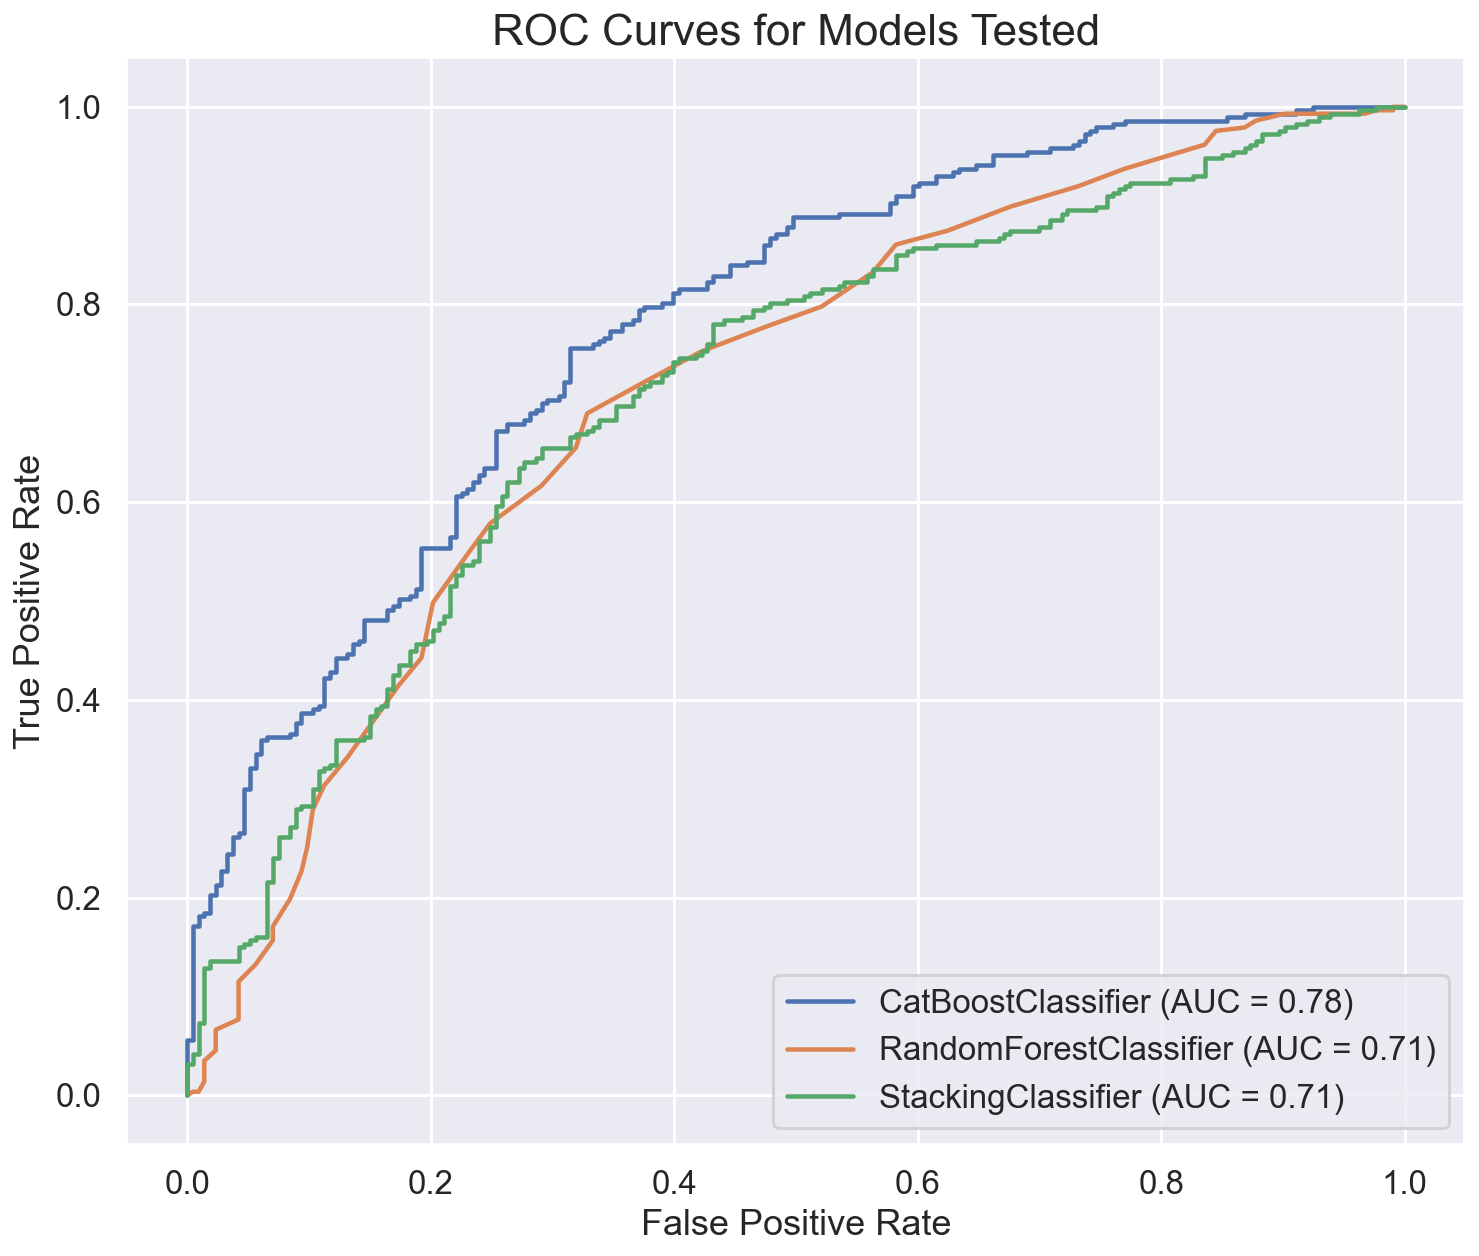

In [132]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
plot_roc_curve(cb_c, X_test_count, y_test, ax=ax)
plot_roc_curve(rf, X_test_count, y_test, ax=ax)
# plot_roc_curve(model_t, X_test_tfidf, y_test, ax=ax) # Cannot be plotted properly due to vecstack library
plot_roc_curve(model_c_sci, X_test_count.toarray(), y_test, ax=ax)

plt.title('ROC Curves for Models Tested', fontsize=22)
plt.legend();

We can see that the CatBoostClassifier has the superior AUC score.

The models with their details and metrics are as follows:

|Model|Vectorization|Test Accuracy|Cross-Val Training Accuracy (5-fold)|Training Accuracy|F1 Score (Bipolar 1)|F1 Score (Bipolar 2)|ROC AUC|
|---|---|---|---|---|---|---|---|
|**CatBoost Classifier**|Count|0.72|0.69|0.89|0.61|0.78|0.78|
|**Random Forest**|Count|0.65|0.65|1.00|0.44|0.75|0.71|
|**CatBoost + XGBoost + LGBM Classifiers**|TFIDF|0.71|0.67|0.68|0.59|0.78|0.68|
|**LogisticRegression + KNeighborsClassifier + DecisionTreeClassifier + SVC + MultinomialNB**|TFIDF|0.69|0.65|0.99|0.03|0.73|0.71|

The results indicate that the CatBoost Classifier is on par or superior in metrics other than accuracy. For example, it has better F1 scores as well. The cross-validated score is also very close to the test score. Combined with the fact that it has an accuracy above 0.7, it is thus the model of choice. 

Below, we can plot a confusion matrix for the chosen model.

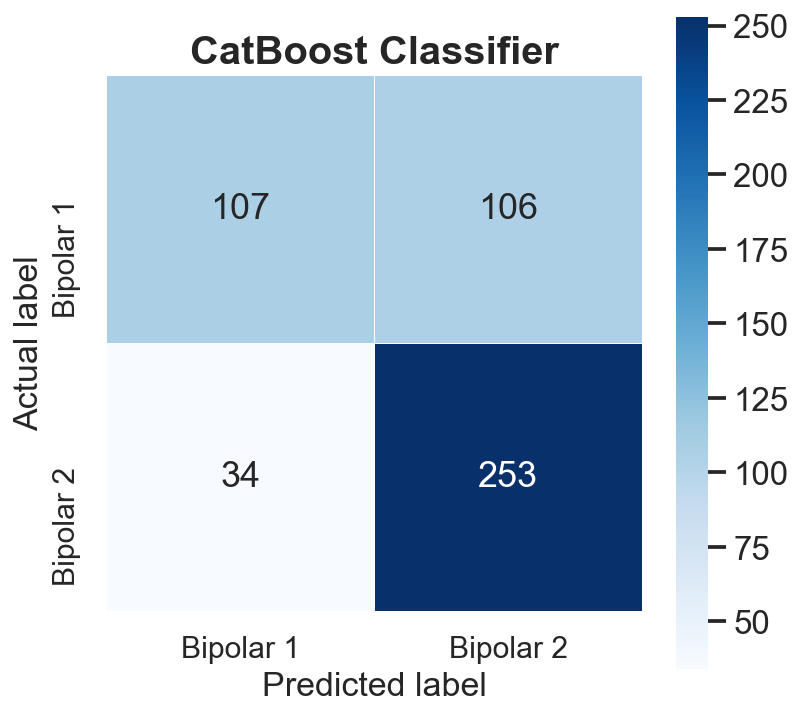

In [139]:
cat_c_cm = metrics.confusion_matrix(y_test, y_pred_cb_c)

plt.figure(figsize=(6,6))
sns.heatmap(cat_c_cm,
            annot=True,
            fmt='.0f',
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['Bipolar 1', 'Bipolar 2'],
            yticklabels = ['Bipolar 1', 'Bipolar 2'],
            );

plt.ylabel('Actual label', fontsize=17);
plt.xlabel('Predicted label', fontsize=17);
plt.title('CatBoost Classifier', weight='bold', fontsize=20);
plt.tick_params(labelsize=15)

We can see that the model can do much better in predicting Bipolar 1 posts.

We can plot the feature importances in order to see what are the main predictors for the classifier. 

In [136]:
# Getting a DataFrame of the features
features_df = pd.DataFrame(X_train_count.toarray(), columns=count_vect.get_feature_names())

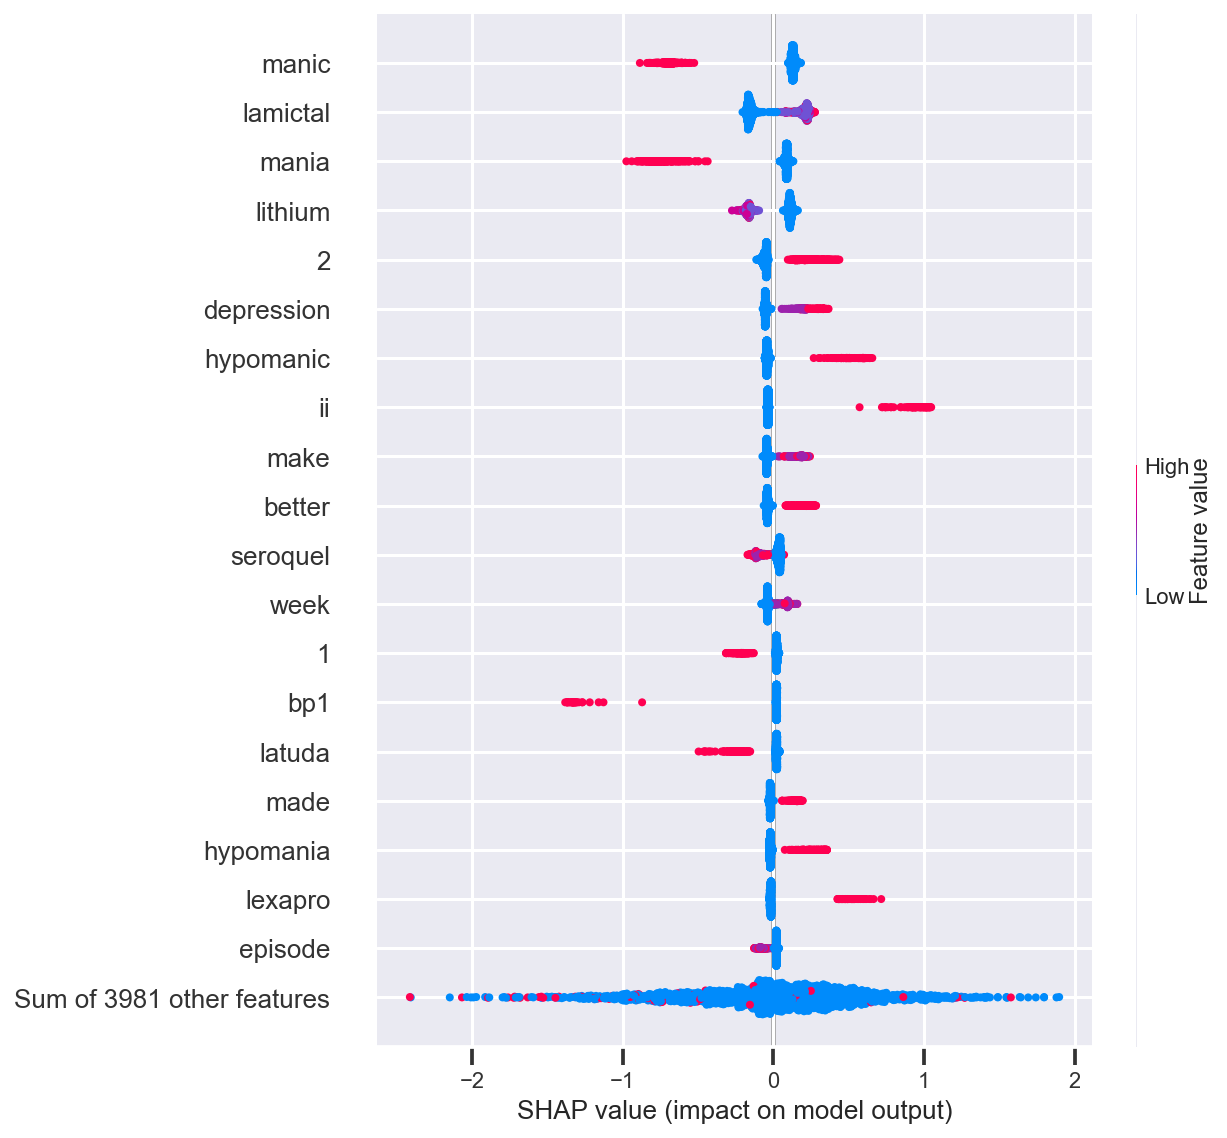

<Figure size 576x360 with 0 Axes>

In [138]:
# Generating SHAP values
explainer = shap.Explainer(cb_c)
shap_values = explainer(features_df)

shap.plots.beeswarm(shap_values, max_display=20)
fig = plt.gcf()
fig.set_size_inches(8,5)

Here, we can clearly see that there are many more predictors for Bipolar 2 than Bipolar 1. Hence, this would explain the difference in ability to classify the two classes.

We can fetch the rows where the model made a mistake.

In [140]:
# Creating a DataFrame showing the text with the actual and predicted classes 
cb_df = pd.DataFrame(X_test, columns=['text'])
cb_df['actual'] = y_test
cb_df['predicted'] = y_pred_cb_c
cb_wrong = cb_df[cb_df["actual"] != cb_df["predicted"]]

Here are posts that should have been predicted as Bipolar 2 but were predicted as Bipolar 1:

In [142]:
cb_wrong[cb_wrong['predicted'] == 1].head()

,text,actual,predicted
1375,"My seroquel solution: caffeine pills I've had a ridiculously hard time waking up in the morning because of the Seroquel 300 mg I take every night at bed time. I've started swallowing 200-400 mg of caffeine (1-2 cups of coffee) an hour before I get up to ease the transition. I've realized that I don't want to tell my psychiatrist about this and realizing that has made me feel a little nervous. I don't want to do anything beyond the scope of expert professional opinion, but I haven't been given many options really. Additionally I have been feeling very sharp lately. I've always been known to be smart, creative, and original so feeling that way isn't totally inappropriate. Sometimes it gets to the level of feeling like I could make a genius contribution to science. I am scientifically, mathematically, logically involved so the idea is not completely random. Nonetheless I feel skeptical that this might be a symptom of my disease and that if I tell my doctor about this he's going to fre...",2,1
668,Seroquel And Risperidone Anyone have any idea if they both cause gynecomastia? I know Risperidone does. But does anyone have those types of symptoms from Seroquel?,2,1
894,"Lamotrigine and the birth control pill Hey folks, When I started lamotrigine a year ago I was on a combined BC pill. My doctor only told me that lamotrigine might make my birth control less effective, and to use a backup method. Did that, and eventually just went off the pill altogether. I want to go back on it for lots of non-sex related things (and then continue to use backup protection for sex). I want to regulate my extremely irregular period, and I want the positive benefits for my acne prone skin, even if it means tweaking my lamotrigine dose. My doc and I talked about an IUD, but that will most likely make my acne worse, and it a hormonal IUD might affect lamotrigine levels too. I looked into the patch, or the ring, but same deal. If there's hormones, lamotrigine is going to fuck with them, and hormones are going to lower my levels of lamotrigine. Neither my GP or the doctor at a women's clinic who prescribed my BC seemed to have solid answers to my questions. Is there any...",2,1
2476,"4 months update Dear Bipolar, I can't believe it's been 4 months since I went to see a therapist. I can't say for sure it's been a perfect few months, I still feel the bumps, lows and highs, but they are becoming 'things' I can handle. Since tonight I can't sleep (again Lamictal) I'm going to give a 'brief' summary a go. Month 1: Hard to fully accept the diagnosis, felt like it fits but could not internalise the consequences of meds, and letting loved ones know about the condition openly. Had a long dinner with my parents, and discussed about 'cuckoo' relatives, learnt all the dark family histories. Was the first time everyone was frank, and I needed that. Started on very low dose Lamictal, itchiness subsides fairly quickly. Didn't feel much effect on 25mg but felt a bit more positive (maybe?). Felt like a depression is coming soon. Month 2: Told GF about suicide thoughts, she freaked out. Reassured her about having previous thoughts the whole of my life. First time to slowly open ...",2,1
584,"Acute writer’s block since manic episode. Any suggestions from you lovely creatives would be welcome Greetings fam! I saw that so many of you find solace in creative projects, and wanted your advice. I am a graduate student, and writing (creative and academic pieces - articles, op-eds and theses) used to be my lifeline. Words would flow from my fingertips with great ease, and I never had to worry about stumbling over words, finding perfect phrases to encapsulate my emotions over specific themes, or generally moving forward with my writing in any way whatsoever. I had a sharp manic psychosis last May, followed by a hospitalisation. The crash since then has been inevitable, and as most of you know, draining at many levels. I spiralled into the worst depression o

Here are posts that should have been predicted as Bipolar 1 but were predicted as Bipolar 2:

In [143]:
cb_wrong[cb_wrong['predicted'] == 2].head()

,text,actual,predicted
606,"Hair Loss I’m sure I’m not the only one to experience this. I wanted to ask what remedies some of you have found. I’ve been taking selenium sulfide and zinc sulfate consistently for a year and it has helped so much. I just wanted to share this because I remember how terrifying it was to watch my hair pouring down the drain. I’m taking lithium and lamotrigine, not sure if the Zyprexa I was taking had anything to do with it too.",1,2
1999,"Seroquel to Latuda- Sleepness nights again... I just went from 300 MG of Seroquel XR to 40mg of Latuda. The Seroquel had actually stopped working mood stabilization wise but it still would knock me out (most of the time). Now that I have been on Latuda for 5 days I feel better mood wise but I can't sleep again. Has anybody, who has taken Latuda, ever really felt drowsy after taking it? If so, how much was the mg on it? Also can anybody recommend an over the counter sleep aid that they have used in combination with mood stabilizers?",1,2
1952,"Blood tests to diagnose? So my psychologist thinks/says I'm Bipolar I, she told me to go see a psychiatrist. The psychiatrist asks me a bunch of questions, we talk for like an hour, and he says he wants me to get blood tests done, he writes the order out on an a little official sheet of paper and also writes ""Dx: bipolar II"" on it. Is there possibly something that could show up in my blood tests that would mean I'm not bipolar at all? He wanted me to do them before he prescribed me Lamictal and Wellbutrin. Do they normally have people do blood tests? I already did my blood tests and I see him again tomorrow, so I guess I can ask him, but I was just curious about other people's experiences. I don't really know anything about bipolar disorder. I don't completely understand the difference between I and II, from what I read they sound pretty much the same except one is more intense? Should I tell him my psychologist thinks I'm Bipolar I? Get a third opinion? I originally went to the ps...",1,2
1166,"I feel like I'm living a catch 22 If I see symptoms that are reminiscent of a mixed episode, does that mean that it isn't one, because I'm aware of it? (kind of like, people can't be considered insane if they say that they are). It feels like the pandora box of bipolar. Or, catch 22? It's a weird conundrum of self awareness in which I see similar symptoms but I'm also going through a lot right now, and recently lowered my Lamictal dose. So I can't tell if feeling the way that I do is a Normal Person™ response to everything I'm dealing with or if I should start looking for damage control. I hate this questioning because I don't want to sound like I want to be in a bad place but also I never realize how South things go until like two weeks into into the aftermath.",1,2
2251,"How many of you have had a suicidal response to medication? You know, that big warning that always comes with meds that are supposed to do the opposite. I still feel affected a bit by the experience. I have never suddenly felt that way before so severely. It was as though everything in life turned black and everything was misery. Anxiety had me in a choke hold and there was no relief to anything. Voices told me a thousand negative things if I tried to lay down. It was different than my normal depression, which is usually gray and apathetic. This was from Latuda, by the way. I posted about it before, but now I'm wondering how common this side effect is for any med. I would like to get of Seroquel, but I'm scared of trying anything new for this reason. Having a good day though. Positive feelings for everyone :)",1,2


It is not clear from the posts what class they are supposed to be. Thus, there is a high level of difficult for this NLP problem.

# Conclusion and Recommendations

In summary, we have achieved a model that has a test accuracy of 0.7. The chosen model was CatBoost Classifier on the default parameters. There were efforts to optimise the model, but it turned out that the winning model was the un-optimised one. Further analyses showed that the problem was not easy to solve. To date, no similar classifier has been built. Existing classifiers focussed more on diagnosing the presence and absence of the disease, rather than the subtype.

From the EDA, we have gained some insights that would be useful to both clinicians and individuals with bipolar. Notably, there are some time-based patterns that were observed. For Bipolar Type 1, these individuals should be monitored during April especially due to the risk of manic or mixed instability. They should also be monitored during September to October. For Bipolar Type 2, these individuals should be monitored during Auguest and October. They should also be monitored on weekends. The main risk for Type 2 individuals would be depressive episodes. For both types, individuals had concerns with side effects, in particular, weight gain. It appeared that users of the subreddit wanted to compare their experience with that of others and find out more information. 

To develop the project further, these analyses could be done using a different scope. For example, problems with family or employment could be investigated by changing the search keywords when pulling the data. Next, the main concerns surfaced on the subreddit could be used to form Q&A material that could be provided by clinicians to patients, so that advice on the condition can be verified by medical professionals. This is part of a strategy to counter the disorder, called psychoeducation. Also, if the concerns raised on the subreddit are quite different from what they have discussed with patients, clinicians might be alterted to concerns that patients are not comfortable to tell them directly. Clinicians would also be better attuned to specific concerns about the medications studied. Lastly, if the classifier reaches a high enough accuracy, it could be used to label the approximately 90% of posts where post authors have not explicitly declared their bipolar subtype. This would increase the resolution of insights that we can glean from this treasure trove of textual data. 

We have merely scraped the surface, and there is still much to be studied from the vast banks of user-generated text available on Reddit. In summary, this project has been a useful exercise to illustrate the potential of data science to reveal insights, as well as providing some practical action points for both clinicians and people with bipolar to better manange this serious condition.